In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 5]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [4]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [5]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [6]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]

In [7]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [8]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [9]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max          ...            ctc_max  last_word_eq  \
0  0.833319  0.999983  0.999983          ...           0.785709           0.0   
1  0.399996  0.749981  0.599988          ...           0.466664           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   
1            1.0           5.0      12.5               86                63   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0          93                 100              0.982759  
1          66                  75              0.596154  

[2 rows x 21 columns]

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(1,4))
df_q_one = vect.fit_transform(df['question1'].values.astype('U'))
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
df_q_one.shape

(404290, 4068576)

ooook, this would take a lot of time

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(1,4),max_features=20000)
df_q_one = vect.fit_transform(df['question1'].values.astype('U'))
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
df_q_one.shape

(404290, 20000)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(ngram_range=(1,4),max_features=20000)
df_q_two = vect.fit_transform(df['question2'].values.astype('U'))

df_q_two.shape

(404290, 20000)

In [12]:
X = df.drop(['is_duplicate'],axis=1)


In [13]:
import scipy.sparse
from scipy.sparse import coo_matrix, hstack
X = scipy.sparse.hstack((df_q_one,df_q_two))

In [14]:
X

<404290x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 13720667 stored elements in COOrdinate format>

In [15]:
y_true = df['is_duplicate']
from sklearn.cross_validation import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y_true, stratify=y_true, test_size=0.2)

In [16]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (323432, 40000)
Number of data points in test data : (80858, 40000)


In [21]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308033837097133 Class 1:  0.36919661629028666
---------- Distribution of output variable in test data ----------
Class 0:  0.36920279997031835 Class 1:  0.36920279997031835


In [18]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two dimensionsl array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

__Building a random model so that we can find out the threshold of our log loss.__

Log loss on Test Data using Random Model 0.8905656559613436


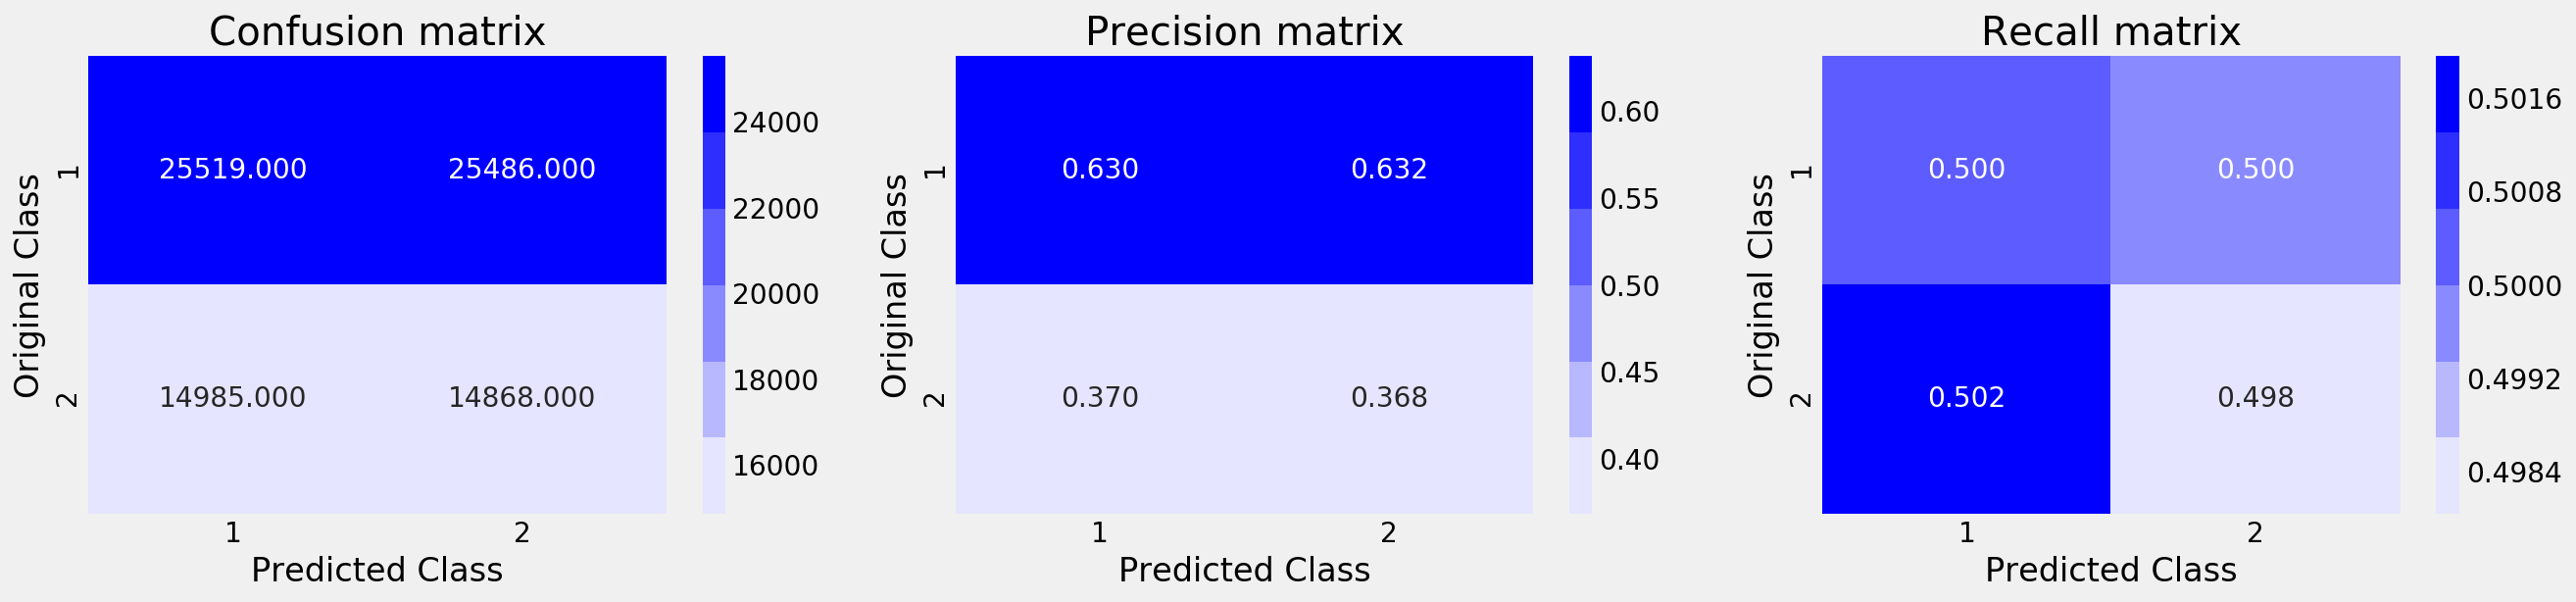

In [20]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

__Logistic Regression using SGD classifier with log loss__

In [19]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st
from datetime import datetime
from sklearn.linear_model import LogisticRegression

For values of alpha =  1e-07 The log loss is: 0.5427532877913069
For values of alpha =  1e-06 The log loss is: 0.5065490234258635
For values of alpha =  1e-05 The log loss is: 0.4925248740364623
For values of alpha =  0.0001 The log loss is: 0.5189720286680636
For values of alpha =  0.001 The log loss is: 0.5584789989290293
For values of alpha =  0.01 The log loss is: 0.5890861957952741
For values of alpha =  0.1 The log loss is: 0.627487140629177
For values of alpha =  1 The log loss is: 0.6348418859884559
For values of alpha =  10 The log loss is: 0.635580287554288
For values of alpha =  100 The log loss is: 0.6356707890458261
For values of alpha =  1000 The log loss is: 0.6356888704374231
For values of alpha =  10000 The log loss is: 0.6356957061890495
For values of alpha =  100000 The log loss is: 0.6356992066934917
For values of alpha =  1000000 The log loss is: 0.6357011376974551


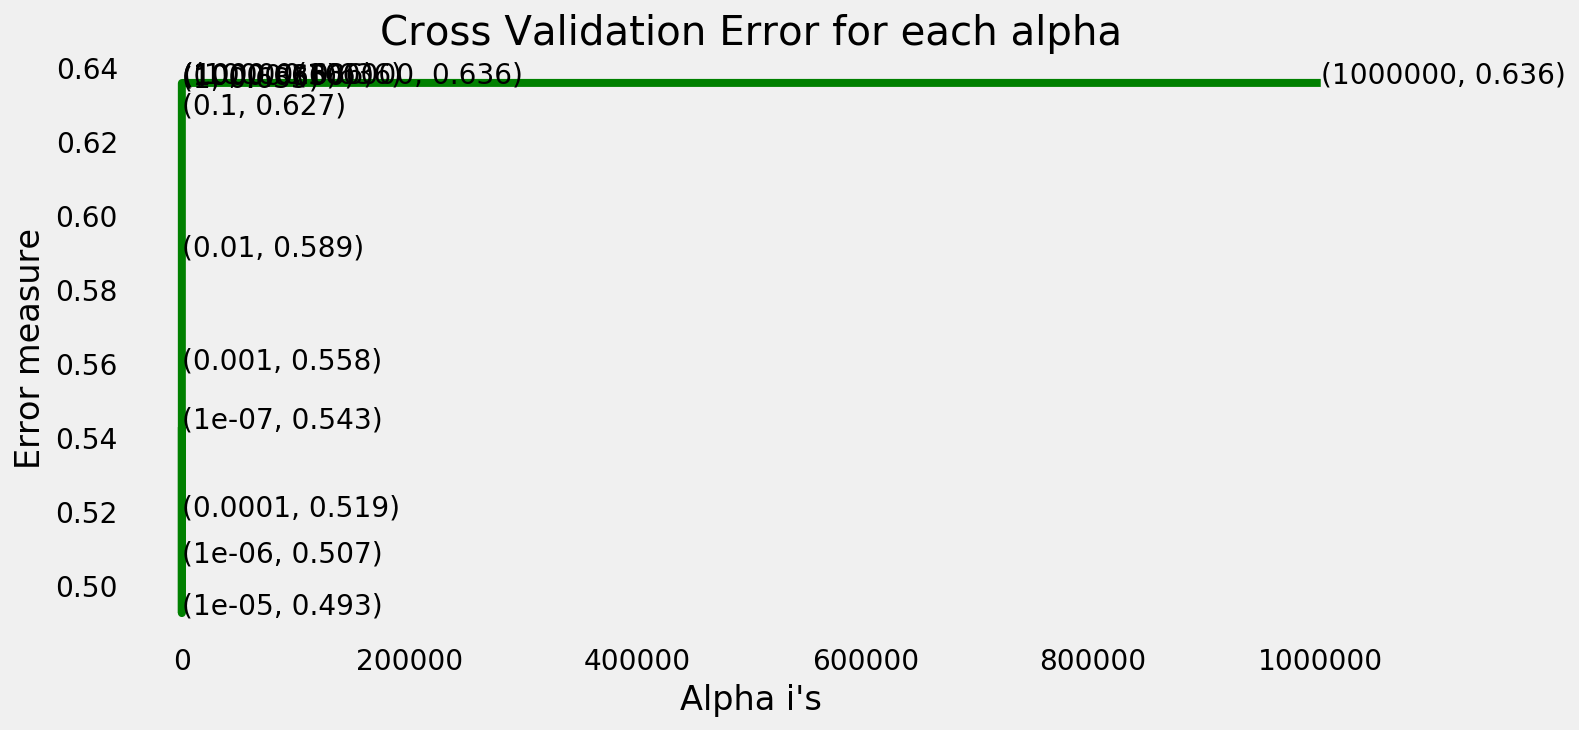

For values of best alpha =  1e-05 The train log loss is: 0.461575676304871
For values of best alpha =  1e-05 The test log loss is: 0.4925248740364623
Total number of data points : 80858


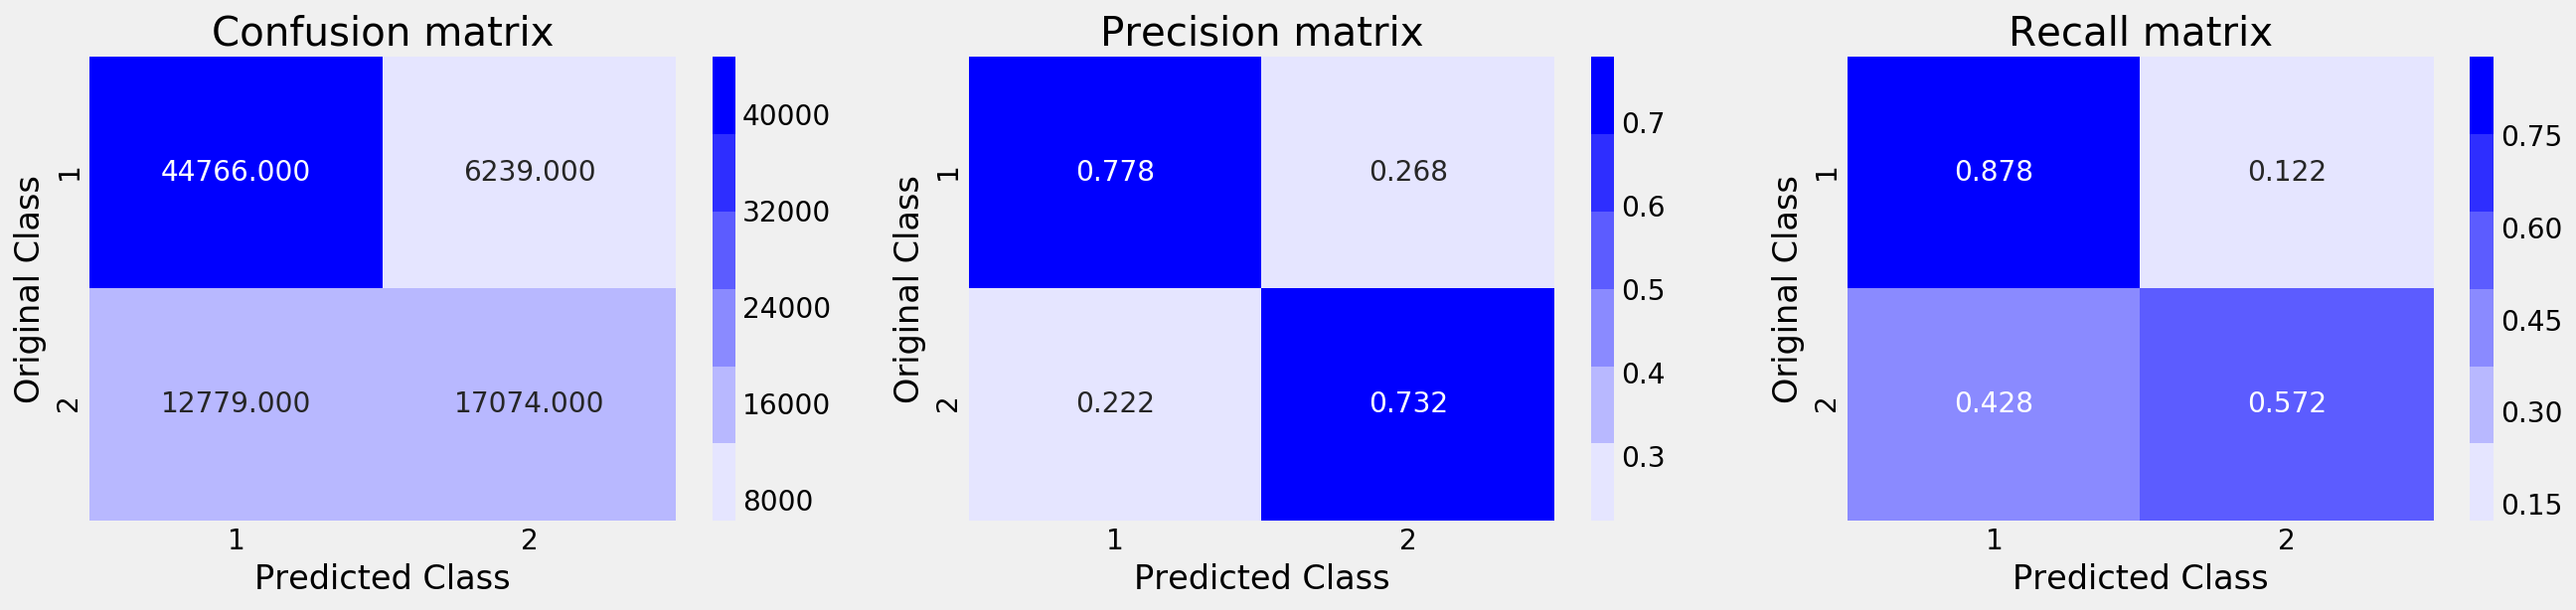

Time taken to run this cell : 0:00:57.692394


In [22]:
start = datetime.now()


alpha = [10 ** x for x in range(-7, 7)] # hyperparam for SGD classifier.




log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


print('='*100)
print("Time taken to run this cell :", datetime.now() - start)
print('='*100)

__Logistic Regression : Logistic Regression__

For values of C =  1e-07 The log loss is: 0.6355753198436918
For values of C =  1e-06 The log loss is: 0.6344302957246559
For values of C =  1e-05 The log loss is: 0.6242502468212713
For values of C =  0.0001 The log loss is: 0.5970285048148198
For values of C =  0.001 The log loss is: 0.5812780461459526
For values of C =  0.01 The log loss is: 0.5450492336812047
For values of C =  0.1 The log loss is: 0.5073508279446839
For values of C =  1 The log loss is: 0.4887340804280247
For values of C =  10 The log loss is: 0.49579327729538286
For values of C =  100 The log loss is: 0.5062496907263982
For values of C =  1000 The log loss is: 0.5116333453758863
For values of C =  10000 The log loss is: 0.5136546268594419
For values of C =  100000 The log loss is: 0.5140976458355204
For values of C =  1000000 The log loss is: 0.5105868284714733


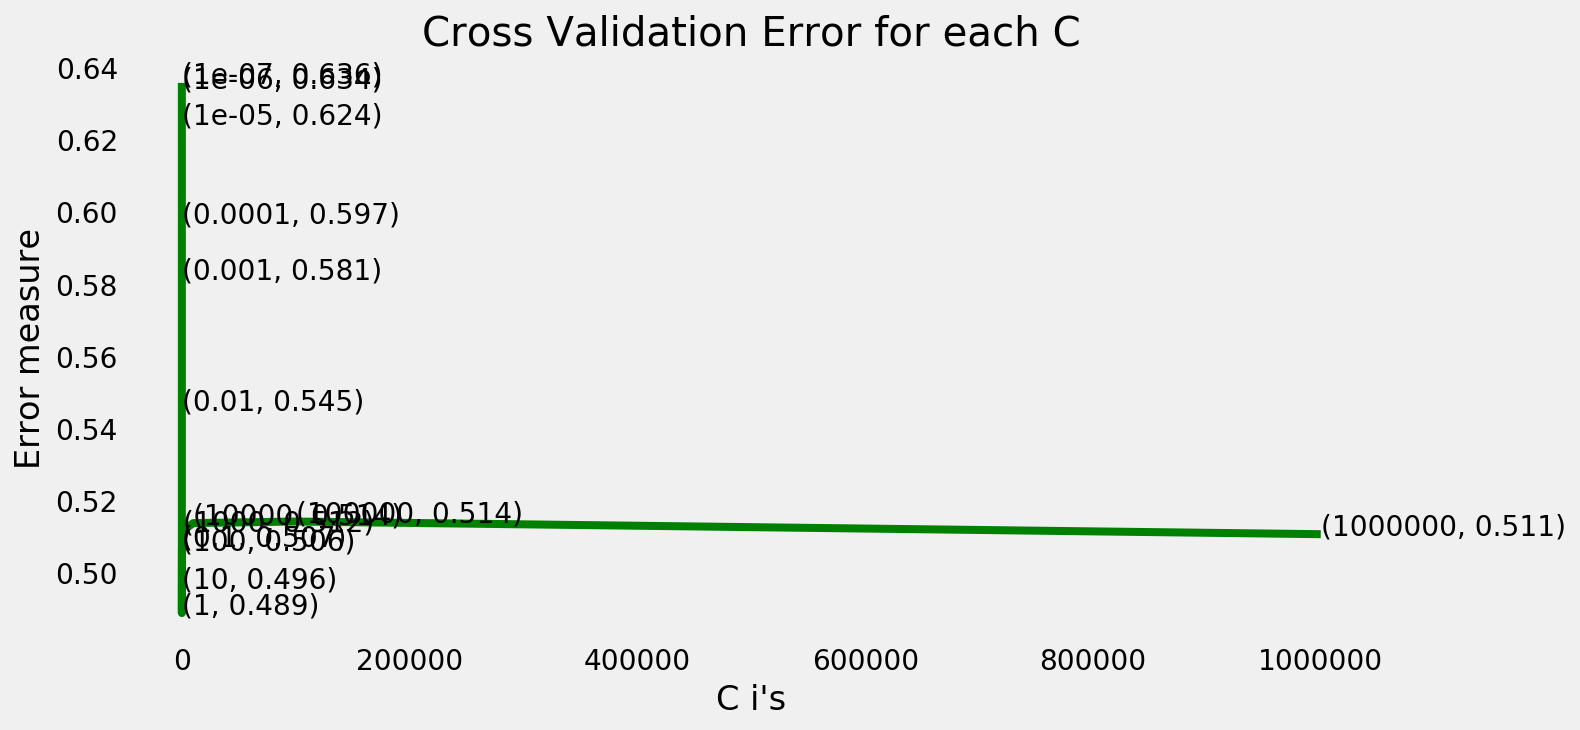

For values of best C =  1 The train log loss is: 0.448829242134321
For values of best C =  1 The test log loss is: 0.4887340804280247
Total number of data points : 80858


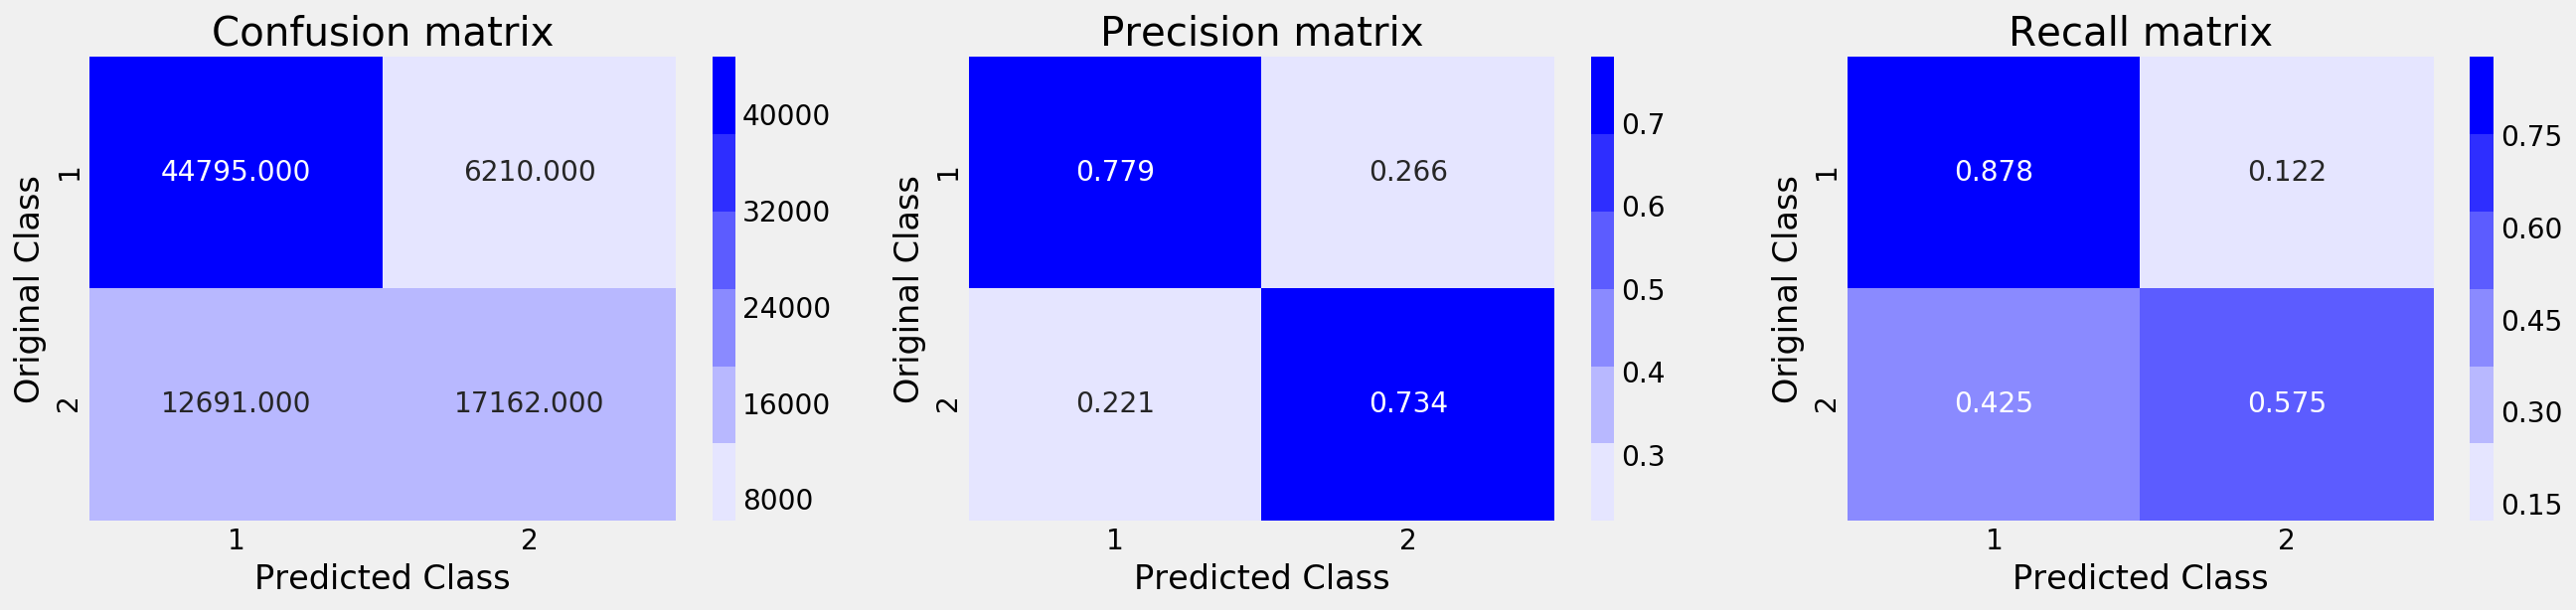

Time taken to run this cell : 1:03:28.628900


In [23]:
start = datetime.now()


C = [10 ** x for x in range(-7, 7)] # hyperparam for linear regression classifier.




log_error_array=[]
for i in C:
    clf = LogisticRegression(C = i, penalty='l2', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of C = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(C, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((C[i],np.round(txt,3)), (C[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each C")
plt.xlabel("C i's")
plt.ylabel("Error measure")
plt.show()


best_C = np.argmin(log_error_array)
clf = LogisticRegression(C = C[best_C], penalty='l2', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best C = ', C[best_C], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best C = ', C[best_C], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


print('='*100)
print("Time taken to run this cell :", datetime.now() - start)
print('='*100)

__Linear SVM__

For values of alpha =  1e-07 The log loss is: 0.5323382145982767
For values of alpha =  1e-06 The log loss is: 0.5208668162887481
For values of alpha =  1e-05 The log loss is: 0.509230647539056
For values of alpha =  0.0001 The log loss is: 0.5938705654286839
For values of alpha =  0.001 The log loss is: 0.6546532352782019
For values of alpha =  0.01 The log loss is: 0.6585300338918999
For values of alpha =  0.1 The log loss is: 0.6585300338918075
For values of alpha =  1 The log loss is: 0.6585300338919
For values of alpha =  10 The log loss is: 0.6585300338918159
For values of alpha =  100 The log loss is: 0.6585300338919
For values of alpha =  1000 The log loss is: 0.6585300338918629
For values of alpha =  10000 The log loss is: 0.6585300338918157
For values of alpha =  100000 The log loss is: 0.6585300338919
For values of alpha =  1000000 The log loss is: 0.6585300338918667


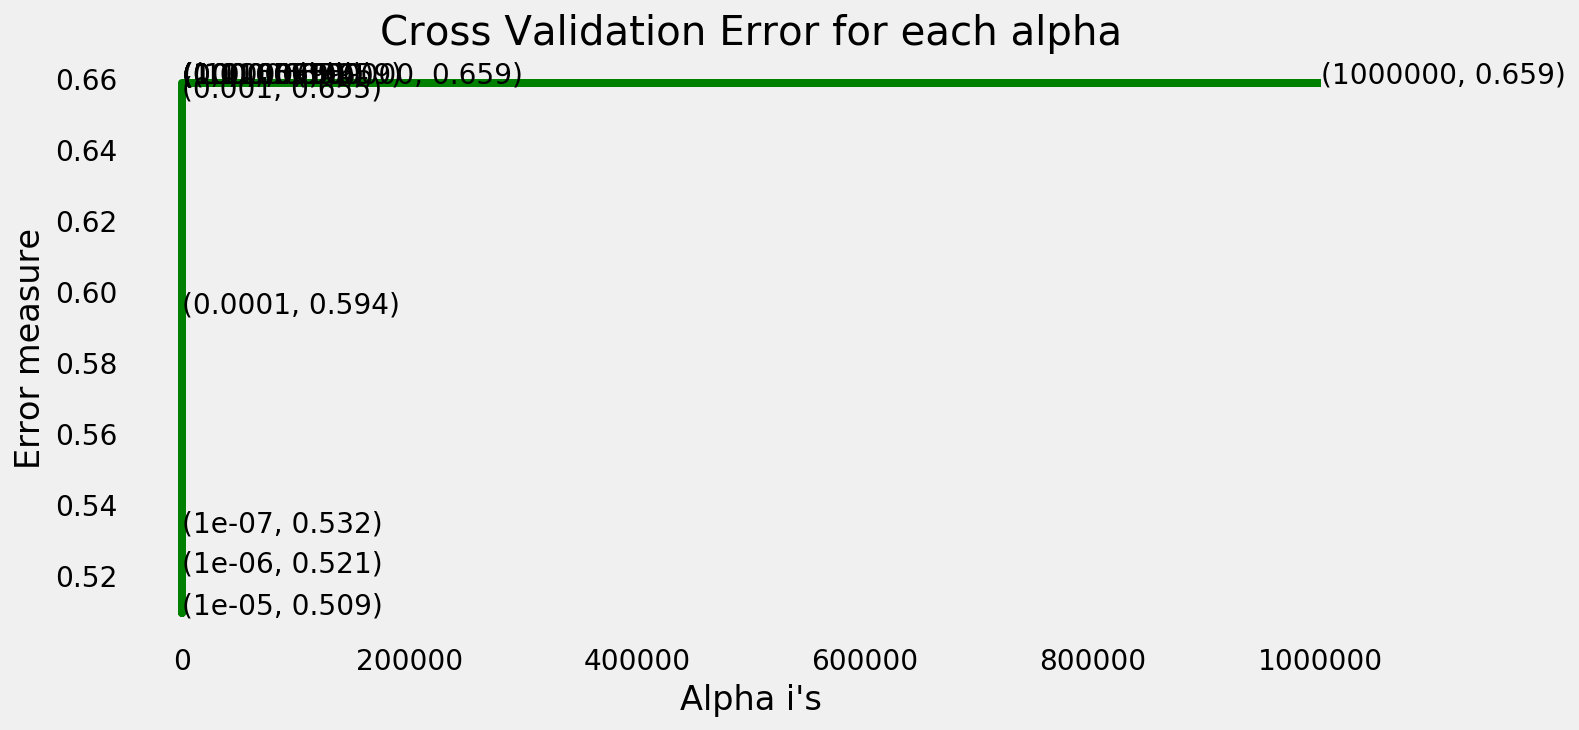

For values of best alpha =  1e-05 The train log loss is: 0.461575676304871
For values of best alpha =  1e-05 The test log loss is: 0.4925248740364623
Total number of data points : 80858


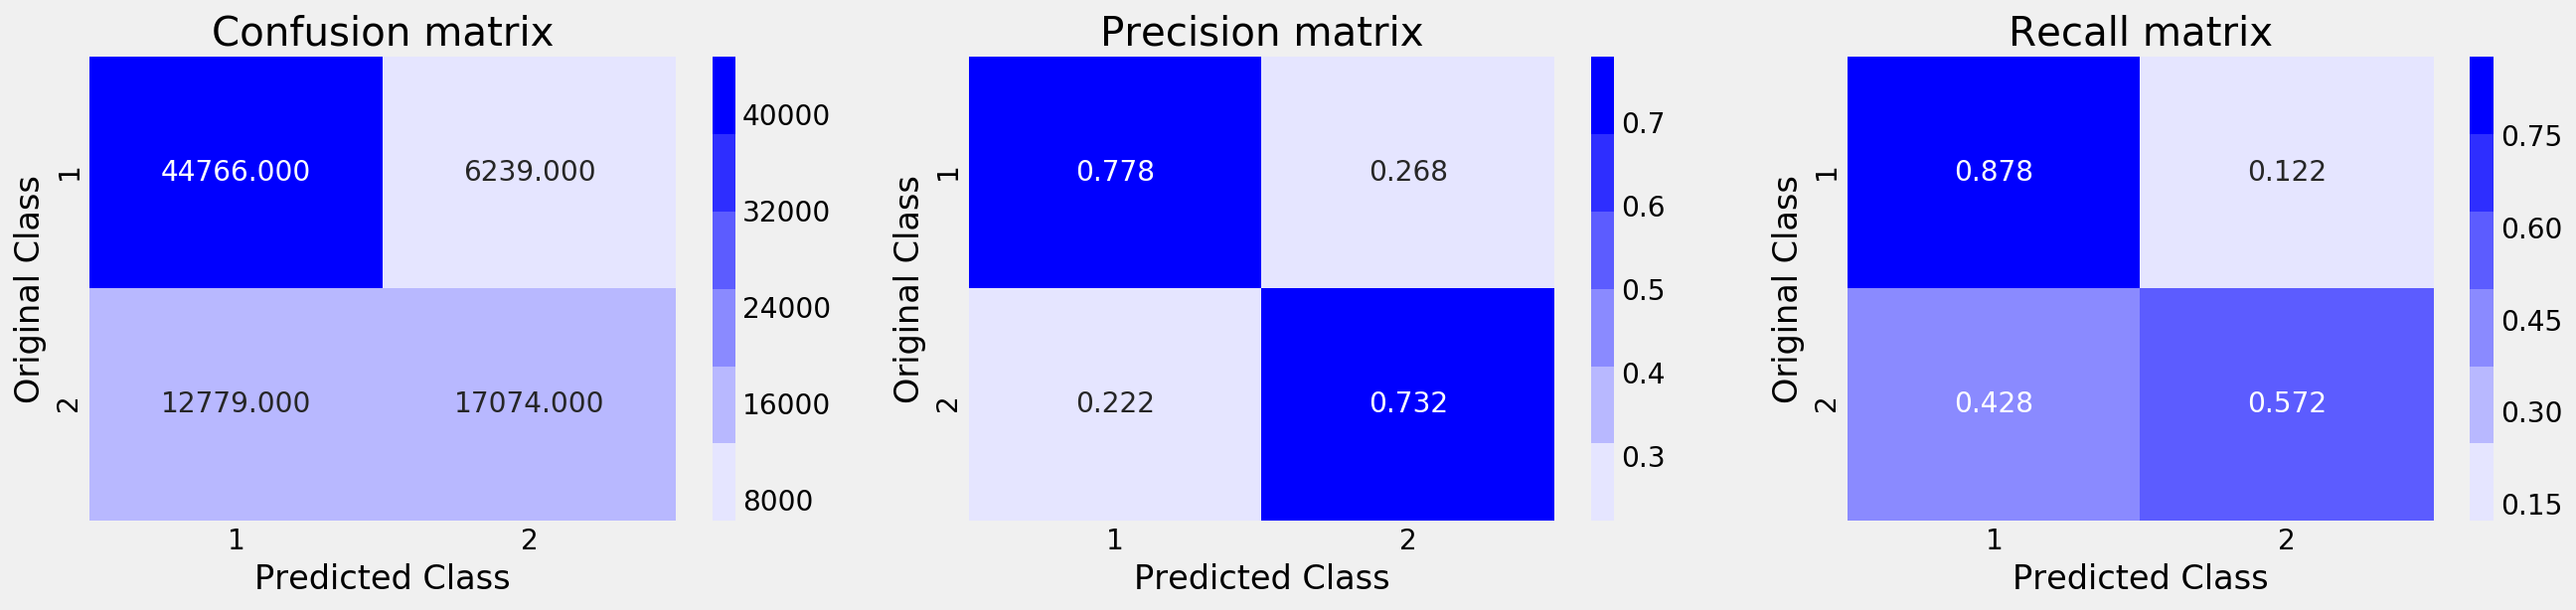

Time taken to run this cell : 0:01:06.520736


In [24]:
start = datetime.now()


alpha = [10 ** x for x in range(-7, 7)] # hyperparam for SGD classifier.

#
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


print('='*100)
print("Time taken to run this cell :", datetime.now() - start)
print('='*100)

In [21]:
start = datetime.now()

#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


param = {
        'silent': [False],
        'max_depth': [2,4,6,8,10],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3,0.5,0.75,1],
        'subsample': [0.001,0.01,0.1,0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.2,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.2,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5,0.75, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10, 100],
        'n_estimators': [1000]}



fit_params = {'eval_metric': 'logloss',
              'early_stopping_rounds': 10,
              'eval_set': [(X_train, y_train)]
              }

clf = xgb.XGBClassifier(nthread = 4)


model = RandomizedSearchCV(clf, param, n_iter=20,
                            n_jobs=1, verbose=2, cv=2,
                            fit_params=fit_params,
                            scoring='neg_log_loss', refit=False, random_state=42)


model.fit(X_train, y_train)


print('='*100)
print("Time taken to run this cell :", datetime.now() - start)
print('='*100)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] subsample=1.0, silent=False, reg_lambda=50.0, reg_alpha=10, n_estimators=1000, min_child_weight=3.0, max_depth=10, learning_rate=0.1, gamma=0.75, colsample_bytree=0.6, colsample_bylevel=1.0 
[21:43:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 60 pruned nodes, max_depth=10
[0]	validation_0-logloss:0.679089
Will train until validation_0-logloss hasn't improved in 10 rounds.
[21:43:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 62 pruned nodes, max_depth=10
[1]	validation_0-logloss:0.667376
[21:43:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 66 pruned nodes, max_depth=10
[2]	validation_0-logloss:0.656798
[21:43:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 

[21:44:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 16 pruned nodes, max_depth=10
[42]	validation_0-logloss:0.560561
[21:44:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 22 pruned nodes, max_depth=10
[43]	validation_0-logloss:0.559799
[21:44:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 34 pruned nodes, max_depth=10
[44]	validation_0-logloss:0.55909
[21:44:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 32 pruned nodes, max_depth=10
[45]	validation_0-logloss:0.558344
[21:44:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 36 pruned nodes, max_depth=10
[46]	validation_0-logloss:0.557445
[21:44:30] C:\Users\Administrator\Desktop\xgboost\src\tr

[21:45:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 34 pruned nodes, max_depth=10
[86]	validation_0-logloss:0.531204
[21:45:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 18 pruned nodes, max_depth=10
[87]	validation_0-logloss:0.530681
[21:45:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 20 pruned nodes, max_depth=10
[88]	validation_0-logloss:0.530199
[21:45:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 4 pruned nodes, max_depth=10
[89]	validation_0-logloss:0.529919
[21:45:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 50 pruned nodes, max_depth=10
[90]	validation_0-logloss:0.529484
[21:45:04] C:\Users\Administrator\Desktop\xgboost\src\tr

[21:45:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 12 pruned nodes, max_depth=10
[130]	validation_0-logloss:0.515323
[21:45:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 26 pruned nodes, max_depth=10
[131]	validation_0-logloss:0.515054
[21:45:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 16 pruned nodes, max_depth=10
[132]	validation_0-logloss:0.514835
[21:45:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 24 pruned nodes, max_depth=10
[133]	validation_0-logloss:0.514571
[21:45:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 28 pruned nodes, max_depth=10
[134]	validation_0-logloss:0.514359
[21:45:37] C:\Users\Administrator\Desktop\xgboost\sr

[21:46:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 10 pruned nodes, max_depth=10
[174]	validation_0-logloss:0.504898
[21:46:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 8 pruned nodes, max_depth=10
[175]	validation_0-logloss:0.50473
[21:46:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 14 pruned nodes, max_depth=10
[176]	validation_0-logloss:0.504598
[21:46:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 14 pruned nodes, max_depth=10
[177]	validation_0-logloss:0.504415
[21:46:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 16 pruned nodes, max_depth=10
[178]	validation_0-logloss:0.504135
[21:46:10] C:\Users\Administrator\Desktop\xgboost\src\tr

[21:46:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 22 pruned nodes, max_depth=10
[218]	validation_0-logloss:0.496681
[21:46:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 20 pruned nodes, max_depth=10
[219]	validation_0-logloss:0.49657
[21:46:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 22 pruned nodes, max_depth=10
[220]	validation_0-logloss:0.496467
[21:46:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 16 pruned nodes, max_depth=10
[221]	validation_0-logloss:0.496329
[21:46:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 44 pruned nodes, max_depth=10
[222]	validation_0-logloss:0.496185
[21:46:42] C:\Users\Administrator\Desktop\xgboost\src\t

[21:47:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 8 pruned nodes, max_depth=10
[262]	validation_0-logloss:0.491093
[21:47:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 28 pruned nodes, max_depth=10
[263]	validation_0-logloss:0.491011
[21:47:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 46 pruned nodes, max_depth=10
[264]	validation_0-logloss:0.490798
[21:47:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 54 pruned nodes, max_depth=10
[265]	validation_0-logloss:0.490386
[21:47:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 18 pruned nodes, max_depth=10
[266]	validation_0-logloss:0.490302
[21:47:16] C:\Users\Administrator\Desktop\xgboost\src\

[21:47:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 18 pruned nodes, max_depth=10
[306]	validation_0-logloss:0.48532
[21:47:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 32 pruned nodes, max_depth=10
[307]	validation_0-logloss:0.485249
[21:47:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 8 pruned nodes, max_depth=10
[308]	validation_0-logloss:0.48516
[21:47:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 32 pruned nodes, max_depth=10
[309]	validation_0-logloss:0.48503
[21:47:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 20 pruned nodes, max_depth=10
[310]	validation_0-logloss:0.484943
[21:47:49] C:\Users\Administrator\Desktop\xgboost\src\tree\

[21:48:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 24 pruned nodes, max_depth=10
[350]	validation_0-logloss:0.481164
[21:48:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 30 pruned nodes, max_depth=10
[351]	validation_0-logloss:0.481072
[21:48:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 54 pruned nodes, max_depth=10
[352]	validation_0-logloss:0.480941
[21:48:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 24 pruned nodes, max_depth=10
[353]	validation_0-logloss:0.480888
[21:48:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 20 pruned nodes, max_depth=10
[354]	validation_0-logloss:0.480826
[21:48:21] C:\Users\Administrator\Desktop\xgboost\src\

[21:48:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 20 pruned nodes, max_depth=10
[394]	validation_0-logloss:0.477412
[21:48:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 4 pruned nodes, max_depth=10
[395]	validation_0-logloss:0.47736
[21:48:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 22 pruned nodes, max_depth=10
[396]	validation_0-logloss:0.477286
[21:48:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 30 pruned nodes, max_depth=10
[397]	validation_0-logloss:0.477218
[21:48:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 22 pruned nodes, max_depth=10
[398]	validation_0-logloss:0.477131
[21:48:54] C:\Users\Administrator\Desktop\xgboost\src\tre

[21:49:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max_depth=10
[438]	validation_0-logloss:0.473736
[21:49:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 34 pruned nodes, max_depth=10
[439]	validation_0-logloss:0.473572
[21:49:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 16 pruned nodes, max_depth=10
[440]	validation_0-logloss:0.473521
[21:49:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 20 pruned nodes, max_depth=10
[441]	validation_0-logloss:0.473473
[21:49:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 18 pruned nodes, max_depth=10
[442]	validation_0-logloss:0.473428
[21:49:26] C:\Users\Administrator\Desktop\xgboost\src\tr

[21:49:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 26 pruned nodes, max_depth=10
[482]	validation_0-logloss:0.470507
[21:49:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 24 pruned nodes, max_depth=10
[483]	validation_0-logloss:0.470465
[21:49:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 20 pruned nodes, max_depth=10
[484]	validation_0-logloss:0.470422
[21:49:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 20 pruned nodes, max_depth=10
[485]	validation_0-logloss:0.470355
[21:49:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 28 pruned nodes, max_depth=10
[486]	validation_0-logloss:0.470309
[21:49:58] C:\Users\Administrator\Desktop\xgboost\src\t

[21:50:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 18 pruned nodes, max_depth=10
[526]	validation_0-logloss:0.466932
[21:50:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 22 pruned nodes, max_depth=10
[527]	validation_0-logloss:0.466894
[21:50:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=10
[528]	validation_0-logloss:0.466862
[21:50:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 34 pruned nodes, max_depth=10
[529]	validation_0-logloss:0.466759
[21:50:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 10 pruned nodes, max_depth=10
[530]	validation_0-logloss:0.466719
[21:50:31] C:\Users\Administrator\Desktop\xgboost\src\t

[21:51:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 16 pruned nodes, max_depth=10
[570]	validation_0-logloss:0.464352
[21:51:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 18 pruned nodes, max_depth=10
[571]	validation_0-logloss:0.464322
[21:51:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 38 pruned nodes, max_depth=10
[572]	validation_0-logloss:0.464181
[21:51:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 26 pruned nodes, max_depth=10
[573]	validation_0-logloss:0.464119
[21:51:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 50 pruned nodes, max_depth=10
[574]	validation_0-logloss:0.464071
[21:51:03] C:\Users\Administrator\Desktop\xgboost\src\t

[21:51:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 24 pruned nodes, max_depth=10
[614]	validation_0-logloss:0.462042
[21:51:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 24 pruned nodes, max_depth=10
[615]	validation_0-logloss:0.462
[21:51:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 24 pruned nodes, max_depth=10
[616]	validation_0-logloss:0.46195
[21:51:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 58 pruned nodes, max_depth=10
[617]	validation_0-logloss:0.461794
[21:51:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 26 pruned nodes, max_depth=10
[618]	validation_0-logloss:0.461717
[21:51:36] C:\Users\Administrator\Desktop\xgboost\src\tre

[21:52:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 30 pruned nodes, max_depth=10
[658]	validation_0-logloss:0.460034
[21:52:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 22 pruned nodes, max_depth=10
[659]	validation_0-logloss:0.46001
[21:52:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 24 pruned nodes, max_depth=10
[660]	validation_0-logloss:0.459964
[21:52:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 18 pruned nodes, max_depth=10
[661]	validation_0-logloss:0.459932
[21:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 22 pruned nodes, max_depth=10
[662]	validation_0-logloss:0.45991
[21:52:08] C:\Users\Administrator\Desktop\xgboost\src\tre

[21:52:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 22 pruned nodes, max_depth=10
[702]	validation_0-logloss:0.4578
[21:52:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 22 pruned nodes, max_depth=10
[703]	validation_0-logloss:0.457745
[21:52:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=10
[704]	validation_0-logloss:0.457726
[21:52:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 30 pruned nodes, max_depth=10
[705]	validation_0-logloss:0.457674
[21:52:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 24 pruned nodes, max_depth=10
[706]	validation_0-logloss:0.457637
[21:52:41] C:\Users\Administrator\Desktop\xgboost\src\tre

[21:53:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 20 pruned nodes, max_depth=10
[746]	validation_0-logloss:0.455542
[21:53:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 14 pruned nodes, max_depth=10
[747]	validation_0-logloss:0.455515
[21:53:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 14 pruned nodes, max_depth=10
[748]	validation_0-logloss:0.455484
[21:53:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 30 pruned nodes, max_depth=10
[749]	validation_0-logloss:0.455429
[21:53:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 24 pruned nodes, max_depth=10
[750]	validation_0-logloss:0.455396
[21:53:14] C:\Users\Administrator\Desktop\xgboost\src\t

[21:53:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 18 pruned nodes, max_depth=10
[790]	validation_0-logloss:0.45328
[21:53:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 18 pruned nodes, max_depth=10
[791]	validation_0-logloss:0.453253
[21:53:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 30 pruned nodes, max_depth=10
[792]	validation_0-logloss:0.453221
[21:53:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 22 pruned nodes, max_depth=10
[793]	validation_0-logloss:0.453188
[21:53:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 22 pruned nodes, max_depth=10
[794]	validation_0-logloss:0.45314
[21:53:47] C:\Users\Administrator\Desktop\xgboost\src\tre

[21:54:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 8 pruned nodes, max_depth=10
[834]	validation_0-logloss:0.451445
[21:54:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 14 pruned nodes, max_depth=10
[835]	validation_0-logloss:0.451421
[21:54:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 18 pruned nodes, max_depth=10
[836]	validation_0-logloss:0.451397
[21:54:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 34 pruned nodes, max_depth=10
[837]	validation_0-logloss:0.451369
[21:54:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 32 pruned nodes, max_depth=10
[838]	validation_0-logloss:0.451351
[21:54:20] C:\Users\Administrator\Desktop\xgboost\src\tr

[21:54:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 14 pruned nodes, max_depth=10
[878]	validation_0-logloss:0.449906
[21:54:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 20 pruned nodes, max_depth=10
[879]	validation_0-logloss:0.449882
[21:54:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 42 pruned nodes, max_depth=10
[880]	validation_0-logloss:0.449815
[21:54:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 38 pruned nodes, max_depth=10
[881]	validation_0-logloss:0.449779
[21:54:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 28 pruned nodes, max_depth=10
[882]	validation_0-logloss:0.44976
[21:54:52] C:\Users\Administrator\Desktop\xgboost\src\tr

[21:55:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 22 pruned nodes, max_depth=10
[922]	validation_0-logloss:0.448385
[21:55:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 28 pruned nodes, max_depth=10
[923]	validation_0-logloss:0.44837
[21:55:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 20 pruned nodes, max_depth=10
[924]	validation_0-logloss:0.448353
[21:55:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 38 pruned nodes, max_depth=10
[925]	validation_0-logloss:0.44834
[21:55:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 30 pruned nodes, max_depth=10
[926]	validation_0-logloss:0.448315
[21:55:25] C:\Users\Administrator\Desktop\xgboost\src\tre

[21:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 20 pruned nodes, max_depth=10
[966]	validation_0-logloss:0.446493
[21:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 32 pruned nodes, max_depth=10
[967]	validation_0-logloss:0.446464
[21:55:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 20 pruned nodes, max_depth=10
[968]	validation_0-logloss:0.446451
[21:55:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 26 pruned nodes, max_depth=10
[969]	validation_0-logloss:0.446416
[21:55:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 22 pruned nodes, max_depth=10
[970]	validation_0-logloss:0.446398
[21:55:57] C:\Users\Administrator\Desktop\xgboost\src\t

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.8min remaining:    0.0s


[21:56:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 54 pruned nodes, max_depth=10
[0]	validation_0-logloss:0.678996
Will train until validation_0-logloss hasn't improved in 10 rounds.
[21:56:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 54 pruned nodes, max_depth=10
[1]	validation_0-logloss:0.667265
[21:56:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 56 pruned nodes, max_depth=10
[2]	validation_0-logloss:0.657817
[21:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 90 pruned nodes, max_depth=10
[3]	validation_0-logloss:0.650021
[21:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 84 pruned nodes, max_depth=10
[4]	validation_0-logloss:0

[21:57:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 74 pruned nodes, max_depth=10
[44]	validation_0-logloss:0.559726
[21:57:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 36 pruned nodes, max_depth=10
[45]	validation_0-logloss:0.558903
[21:57:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 26 pruned nodes, max_depth=10
[46]	validation_0-logloss:0.557703
[21:57:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 52 pruned nodes, max_depth=10
[47]	validation_0-logloss:0.556843
[21:57:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 44 pruned nodes, max_depth=10
[48]	validation_0-logloss:0.556013
[21:57:20] C:\Users\Administrator\Desktop\xgboost\src\t

[21:57:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 60 pruned nodes, max_depth=10
[88]	validation_0-logloss:0.531792
[21:57:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 30 pruned nodes, max_depth=10
[89]	validation_0-logloss:0.531389
[21:57:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 14 pruned nodes, max_depth=10
[90]	validation_0-logloss:0.531071
[21:57:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 110 pruned nodes, max_depth=10
[91]	validation_0-logloss:0.529825
[21:57:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 20 pruned nodes, max_depth=10
[92]	validation_0-logloss:0.529441
[21:57:54] C:\Users\Administrator\Desktop\xgboost\src\t

[21:58:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 40 pruned nodes, max_depth=10
[132]	validation_0-logloss:0.515599
[21:58:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 22 pruned nodes, max_depth=10
[133]	validation_0-logloss:0.515386
[21:58:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 34 pruned nodes, max_depth=10
[134]	validation_0-logloss:0.514654
[21:58:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 20 pruned nodes, max_depth=10
[135]	validation_0-logloss:0.514403
[21:58:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 6 pruned nodes, max_depth=10
[136]	validation_0-logloss:0.514102
[21:58:27] C:\Users\Administrator\Desktop\xgboost\src\

[21:58:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 14 pruned nodes, max_depth=10
[176]	validation_0-logloss:0.505788
[21:58:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 44 pruned nodes, max_depth=10
[177]	validation_0-logloss:0.505519
[21:58:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 8 pruned nodes, max_depth=10
[178]	validation_0-logloss:0.504934
[21:58:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 10 pruned nodes, max_depth=10
[179]	validation_0-logloss:0.504729
[21:58:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 8 pruned nodes, max_depth=10
[180]	validation_0-logloss:0.504581
[21:59:00] C:\Users\Administrator\Desktop\xgboost\src\t

[21:59:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 20 pruned nodes, max_depth=10
[220]	validation_0-logloss:0.496664
[21:59:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 16 pruned nodes, max_depth=10
[221]	validation_0-logloss:0.496513
[21:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 26 pruned nodes, max_depth=10
[222]	validation_0-logloss:0.496406
[21:59:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 8 pruned nodes, max_depth=10
[223]	validation_0-logloss:0.496308
[21:59:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 84 pruned nodes, max_depth=10
[224]	validation_0-logloss:0.496026
[21:59:33] C:\Users\Administrator\Desktop\xgboost\src\t

[22:00:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 40 pruned nodes, max_depth=10
[264]	validation_0-logloss:0.490254
[22:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 6 pruned nodes, max_depth=10
[265]	validation_0-logloss:0.490177
[22:00:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 8 pruned nodes, max_depth=10
[266]	validation_0-logloss:0.490099
[22:00:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 16 pruned nodes, max_depth=10
[267]	validation_0-logloss:0.48992
[22:00:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 20 pruned nodes, max_depth=10
[268]	validation_0-logloss:0.489659
[22:00:06] C:\Users\Administrator\Desktop\xgboost\src\tr

[22:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 10 pruned nodes, max_depth=10
[308]	validation_0-logloss:0.485542
[22:00:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 36 pruned nodes, max_depth=10
[309]	validation_0-logloss:0.485435
[22:00:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 30 pruned nodes, max_depth=10
[310]	validation_0-logloss:0.485256
[22:00:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 50 pruned nodes, max_depth=10
[311]	validation_0-logloss:0.484951
[22:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 12 pruned nodes, max_depth=10
[312]	validation_0-logloss:0.484867
[22:00:39] C:\Users\Administrator\Desktop\xgboost\src

[22:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 20 pruned nodes, max_depth=10
[352]	validation_0-logloss:0.480583
[22:01:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 32 pruned nodes, max_depth=10
[353]	validation_0-logloss:0.480506
[22:01:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 44 pruned nodes, max_depth=10
[354]	validation_0-logloss:0.480411
[22:01:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 14 pruned nodes, max_depth=10
[355]	validation_0-logloss:0.480341
[22:01:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 4 pruned nodes, max_depth=10
[356]	validation_0-logloss:0.480235
[22:01:14] C:\Users\Administrator\Desktop\xgboost\src\

[22:01:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 40 pruned nodes, max_depth=10
[396]	validation_0-logloss:0.477147
[22:01:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 50 pruned nodes, max_depth=10
[397]	validation_0-logloss:0.477002
[22:01:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 34 pruned nodes, max_depth=10
[398]	validation_0-logloss:0.476953
[22:01:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 20 pruned nodes, max_depth=10
[399]	validation_0-logloss:0.476827
[22:01:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 16 pruned nodes, max_depth=10
[400]	validation_0-logloss:0.476776
[22:01:48] C:\Users\Administrator\Desktop\xgboost\src\

[22:02:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 20 pruned nodes, max_depth=10
[440]	validation_0-logloss:0.473648
[22:02:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 22 pruned nodes, max_depth=10
[441]	validation_0-logloss:0.473577
[22:02:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 22 pruned nodes, max_depth=10
[442]	validation_0-logloss:0.473503
[22:02:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 30 pruned nodes, max_depth=10
[443]	validation_0-logloss:0.473423
[22:02:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 34 pruned nodes, max_depth=10
[444]	validation_0-logloss:0.473377
[22:02:23] C:\Users\Administrator\Desktop\xgboost\src\t

[22:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 36 pruned nodes, max_depth=10
[484]	validation_0-logloss:0.470025
[22:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 8 pruned nodes, max_depth=10
[485]	validation_0-logloss:0.469991
[22:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 48 pruned nodes, max_depth=10
[486]	validation_0-logloss:0.469896
[22:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 52 pruned nodes, max_depth=10
[487]	validation_0-logloss:0.469812
[22:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 20 pruned nodes, max_depth=10
[488]	validation_0-logloss:0.469772
[22:02:57] C:\Users\Administrator\Desktop\xgboost\src

[22:03:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 12 pruned nodes, max_depth=10
[528]	validation_0-logloss:0.467128
[22:03:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 40 pruned nodes, max_depth=10
[529]	validation_0-logloss:0.467019
[22:03:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 16 pruned nodes, max_depth=10
[530]	validation_0-logloss:0.466983
[22:03:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 14 pruned nodes, max_depth=10
[531]	validation_0-logloss:0.466951
[22:03:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 26 pruned nodes, max_depth=10
[532]	validation_0-logloss:0.466916
[22:03:31] C:\Users\Administrator\Desktop\xgboost\src\

[22:04:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 14 pruned nodes, max_depth=10
[572]	validation_0-logloss:0.463601
[22:04:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 30 pruned nodes, max_depth=10
[573]	validation_0-logloss:0.463546
[22:04:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 38 pruned nodes, max_depth=10
[574]	validation_0-logloss:0.463459
[22:04:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 20 pruned nodes, max_depth=10
[575]	validation_0-logloss:0.463382
[22:04:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 14 pruned nodes, max_depth=10
[576]	validation_0-logloss:0.463332
[22:04:08] C:\Users\Administrator\Desktop\xgboost\src\

[22:04:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 16 pruned nodes, max_depth=10
[616]	validation_0-logloss:0.460434
[22:04:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 12 pruned nodes, max_depth=10
[617]	validation_0-logloss:0.460393
[22:04:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 10 pruned nodes, max_depth=10
[618]	validation_0-logloss:0.460363
[22:04:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 30 pruned nodes, max_depth=10
[619]	validation_0-logloss:0.460317
[22:04:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 20 pruned nodes, max_depth=10
[620]	validation_0-logloss:0.460244
[22:04:40] C:\Users\Administrator\Desktop\xgboost\src\t

[22:05:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 24 pruned nodes, max_depth=10
[660]	validation_0-logloss:0.457679
[22:05:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 16 pruned nodes, max_depth=10
[661]	validation_0-logloss:0.457649
[22:05:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 22 pruned nodes, max_depth=10
[662]	validation_0-logloss:0.457626
[22:05:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 60 pruned nodes, max_depth=10
[663]	validation_0-logloss:0.457448
[22:05:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 24 pruned nodes, max_depth=10
[664]	validation_0-logloss:0.457377
[22:05:13] C:\Users\Administrator\Desktop\xgboost\src\

[22:05:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 16 pruned nodes, max_depth=10
[704]	validation_0-logloss:0.455228
[22:05:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 58 pruned nodes, max_depth=10
[705]	validation_0-logloss:0.455157
[22:05:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 32 pruned nodes, max_depth=10
[706]	validation_0-logloss:0.455097
[22:05:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 28 pruned nodes, max_depth=10
[707]	validation_0-logloss:0.455044
[22:05:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 38 pruned nodes, max_depth=10
[708]	validation_0-logloss:0.454986
[22:05:48] C:\Users\Administrator\Desktop\xgboost\src

[22:06:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 22 pruned nodes, max_depth=10
[748]	validation_0-logloss:0.453407
[22:06:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=10
[749]	validation_0-logloss:0.453392
[22:06:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 32 pruned nodes, max_depth=10
[750]	validation_0-logloss:0.453341
[22:06:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 24 pruned nodes, max_depth=10
[751]	validation_0-logloss:0.453284
[22:06:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 28 pruned nodes, max_depth=10
[752]	validation_0-logloss:0.453229
[22:06:29] C:\Users\Administrator\Desktop\xgboost\src\t

[22:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 22 pruned nodes, max_depth=10
[792]	validation_0-logloss:0.451314
[22:07:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 24 pruned nodes, max_depth=10
[793]	validation_0-logloss:0.451283
[22:07:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 18 pruned nodes, max_depth=10
[794]	validation_0-logloss:0.45124
[22:07:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 26 pruned nodes, max_depth=10
[795]	validation_0-logloss:0.45122
[22:07:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 62 pruned nodes, max_depth=10
[796]	validation_0-logloss:0.451165
[22:07:06] C:\Users\Administrator\Desktop\xgboost\src\tre

[22:07:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 44 pruned nodes, max_depth=10
[836]	validation_0-logloss:0.44943
[22:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 16 pruned nodes, max_depth=10
[837]	validation_0-logloss:0.449402
[22:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 24 pruned nodes, max_depth=10
[838]	validation_0-logloss:0.449349
[22:07:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 16 pruned nodes, max_depth=10
[839]	validation_0-logloss:0.449319
[22:07:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 34 pruned nodes, max_depth=10
[840]	validation_0-logloss:0.4493
[22:07:42] C:\Users\Administrator\Desktop\xgboost\src\tre

[22:08:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 24 pruned nodes, max_depth=10
[880]	validation_0-logloss:0.447254
[22:08:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 26 pruned nodes, max_depth=10
[881]	validation_0-logloss:0.44723
[22:08:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 46 pruned nodes, max_depth=10
[882]	validation_0-logloss:0.447132
[22:08:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 34 pruned nodes, max_depth=10
[883]	validation_0-logloss:0.447119
[22:08:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 18 pruned nodes, max_depth=10
[884]	validation_0-logloss:0.447097
[22:08:17] C:\Users\Administrator\Desktop\xgboost\src\t

[22:08:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 20 pruned nodes, max_depth=10
[924]	validation_0-logloss:0.44543
[22:08:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 14 pruned nodes, max_depth=10
[925]	validation_0-logloss:0.445396
[22:08:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 34 pruned nodes, max_depth=10
[926]	validation_0-logloss:0.445366
[22:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 26 pruned nodes, max_depth=10
[927]	validation_0-logloss:0.445346
[22:08:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 32 pruned nodes, max_depth=10
[928]	validation_0-logloss:0.44532
[22:08:52] C:\Users\Administrator\Desktop\xgboost\src\tre

[22:09:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 16 pruned nodes, max_depth=10
[968]	validation_0-logloss:0.443841
[22:09:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 26 pruned nodes, max_depth=10
[969]	validation_0-logloss:0.443811
[22:09:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 12 pruned nodes, max_depth=10
[970]	validation_0-logloss:0.443767
[22:09:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 26 pruned nodes, max_depth=10
[971]	validation_0-logloss:0.443717
[22:09:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 10 pruned nodes, max_depth=10
[972]	validation_0-logloss:0.443697
[22:09:30] C:\Users\Administrator\Desktop\xgboost\src\t

[22:10:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 112 pruned nodes, max_depth=10
[9]	validation_0-logloss:0.54761
[22:10:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 82 pruned nodes, max_depth=10
[10]	validation_0-logloss:0.540834
[22:10:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 142 pruned nodes, max_depth=10
[11]	validation_0-logloss:0.538406
[22:10:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 84 pruned nodes, max_depth=10
[12]	validation_0-logloss:0.536103
[22:10:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 112 pruned nodes, max_depth=10
[13]	validation_0-logloss:0.533353
[22:10:28] C:\Users\Administrator\Desktop\xgboost\src\

[22:10:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 252 pruned nodes, max_depth=10
[53]	validation_0-logloss:0.485557
[22:10:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 162 pruned nodes, max_depth=10
[54]	validation_0-logloss:0.48481
[22:10:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 278 pruned nodes, max_depth=10
[55]	validation_0-logloss:0.483942
[22:10:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 240 pruned nodes, max_depth=10
[56]	validation_0-logloss:0.483625
[22:10:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 164 pruned nodes, max_depth=10
[57]	validation_0-logloss:0.483074
[22:10:48] C:\Users\Administrator\Desktop\xgboost\s

[22:11:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 338 pruned nodes, max_depth=10
[97]	validation_0-logloss:0.461225
[22:11:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 114 pruned nodes, max_depth=10
[98]	validation_0-logloss:0.460996
[22:11:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 222 pruned nodes, max_depth=10
[99]	validation_0-logloss:0.460791
[22:11:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 164 pruned nodes, max_depth=10
[100]	validation_0-logloss:0.460512
[22:11:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 222 pruned nodes, max_depth=10
[101]	validation_0-logloss:0.459951
[22:11:11] C:\Users\Administrator\Desktop\xgboos

[22:11:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 224 pruned nodes, max_depth=10
[140]	validation_0-logloss:0.445765
[22:11:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 230 pruned nodes, max_depth=10
[141]	validation_0-logloss:0.445416
[22:11:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 190 pruned nodes, max_depth=10
[142]	validation_0-logloss:0.445252
[22:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 226 pruned nodes, max_depth=10
[143]	validation_0-logloss:0.444847
[22:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 148 pruned nodes, max_depth=10
[144]	validation_0-logloss:0.444608
[22:11:32] C:\Users\Administrator\Desktop\xgb

[22:11:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 220 pruned nodes, max_depth=10
[183]	validation_0-logloss:0.43328
[22:11:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 312 pruned nodes, max_depth=10
[184]	validation_0-logloss:0.432941
[22:11:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 276 pruned nodes, max_depth=10
[185]	validation_0-logloss:0.432657
[22:11:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 268 pruned nodes, max_depth=10
[186]	validation_0-logloss:0.432379
[22:11:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 196 pruned nodes, max_depth=10
[187]	validation_0-logloss:0.432128
[22:11:53] C:\Users\Administrator\Desktop\xgbo

[22:12:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 282 pruned nodes, max_depth=10
[226]	validation_0-logloss:0.42241
[22:12:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 254 pruned nodes, max_depth=10
[227]	validation_0-logloss:0.422198
[22:12:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 240 pruned nodes, max_depth=10
[228]	validation_0-logloss:0.421984
[22:12:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 212 pruned nodes, max_depth=10
[229]	validation_0-logloss:0.421789
[22:12:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 224 pruned nodes, max_depth=10
[230]	validation_0-logloss:0.421478
[22:12:17] C:\Users\Administrator\Desktop\xgbo

[22:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 308 pruned nodes, max_depth=10
[269]	validation_0-logloss:0.414222
[22:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 176 pruned nodes, max_depth=10
[270]	validation_0-logloss:0.41402
[22:12:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 282 pruned nodes, max_depth=10
[271]	validation_0-logloss:0.413755
[22:12:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 250 pruned nodes, max_depth=10
[272]	validation_0-logloss:0.413465
[22:12:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 230 pruned nodes, max_depth=10
[273]	validation_0-logloss:0.413173
[22:12:39] C:\Users\Administrator\Desktop\xgbo

[22:12:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 262 pruned nodes, max_depth=10
[312]	validation_0-logloss:0.407249
[22:12:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 206 pruned nodes, max_depth=10
[313]	validation_0-logloss:0.407169
[22:13:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 252 pruned nodes, max_depth=10
[314]	validation_0-logloss:0.407046
[22:13:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 166 pruned nodes, max_depth=10
[315]	validation_0-logloss:0.406848
[22:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 212 pruned nodes, max_depth=10
[316]	validation_0-logloss:0.406758
[22:13:01] C:\Users\Administrator\Desktop\xgb

[22:13:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 236 pruned nodes, max_depth=10
[355]	validation_0-logloss:0.400957
[22:13:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 176 pruned nodes, max_depth=10
[356]	validation_0-logloss:0.400768
[22:13:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 260 pruned nodes, max_depth=10
[357]	validation_0-logloss:0.40053
[22:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 274 pruned nodes, max_depth=10
[358]	validation_0-logloss:0.400469
[22:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 224 pruned nodes, max_depth=10
[359]	validation_0-logloss:0.400269
[22:13:23] C:\Users\Administrator\Desktop\xgbo

[22:13:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 292 pruned nodes, max_depth=10
[398]	validation_0-logloss:0.395068
[22:13:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 224 pruned nodes, max_depth=10
[399]	validation_0-logloss:0.395122
[22:13:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 370 pruned nodes, max_depth=10
[400]	validation_0-logloss:0.394965
[22:13:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 270 pruned nodes, max_depth=10
[401]	validation_0-logloss:0.39487
[22:13:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 276 pruned nodes, max_depth=10
[402]	validation_0-logloss:0.394909
[22:13:44] C:\Users\Administrator\Desktop\xgbo

[22:14:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 340 pruned nodes, max_depth=10
[441]	validation_0-logloss:0.390317
[22:14:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 320 pruned nodes, max_depth=10
[442]	validation_0-logloss:0.390124
[22:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 250 pruned nodes, max_depth=10
[443]	validation_0-logloss:0.390058
[22:14:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 298 pruned nodes, max_depth=10
[444]	validation_0-logloss:0.389867
[22:14:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 292 pruned nodes, max_depth=10
[445]	validation_0-logloss:0.389776
[22:14:06] C:\Users\Administrator\Desktop\xgb

[22:14:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 216 pruned nodes, max_depth=10
[484]	validation_0-logloss:0.385802
[22:14:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 328 pruned nodes, max_depth=10
[485]	validation_0-logloss:0.385598
[22:14:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 340 pruned nodes, max_depth=10
[486]	validation_0-logloss:0.385344
[22:14:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 230 pruned nodes, max_depth=10
[487]	validation_0-logloss:0.385378
[22:14:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 438 pruned nodes, max_depth=10
[488]	validation_0-logloss:0.385246
[22:14:28] C:\Users\Administrator\Desktop\xgb

[22:14:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 362 pruned nodes, max_depth=10
[527]	validation_0-logloss:0.382231
[22:14:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 174 pruned nodes, max_depth=10
[528]	validation_0-logloss:0.382129
[22:14:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 292 pruned nodes, max_depth=10
[529]	validation_0-logloss:0.382106
[22:14:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 296 pruned nodes, max_depth=10
[530]	validation_0-logloss:0.382007
[22:14:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 286 pruned nodes, max_depth=10
[531]	validation_0-logloss:0.381995
[22:14:50] C:\Users\Administrator\Desktop\xgb

[22:15:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 226 pruned nodes, max_depth=10
[570]	validation_0-logloss:0.378529
[22:15:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 308 pruned nodes, max_depth=10
[571]	validation_0-logloss:0.378574
[22:15:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 248 pruned nodes, max_depth=10
[572]	validation_0-logloss:0.378612
[22:15:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 312 pruned nodes, max_depth=10
[573]	validation_0-logloss:0.378526
[22:15:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 214 pruned nodes, max_depth=10
[574]	validation_0-logloss:0.378504
[22:15:12] C:\Users\Administrator\Desktop\xgb

[22:15:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 360 pruned nodes, max_depth=10
[613]	validation_0-logloss:0.376094
[22:15:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 240 pruned nodes, max_depth=10
[614]	validation_0-logloss:0.376111
[22:15:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 296 pruned nodes, max_depth=10
[615]	validation_0-logloss:0.375907
[22:15:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 196 pruned nodes, max_depth=10
[616]	validation_0-logloss:0.375909
[22:15:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 274 pruned nodes, max_depth=10
[617]	validation_0-logloss:0.375797
[22:15:33] C:\Users\Administrator\Desktop\xgb

[22:15:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 210 pruned nodes, max_depth=10
[656]	validation_0-logloss:0.373476
[22:15:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 316 pruned nodes, max_depth=10
[657]	validation_0-logloss:0.373471
[22:15:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 202 pruned nodes, max_depth=10
[658]	validation_0-logloss:0.373355
[22:15:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 282 pruned nodes, max_depth=10
[659]	validation_0-logloss:0.373355
[22:15:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 310 pruned nodes, max_depth=10
[660]	validation_0-logloss:0.373309
[22:15:56] C:\Users\Administrator\Desktop\xgb

[22:16:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 398 pruned nodes, max_depth=10
[699]	validation_0-logloss:0.371634
[22:16:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 314 pruned nodes, max_depth=10
[700]	validation_0-logloss:0.371563
[22:16:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 280 pruned nodes, max_depth=10
[701]	validation_0-logloss:0.371603
[22:16:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 372 pruned nodes, max_depth=10
[702]	validation_0-logloss:0.371512
[22:16:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 368 pruned nodes, max_depth=10
[703]	validation_0-logloss:0.371352
[22:16:19] C:\Users\Administrator\Desktop\xgb

[22:16:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 246 pruned nodes, max_depth=10
[742]	validation_0-logloss:0.369538
[22:16:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 418 pruned nodes, max_depth=10
[743]	validation_0-logloss:0.369339
[22:16:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 336 pruned nodes, max_depth=10
[744]	validation_0-logloss:0.369168
[22:16:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 314 pruned nodes, max_depth=10
[745]	validation_0-logloss:0.369206
[22:16:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 352 pruned nodes, max_depth=10
[746]	validation_0-logloss:0.369001
[22:16:40] C:\Users\Administrator\Desktop\xgb

[22:16:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 354 pruned nodes, max_depth=10
[785]	validation_0-logloss:0.36683
[22:17:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 244 pruned nodes, max_depth=10
[786]	validation_0-logloss:0.366864
[22:17:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 402 pruned nodes, max_depth=10
[787]	validation_0-logloss:0.366734
[22:17:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 344 pruned nodes, max_depth=10
[788]	validation_0-logloss:0.366702
[22:17:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 218 pruned nodes, max_depth=10
[789]	validation_0-logloss:0.366591
[22:17:02] C:\Users\Administrator\Desktop\xgbo

[22:17:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 346 pruned nodes, max_depth=10
[828]	validation_0-logloss:0.36507
[22:17:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 316 pruned nodes, max_depth=10
[829]	validation_0-logloss:0.365001
[22:17:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 346 pruned nodes, max_depth=10
[830]	validation_0-logloss:0.365046
[22:17:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 346 pruned nodes, max_depth=10
[831]	validation_0-logloss:0.365009
[22:17:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 278 pruned nodes, max_depth=10
[832]	validation_0-logloss:0.36486
[22:17:24] C:\Users\Administrator\Desktop\xgboo

[22:17:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 300 pruned nodes, max_depth=10
[871]	validation_0-logloss:0.363822
[22:17:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 238 pruned nodes, max_depth=10
[872]	validation_0-logloss:0.363817
[22:17:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 324 pruned nodes, max_depth=10
[873]	validation_0-logloss:0.363775
[22:17:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 296 pruned nodes, max_depth=10
[874]	validation_0-logloss:0.363632
[22:17:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 392 pruned nodes, max_depth=10
[875]	validation_0-logloss:0.363546
[22:17:46] C:\Users\Administrator\Desktop\xgb

[22:18:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 230 pruned nodes, max_depth=10
[914]	validation_0-logloss:0.362374
[22:18:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 340 pruned nodes, max_depth=10
[915]	validation_0-logloss:0.362325
[22:18:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 284 pruned nodes, max_depth=10
[916]	validation_0-logloss:0.362193
[22:18:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 328 pruned nodes, max_depth=10
[917]	validation_0-logloss:0.362115
[22:18:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 382 pruned nodes, max_depth=10
[918]	validation_0-logloss:0.362117
[22:18:08] C:\Users\Administrator\Desktop\xgb

[22:19:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 220 pruned nodes, max_depth=10
[23]	validation_0-logloss:0.515908
[22:19:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 116 pruned nodes, max_depth=10
[24]	validation_0-logloss:0.513551
[22:19:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 202 pruned nodes, max_depth=10
[25]	validation_0-logloss:0.511987
[22:19:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 96 pruned nodes, max_depth=10
[26]	validation_0-logloss:0.510988
[22:19:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 86 pruned nodes, max_depth=10
[27]	validation_0-logloss:0.509928
[22:19:15] C:\Users\Administrator\Desktop\xgboost\sr

[22:19:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 222 pruned nodes, max_depth=10
[67]	validation_0-logloss:0.475814
[22:19:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 194 pruned nodes, max_depth=10
[68]	validation_0-logloss:0.475125
[22:19:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 158 pruned nodes, max_depth=10
[69]	validation_0-logloss:0.474707
[22:19:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 396 extra nodes, 256 pruned nodes, max_depth=10
[70]	validation_0-logloss:0.474368
[22:19:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 206 pruned nodes, max_depth=10
[71]	validation_0-logloss:0.473553
[22:19:40] C:\Users\Administrator\Desktop\xgboost\

[22:20:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 172 pruned nodes, max_depth=10
[111]	validation_0-logloss:0.45496
[22:20:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 168 pruned nodes, max_depth=10
[112]	validation_0-logloss:0.454707
[22:20:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 120 pruned nodes, max_depth=10
[113]	validation_0-logloss:0.454291
[22:20:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 208 pruned nodes, max_depth=10
[114]	validation_0-logloss:0.453996
[22:20:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 174 pruned nodes, max_depth=10
[115]	validation_0-logloss:0.453772
[22:20:02] C:\Users\Administrator\Desktop\xgbo

[22:20:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 170 pruned nodes, max_depth=10
[154]	validation_0-logloss:0.440314
[22:20:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 264 pruned nodes, max_depth=10
[155]	validation_0-logloss:0.439905
[22:20:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 168 pruned nodes, max_depth=10
[156]	validation_0-logloss:0.43965
[22:20:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 288 pruned nodes, max_depth=10
[157]	validation_0-logloss:0.439322
[22:20:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 146 pruned nodes, max_depth=10
[158]	validation_0-logloss:0.438777
[22:20:23] C:\Users\Administrator\Desktop\xgbo

[22:20:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 216 pruned nodes, max_depth=10
[197]	validation_0-logloss:0.429315
[22:20:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 224 pruned nodes, max_depth=10
[198]	validation_0-logloss:0.428981
[22:20:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 290 pruned nodes, max_depth=10
[199]	validation_0-logloss:0.428751
[22:20:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 196 pruned nodes, max_depth=10
[200]	validation_0-logloss:0.428574
[22:20:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 316 pruned nodes, max_depth=10
[201]	validation_0-logloss:0.428065
[22:20:45] C:\Users\Administrator\Desktop\xgb

[22:21:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 370 pruned nodes, max_depth=10
[240]	validation_0-logloss:0.419301
[22:21:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 192 pruned nodes, max_depth=10
[241]	validation_0-logloss:0.419094
[22:21:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 298 pruned nodes, max_depth=10
[242]	validation_0-logloss:0.418764
[22:21:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 284 pruned nodes, max_depth=10
[243]	validation_0-logloss:0.418426
[22:21:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 156 pruned nodes, max_depth=10
[244]	validation_0-logloss:0.418153
[22:21:06] C:\Users\Administrator\Desktop\xgb

[22:21:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 260 pruned nodes, max_depth=10
[283]	validation_0-logloss:0.41031
[22:21:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 294 pruned nodes, max_depth=10
[284]	validation_0-logloss:0.410103
[22:21:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 250 pruned nodes, max_depth=10
[285]	validation_0-logloss:0.409762
[22:21:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 232 pruned nodes, max_depth=10
[286]	validation_0-logloss:0.40962
[22:21:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 200 pruned nodes, max_depth=10
[287]	validation_0-logloss:0.409452
[22:21:27] C:\Users\Administrator\Desktop\xgboo

[22:21:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 242 pruned nodes, max_depth=10
[326]	validation_0-logloss:0.403713
[22:21:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 272 pruned nodes, max_depth=10
[327]	validation_0-logloss:0.403494
[22:21:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 202 pruned nodes, max_depth=10
[328]	validation_0-logloss:0.403403
[22:21:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 236 pruned nodes, max_depth=10
[329]	validation_0-logloss:0.403161
[22:21:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 284 pruned nodes, max_depth=10
[330]	validation_0-logloss:0.403002
[22:21:48] C:\Users\Administrator\Desktop\xgb

[22:22:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 328 pruned nodes, max_depth=10
[369]	validation_0-logloss:0.397494
[22:22:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 212 pruned nodes, max_depth=10
[370]	validation_0-logloss:0.397392
[22:22:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 264 pruned nodes, max_depth=10
[371]	validation_0-logloss:0.397298
[22:22:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 184 pruned nodes, max_depth=10
[372]	validation_0-logloss:0.397179
[22:22:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 214 pruned nodes, max_depth=10
[373]	validation_0-logloss:0.397336
[22:22:09] C:\Users\Administrator\Desktop\xgb

[22:22:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 374 pruned nodes, max_depth=10
[412]	validation_0-logloss:0.392789
[22:22:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 378 pruned nodes, max_depth=10
[413]	validation_0-logloss:0.392612
[22:22:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 180 pruned nodes, max_depth=10
[414]	validation_0-logloss:0.392583
[22:22:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 340 pruned nodes, max_depth=10
[415]	validation_0-logloss:0.392409
[22:22:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 266 pruned nodes, max_depth=10
[416]	validation_0-logloss:0.392231
[22:22:29] C:\Users\Administrator\Desktop\xgb

[22:22:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 266 pruned nodes, max_depth=10
[455]	validation_0-logloss:0.388647
[22:22:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 370 pruned nodes, max_depth=10
[456]	validation_0-logloss:0.388638
[22:22:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 300 pruned nodes, max_depth=10
[457]	validation_0-logloss:0.388513
[22:22:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 268 pruned nodes, max_depth=10
[458]	validation_0-logloss:0.388401
[22:22:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 350 pruned nodes, max_depth=10
[459]	validation_0-logloss:0.388156
[22:22:50] C:\Users\Administrator\Desktop\xgb

[22:23:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 258 pruned nodes, max_depth=10
[498]	validation_0-logloss:0.384923
[22:23:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 330 pruned nodes, max_depth=10
[499]	validation_0-logloss:0.38484
[22:23:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 266 pruned nodes, max_depth=10
[500]	validation_0-logloss:0.384768
[22:23:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 216 pruned nodes, max_depth=10
[501]	validation_0-logloss:0.384686
[22:23:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 394 pruned nodes, max_depth=10
[502]	validation_0-logloss:0.384633
[22:23:11] C:\Users\Administrator\Desktop\xgbo

[22:23:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 296 pruned nodes, max_depth=10
[541]	validation_0-logloss:0.38145
[22:23:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 246 pruned nodes, max_depth=10
[542]	validation_0-logloss:0.381363
[22:23:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 306 pruned nodes, max_depth=10
[543]	validation_0-logloss:0.381297
[22:23:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 190 pruned nodes, max_depth=10
[544]	validation_0-logloss:0.381091
[22:23:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 292 pruned nodes, max_depth=10
[545]	validation_0-logloss:0.381
[22:23:32] C:\Users\Administrator\Desktop\xgboost

[22:23:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 262 pruned nodes, max_depth=10
[584]	validation_0-logloss:0.378358
[22:23:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 252 pruned nodes, max_depth=10
[585]	validation_0-logloss:0.378266
[22:23:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 300 pruned nodes, max_depth=10
[586]	validation_0-logloss:0.378193
[22:23:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 262 pruned nodes, max_depth=10
[587]	validation_0-logloss:0.378267
[22:23:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 242 pruned nodes, max_depth=10
[588]	validation_0-logloss:0.378339
[22:23:54] C:\Users\Administrator\Desktop\xgb

[22:24:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 280 pruned nodes, max_depth=10
[627]	validation_0-logloss:0.375794
[22:24:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 192 pruned nodes, max_depth=10
[628]	validation_0-logloss:0.375725
[22:24:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 276 pruned nodes, max_depth=10
[629]	validation_0-logloss:0.375637
[22:24:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 254 pruned nodes, max_depth=10
[630]	validation_0-logloss:0.375582
[22:24:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 222 pruned nodes, max_depth=10
[631]	validation_0-logloss:0.375538
[22:24:15] C:\Users\Administrator\Desktop\xgb

[22:24:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 384 pruned nodes, max_depth=10
[670]	validation_0-logloss:0.373882
[22:24:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 320 pruned nodes, max_depth=10
[671]	validation_0-logloss:0.373855
[22:24:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 168 pruned nodes, max_depth=10
[672]	validation_0-logloss:0.373746
[22:24:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 374 pruned nodes, max_depth=10
[673]	validation_0-logloss:0.373807
[22:24:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 356 pruned nodes, max_depth=10
[674]	validation_0-logloss:0.373726
[22:24:37] C:\Users\Administrator\Desktop\xgb

[22:24:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 340 pruned nodes, max_depth=10
[713]	validation_0-logloss:0.371338
[22:24:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 274 pruned nodes, max_depth=10
[714]	validation_0-logloss:0.371292
[22:24:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 400 pruned nodes, max_depth=10
[715]	validation_0-logloss:0.371337
[22:24:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 272 pruned nodes, max_depth=10
[716]	validation_0-logloss:0.371244
[22:24:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 218 pruned nodes, max_depth=10
[717]	validation_0-logloss:0.371143
[22:24:59] C:\Users\Administrator\Desktop\xgb

[22:25:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 280 pruned nodes, max_depth=10
[756]	validation_0-logloss:0.36938
[22:25:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 260 pruned nodes, max_depth=10
[757]	validation_0-logloss:0.369294
[22:25:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 264 pruned nodes, max_depth=10
[758]	validation_0-logloss:0.369259
[22:25:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 194 pruned nodes, max_depth=10
[759]	validation_0-logloss:0.369156
[22:25:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 240 pruned nodes, max_depth=10
[760]	validation_0-logloss:0.369143
[22:25:20] C:\Users\Administrator\Desktop\xgbo

[22:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 242 pruned nodes, max_depth=10
[799]	validation_0-logloss:0.367803
[22:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 322 pruned nodes, max_depth=10
[800]	validation_0-logloss:0.367776
[22:25:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 284 pruned nodes, max_depth=10
[801]	validation_0-logloss:0.367792
[22:25:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 304 pruned nodes, max_depth=10
[802]	validation_0-logloss:0.367624
[22:25:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 152 pruned nodes, max_depth=10
[803]	validation_0-logloss:0.367691
[22:25:41] C:\Users\Administrator\Desktop\xgb

[22:26:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 360 pruned nodes, max_depth=10
[842]	validation_0-logloss:0.365924
[22:26:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 390 pruned nodes, max_depth=10
[843]	validation_0-logloss:0.365951
[22:26:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 300 pruned nodes, max_depth=10
[844]	validation_0-logloss:0.36597
[22:26:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 364 pruned nodes, max_depth=10
[845]	validation_0-logloss:0.366017
[22:26:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 332 pruned nodes, max_depth=10
[846]	validation_0-logloss:0.365905
[22:26:02] C:\Users\Administrator\Desktop\xgbo

[22:26:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 280 pruned nodes, max_depth=10
[885]	validation_0-logloss:0.36475
[22:26:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 336 pruned nodes, max_depth=10
[886]	validation_0-logloss:0.36478
[22:26:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 316 pruned nodes, max_depth=10
[887]	validation_0-logloss:0.364633
[22:26:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 258 pruned nodes, max_depth=10
[888]	validation_0-logloss:0.364676
[22:26:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 414 pruned nodes, max_depth=10
[889]	validation_0-logloss:0.364682
[22:26:22] C:\Users\Administrator\Desktop\xgboo

[22:26:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 296 pruned nodes, max_depth=10
[928]	validation_0-logloss:0.362853
[22:26:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 242 pruned nodes, max_depth=10
[929]	validation_0-logloss:0.362836
[22:26:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 252 pruned nodes, max_depth=10
[930]	validation_0-logloss:0.362855
[22:26:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 358 pruned nodes, max_depth=10
[931]	validation_0-logloss:0.362898
[22:26:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 352 pruned nodes, max_depth=10
[932]	validation_0-logloss:0.362776
[22:26:43] C:\Users\Administrator\Desktop\xgb

[22:27:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[16]	validation_0-logloss:0.529908
[22:27:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 2 pruned nodes, max_depth=10
[17]	validation_0-logloss:0.528384
[22:27:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 6 pruned nodes, max_depth=10
[18]	validation_0-logloss:0.526935
[22:27:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 8 pruned nodes, max_depth=10
[19]	validation_0-logloss:0.525875
[22:27:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=10
[20]	validation_0-logloss:0.524401
[22:27:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[22:28:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 4 pruned nodes, max_depth=10
[60]	validation_0-logloss:0.503721
[22:28:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 12 pruned nodes, max_depth=10
[61]	validation_0-logloss:0.503463
[22:28:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 4 pruned nodes, max_depth=10
[62]	validation_0-logloss:0.503501
[22:28:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 8 pruned nodes, max_depth=10
[63]	validation_0-logloss:0.503281
[22:28:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=10
[64]	validation_0-logloss:0.503107
[22:28:14] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[22:28:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[104]	validation_0-logloss:0.498189
[22:28:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[105]	validation_0-logloss:0.498329
[22:28:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 6 pruned nodes, max_depth=10
[106]	validation_0-logloss:0.498154
[22:28:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 2 pruned nodes, max_depth=10
[107]	validation_0-logloss:0.497768
[22:28:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 4 pruned nodes, max_depth=10
[108]	validation_0-logloss:0.497624
[22:28:41] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[22:29:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[148]	validation_0-logloss:0.4959
[22:29:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-logloss:0.495712
[22:29:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 4 pruned nodes, max_depth=10
[150]	validation_0-logloss:0.495915
Stopping. Best iteration:
[140]	validation_0-logloss:0.495625

[CV]  subsample=0.5, silent=False, reg_lambda=1.0, reg_alpha=1, n_estimators=1000, min_child_weight=10.0, max_depth=10, learning_rate=1, gamma=1.0, colsample_bytree=0.6, colsample_bylevel=1.0, total= 1.7min
[CV] subsample=0.5, silent=False, reg_lambda=1.0, reg_alpha=1, n_estimators=1000, min_child_weight=10.0, max_depth=10, learning_rate=1, gamma=1.0, colsample_bytree=0.6,

[22:29:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[38]	validation_0-logloss:0.508879
[22:29:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 2 pruned nodes, max_depth=10
[39]	validation_0-logloss:0.508801
[22:29:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 2 pruned nodes, max_depth=10
[40]	validation_0-logloss:0.508404
[22:29:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=10
[41]	validation_0-logloss:0.508237
[22:29:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=10
[42]	validation_0-logloss:0.508151
[22:29:43] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[22:30:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 2 pruned nodes, max_depth=10
[1]	validation_0-logloss:0.692823
[22:30:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 2 pruned nodes, max_depth=10
[2]	validation_0-logloss:0.692666
[22:30:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 2 pruned nodes, max_depth=10
[3]	validation_0-logloss:0.692508
[22:30:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 6 pruned nodes, max_depth=10
[4]	validation_0-logloss:0.692357
[22:30:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 2 pruned nodes, max_depth=10
[5]	validation_0-logloss:0.6922
[22:30:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[22:31:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 2 pruned nodes, max_depth=10
[45]	validation_0-logloss:0.686068
[22:31:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 4 pruned nodes, max_depth=10
[46]	validation_0-logloss:0.68592
[22:31:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 2 pruned nodes, max_depth=10
[47]	validation_0-logloss:0.685767
[22:31:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 4 pruned nodes, max_depth=10
[48]	validation_0-logloss:0.685617
[22:31:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[49]	validation_0-logloss:0.685469
[22:31:10] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[22:31:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[89]	validation_0-logloss:0.679766
[22:31:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 2 pruned nodes, max_depth=10
[90]	validation_0-logloss:0.679626
[22:31:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 4 pruned nodes, max_depth=10
[91]	validation_0-logloss:0.679478
[22:31:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 2 pruned nodes, max_depth=10
[92]	validation_0-logloss:0.679349
[22:31:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 2 pruned nodes, max_depth=10
[93]	validation_0-logloss:0.679211
[22:31:57] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[22:32:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 4 pruned nodes, max_depth=10
[133]	validation_0-logloss:0.673956
[22:32:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[134]	validation_0-logloss:0.673829
[22:32:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 8 pruned nodes, max_depth=10
[135]	validation_0-logloss:0.673696
[22:32:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[136]	validation_0-logloss:0.673566
[22:32:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 2 pruned nodes, max_depth=10
[137]	validation_0-logloss:0.673436
[22:32:45] C:\Users\Administrator\Desktop\xgboost\src\t

[22:33:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 4 pruned nodes, max_depth=10
[177]	validation_0-logloss:0.668584
[22:33:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 4 pruned nodes, max_depth=10
[178]	validation_0-logloss:0.668464
[22:33:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 2 pruned nodes, max_depth=10
[179]	validation_0-logloss:0.66835
[22:33:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 4 pruned nodes, max_depth=10
[180]	validation_0-logloss:0.668231
[22:33:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 6 pruned nodes, max_depth=10
[181]	validation_0-logloss:0.668114
[22:33:32] C:\Users\Administrator\Desktop\xgboost\src\tr

[22:34:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[221]	validation_0-logloss:0.663565
[22:34:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[222]	validation_0-logloss:0.663455
[22:34:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 2 pruned nodes, max_depth=10
[223]	validation_0-logloss:0.663342
[22:34:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 2 pruned nodes, max_depth=10
[224]	validation_0-logloss:0.663236
[22:34:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 4 pruned nodes, max_depth=10
[225]	validation_0-logloss:0.663127
[22:34:20] C:\Users\Administrator\Desktop\xgboost\src\t

[22:35:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[265]	validation_0-logloss:0.658897
[22:35:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 4 pruned nodes, max_depth=10
[266]	validation_0-logloss:0.658799
[22:35:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[267]	validation_0-logloss:0.658696
[22:35:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 4 pruned nodes, max_depth=10
[268]	validation_0-logloss:0.658585
[22:35:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 6 pruned nodes, max_depth=10
[269]	validation_0-logloss:0.658487
[22:35:09] C:\Users\Administrator\Desktop\xgboost\src\t

[22:35:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 8 pruned nodes, max_depth=10
[309]	validation_0-logloss:0.654521
[22:35:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 8 pruned nodes, max_depth=10
[310]	validation_0-logloss:0.654419
[22:35:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 4 pruned nodes, max_depth=10
[311]	validation_0-logloss:0.654326
[22:35:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 6 pruned nodes, max_depth=10
[312]	validation_0-logloss:0.654224
[22:35:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 2 pruned nodes, max_depth=10
[313]	validation_0-logloss:0.654125
[22:35:57] C:\Users\Administrator\Desktop\xgboost\src\t

[22:36:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[353]	validation_0-logloss:0.650391
[22:36:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 4 pruned nodes, max_depth=10
[354]	validation_0-logloss:0.650299
[22:36:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 4 pruned nodes, max_depth=10
[355]	validation_0-logloss:0.650212
[22:36:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 6 pruned nodes, max_depth=10
[356]	validation_0-logloss:0.650113
[22:36:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 6 pruned nodes, max_depth=10
[357]	validation_0-logloss:0.650028
[22:36:45] C:\Users\Administrator\Desktop\xgboost\src\t

[22:37:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 8 pruned nodes, max_depth=10
[397]	validation_0-logloss:0.646578
[22:37:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 2 pruned nodes, max_depth=10
[398]	validation_0-logloss:0.646491
[22:37:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[399]	validation_0-logloss:0.646408
[22:37:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 6 pruned nodes, max_depth=10
[400]	validation_0-logloss:0.646325
[22:37:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 2 pruned nodes, max_depth=10
[401]	validation_0-logloss:0.646234
[22:37:33] C:\Users\Administrator\Desktop\xgboost\src\t

[22:38:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 4 pruned nodes, max_depth=10
[441]	validation_0-logloss:0.642944
[22:38:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 4 pruned nodes, max_depth=10
[442]	validation_0-logloss:0.642867
[22:38:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 2 pruned nodes, max_depth=10
[443]	validation_0-logloss:0.64279
[22:38:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 2 pruned nodes, max_depth=10
[444]	validation_0-logloss:0.642708
[22:38:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[445]	validation_0-logloss:0.642631
[22:38:21] C:\Users\Administrator\Desktop\xgboost\src\tr

[22:39:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 6 pruned nodes, max_depth=10
[485]	validation_0-logloss:0.639514
[22:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 2 pruned nodes, max_depth=10
[486]	validation_0-logloss:0.639442
[22:39:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[487]	validation_0-logloss:0.639362
[22:39:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[488]	validation_0-logloss:0.639291
[22:39:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 4 pruned nodes, max_depth=10
[489]	validation_0-logloss:0.63922
[22:39:09] C:\Users\Administrator\Desktop\xgboost\src\tr

[22:39:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[529]	validation_0-logloss:0.636337
[22:39:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 4 pruned nodes, max_depth=10
[530]	validation_0-logloss:0.636262
[22:39:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 4 pruned nodes, max_depth=10
[531]	validation_0-logloss:0.636185
[22:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[532]	validation_0-logloss:0.636117
[22:39:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 8 pruned nodes, max_depth=10
[533]	validation_0-logloss:0.636053
[22:39:56] C:\Users\Administrator\Desktop\xgboost\src\t

[22:40:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 4 pruned nodes, max_depth=10
[573]	validation_0-logloss:0.633377
[22:40:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 6 pruned nodes, max_depth=10
[574]	validation_0-logloss:0.633312
[22:40:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[575]	validation_0-logloss:0.633241
[22:40:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[576]	validation_0-logloss:0.633173
[22:40:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 8 pruned nodes, max_depth=10
[577]	validation_0-logloss:0.633106
[22:40:45] C:\Users\Administrator\Desktop\xgboost\src\t

[22:41:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 4 pruned nodes, max_depth=10
[617]	validation_0-logloss:0.630537
[22:41:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 4 pruned nodes, max_depth=10
[618]	validation_0-logloss:0.630482
[22:41:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[619]	validation_0-logloss:0.630413
[22:41:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 4 pruned nodes, max_depth=10
[620]	validation_0-logloss:0.630353
[22:41:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 6 pruned nodes, max_depth=10
[621]	validation_0-logloss:0.630293
[22:41:32] C:\Users\Administrator\Desktop\xgboost\src\t

[22:42:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 4 pruned nodes, max_depth=10
[661]	validation_0-logloss:0.627885
[22:42:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 8 pruned nodes, max_depth=10
[662]	validation_0-logloss:0.627821
[22:42:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 2 pruned nodes, max_depth=10
[663]	validation_0-logloss:0.627764
[22:42:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 2 pruned nodes, max_depth=10
[664]	validation_0-logloss:0.627705
[22:42:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 4 pruned nodes, max_depth=10
[665]	validation_0-logloss:0.627641
[22:42:19] C:\Users\Administrator\Desktop\xgboost\src\t

[22:43:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 2 pruned nodes, max_depth=10
[705]	validation_0-logloss:0.625319
[22:43:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 2 pruned nodes, max_depth=10
[706]	validation_0-logloss:0.625257
[22:43:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 8 pruned nodes, max_depth=10
[707]	validation_0-logloss:0.625205
[22:43:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 2 pruned nodes, max_depth=10
[708]	validation_0-logloss:0.625149
[22:43:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 6 pruned nodes, max_depth=10
[709]	validation_0-logloss:0.625094
[22:43:06] C:\Users\Administrator\Desktop\xgboost\src\t

[22:43:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 2 pruned nodes, max_depth=10
[749]	validation_0-logloss:0.62286
[22:43:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[750]	validation_0-logloss:0.622809
[22:43:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 2 pruned nodes, max_depth=10
[751]	validation_0-logloss:0.622747
[22:43:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 2 pruned nodes, max_depth=10
[752]	validation_0-logloss:0.622693
[22:43:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 6 pruned nodes, max_depth=10
[753]	validation_0-logloss:0.622641
[22:43:54] C:\Users\Administrator\Desktop\xgboost\src\tr

[22:44:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 2 pruned nodes, max_depth=10
[793]	validation_0-logloss:0.620515
[22:44:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 2 pruned nodes, max_depth=10
[794]	validation_0-logloss:0.620469
[22:44:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[795]	validation_0-logloss:0.620414
[22:44:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[796]	validation_0-logloss:0.620356
[22:44:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 6 pruned nodes, max_depth=10
[797]	validation_0-logloss:0.620305
[22:44:41] C:\Users\Administrator\Desktop\xgboost\src\t

[22:45:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 2 pruned nodes, max_depth=10
[837]	validation_0-logloss:0.618255
[22:45:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[838]	validation_0-logloss:0.618213
[22:45:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 2 pruned nodes, max_depth=10
[839]	validation_0-logloss:0.618161
[22:45:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 6 pruned nodes, max_depth=10
[840]	validation_0-logloss:0.618106
[22:45:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[841]	validation_0-logloss:0.618056
[22:45:28] C:\Users\Administrator\Desktop\xgboost\src\t

[22:46:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 4 pruned nodes, max_depth=10
[881]	validation_0-logloss:0.616188
[22:46:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 4 pruned nodes, max_depth=10
[882]	validation_0-logloss:0.616139
[22:46:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 4 pruned nodes, max_depth=10
[883]	validation_0-logloss:0.616095
[22:46:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 2 pruned nodes, max_depth=10
[884]	validation_0-logloss:0.616048
[22:46:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[885]	validation_0-logloss:0.616006
[22:46:16] C:\Users\Administrator\Desktop\xgboost\src\t

[22:46:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 6 pruned nodes, max_depth=10
[925]	validation_0-logloss:0.61422
[22:46:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 4 pruned nodes, max_depth=10
[926]	validation_0-logloss:0.614177
[22:47:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 4 pruned nodes, max_depth=10
[927]	validation_0-logloss:0.614133
[22:47:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 2 pruned nodes, max_depth=10
[928]	validation_0-logloss:0.614089
[22:47:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[929]	validation_0-logloss:0.614045
[22:47:03] C:\Users\Administrator\Desktop\xgboost\src\tr

[22:47:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 2 pruned nodes, max_depth=10
[969]	validation_0-logloss:0.61234
[22:47:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 2 pruned nodes, max_depth=10
[970]	validation_0-logloss:0.612297
[22:47:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[971]	validation_0-logloss:0.612256
[22:47:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 2 pruned nodes, max_depth=10
[972]	validation_0-logloss:0.612213
[22:47:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[973]	validation_0-logloss:0.612175
[22:47:49] C:\Users\Administrator\Desktop\xgboost\src\tr

[22:49:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 10 pruned nodes, max_depth=10
[10]	validation_0-logloss:0.691447
[22:49:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[11]	validation_0-logloss:0.691282
[22:49:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 2 pruned nodes, max_depth=10
[12]	validation_0-logloss:0.691127
[22:49:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 4 pruned nodes, max_depth=10
[13]	validation_0-logloss:0.690978
[22:49:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 4 pruned nodes, max_depth=10
[14]	validation_0-logloss:0.690831
[22:49:08] C:\Users\Administrator\Desktop\xgboost\src\tree\

[22:49:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 2 pruned nodes, max_depth=10
[54]	validation_0-logloss:0.684788
[22:49:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 6 pruned nodes, max_depth=10
[55]	validation_0-logloss:0.68465
[22:49:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[56]	validation_0-logloss:0.684502
[22:49:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 2 pruned nodes, max_depth=10
[57]	validation_0-logloss:0.684357
[22:49:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 2 pruned nodes, max_depth=10
[58]	validation_0-logloss:0.684211
[22:49:55] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[22:50:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 2 pruned nodes, max_depth=10
[98]	validation_0-logloss:0.678644
[22:50:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 2 pruned nodes, max_depth=10
[99]	validation_0-logloss:0.678502
[22:50:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 4 pruned nodes, max_depth=10
[100]	validation_0-logloss:0.678369
[22:50:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 4 pruned nodes, max_depth=10
[101]	validation_0-logloss:0.678233
[22:50:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[102]	validation_0-logloss:0.6781
[22:50:43] C:\Users\Administrator\Desktop\xgboost\src\tree\

[22:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[142]	validation_0-logloss:0.673004
[22:51:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 4 pruned nodes, max_depth=10
[143]	validation_0-logloss:0.672879
[22:51:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 6 pruned nodes, max_depth=10
[144]	validation_0-logloss:0.672751
[22:51:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 2 pruned nodes, max_depth=10
[145]	validation_0-logloss:0.672628
[22:51:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 2 pruned nodes, max_depth=10
[146]	validation_0-logloss:0.672505
[22:51:30] C:\Users\Administrator\Desktop\xgboost\src\t

[22:52:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 2 pruned nodes, max_depth=10
[186]	validation_0-logloss:0.667709
[22:52:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 2 pruned nodes, max_depth=10
[187]	validation_0-logloss:0.667593
[22:52:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 4 pruned nodes, max_depth=10
[188]	validation_0-logloss:0.667476
[22:52:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[189]	validation_0-logloss:0.667347
[22:52:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 2 pruned nodes, max_depth=10
[190]	validation_0-logloss:0.66723
[22:52:19] C:\Users\Administrator\Desktop\xgboost\src\tr

[22:53:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[230]	validation_0-logloss:0.662766
[22:53:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 4 pruned nodes, max_depth=10
[231]	validation_0-logloss:0.662661
[22:53:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[232]	validation_0-logloss:0.662556
[22:53:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[233]	validation_0-logloss:0.662459
[22:53:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 2 pruned nodes, max_depth=10
[234]	validation_0-logloss:0.662348
[22:53:10] C:\Users\Administrator\Desktop\xgboost\src\t

[22:53:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 2 pruned nodes, max_depth=10
[274]	validation_0-logloss:0.658148
[22:53:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 2 pruned nodes, max_depth=10
[275]	validation_0-logloss:0.658043
[22:53:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 6 pruned nodes, max_depth=10
[276]	validation_0-logloss:0.65794
[22:53:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[277]	validation_0-logloss:0.657841
[22:53:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[278]	validation_0-logloss:0.657738
[22:53:58] C:\Users\Administrator\Desktop\xgboost\src\tr

[22:54:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 2 pruned nodes, max_depth=10
[318]	validation_0-logloss:0.653773
[22:54:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 8 pruned nodes, max_depth=10
[319]	validation_0-logloss:0.653675
[22:54:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[320]	validation_0-logloss:0.653579
[22:54:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 2 pruned nodes, max_depth=10
[321]	validation_0-logloss:0.653482
[22:54:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 4 pruned nodes, max_depth=10
[322]	validation_0-logloss:0.653378
[22:54:46] C:\Users\Administrator\Desktop\xgboost\src\t

[22:55:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 6 pruned nodes, max_depth=10
[362]	validation_0-logloss:0.649588
[22:55:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 2 pruned nodes, max_depth=10
[363]	validation_0-logloss:0.649498
[22:55:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 4 pruned nodes, max_depth=10
[364]	validation_0-logloss:0.649412
[22:55:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 6 pruned nodes, max_depth=10
[365]	validation_0-logloss:0.64932
[22:55:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[366]	validation_0-logloss:0.649218
[22:55:33] C:\Users\Administrator\Desktop\xgboost\src\tr

[22:56:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 4 pruned nodes, max_depth=10
[406]	validation_0-logloss:0.645634
[22:56:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[407]	validation_0-logloss:0.645542
[22:56:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 4 pruned nodes, max_depth=10
[408]	validation_0-logloss:0.645459
[22:56:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 2 pruned nodes, max_depth=10
[409]	validation_0-logloss:0.645364
[22:56:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[410]	validation_0-logloss:0.645276
[22:56:21] C:\Users\Administrator\Desktop\xgboost\src\t

[22:57:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 2 pruned nodes, max_depth=10
[450]	validation_0-logloss:0.641996
[22:57:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[451]	validation_0-logloss:0.641915
[22:57:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 8 pruned nodes, max_depth=10
[452]	validation_0-logloss:0.641832
[22:57:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 8 pruned nodes, max_depth=10
[453]	validation_0-logloss:0.641764
[22:57:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 2 pruned nodes, max_depth=10
[454]	validation_0-logloss:0.641689
[22:57:08] C:\Users\Administrator\Desktop\xgboost\src\t

[22:57:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 2 pruned nodes, max_depth=10
[494]	validation_0-logloss:0.638644
[22:57:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 4 pruned nodes, max_depth=10
[495]	validation_0-logloss:0.63856
[22:57:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[496]	validation_0-logloss:0.63849
[22:58:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 4 pruned nodes, max_depth=10
[497]	validation_0-logloss:0.638414
[22:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 6 pruned nodes, max_depth=10
[498]	validation_0-logloss:0.638342
[22:58:02] C:\Users\Administrator\Desktop\xgboost\src\tre

[22:58:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 4 pruned nodes, max_depth=10
[538]	validation_0-logloss:0.63553
[22:58:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 6 pruned nodes, max_depth=10
[539]	validation_0-logloss:0.635463
[22:58:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 14 pruned nodes, max_depth=10
[540]	validation_0-logloss:0.635391
[22:58:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 12 pruned nodes, max_depth=10
[541]	validation_0-logloss:0.635318
[22:58:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 4 pruned nodes, max_depth=10
[542]	validation_0-logloss:0.63525
[22:58:53] C:\Users\Administrator\Desktop\xgboost\src\t

[22:59:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 4 pruned nodes, max_depth=10
[582]	validation_0-logloss:0.632513
[22:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 2 pruned nodes, max_depth=10
[583]	validation_0-logloss:0.632441
[22:59:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 2 pruned nodes, max_depth=10
[584]	validation_0-logloss:0.632362
[22:59:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 4 pruned nodes, max_depth=10
[585]	validation_0-logloss:0.632298
[22:59:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[586]	validation_0-logloss:0.632234
[22:59:45] C:\Users\Administrator\Desktop\xgboost\src\t

[23:00:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[626]	validation_0-logloss:0.629667
[23:00:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 2 pruned nodes, max_depth=10
[627]	validation_0-logloss:0.62961
[23:00:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 2 pruned nodes, max_depth=10
[628]	validation_0-logloss:0.629545
[23:00:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 4 pruned nodes, max_depth=10
[629]	validation_0-logloss:0.629485
[23:00:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 2 pruned nodes, max_depth=10
[630]	validation_0-logloss:0.629424
[23:00:46] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 8 pruned nodes, max_depth=10
[670]	validation_0-logloss:0.627006
[23:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 4 pruned nodes, max_depth=10
[671]	validation_0-logloss:0.626955
[23:01:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[672]	validation_0-logloss:0.626899
[23:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 4 pruned nodes, max_depth=10
[673]	validation_0-logloss:0.626835
[23:01:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 4 pruned nodes, max_depth=10
[674]	validation_0-logloss:0.626779
[23:01:42] C:\Users\Administrator\Desktop\xgboost\src\t

[23:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 6 pruned nodes, max_depth=10
[714]	validation_0-logloss:0.624472
[23:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 2 pruned nodes, max_depth=10
[715]	validation_0-logloss:0.624414
[23:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 4 pruned nodes, max_depth=10
[716]	validation_0-logloss:0.624359
[23:02:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 2 pruned nodes, max_depth=10
[717]	validation_0-logloss:0.624304
[23:02:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[718]	validation_0-logloss:0.624246
[23:02:40] C:\Users\Administrator\Desktop\xgboost\src\t

[23:03:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 2 pruned nodes, max_depth=10
[758]	validation_0-logloss:0.622045
[23:03:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 6 pruned nodes, max_depth=10
[759]	validation_0-logloss:0.621993
[23:03:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 6 pruned nodes, max_depth=10
[760]	validation_0-logloss:0.621947
[23:03:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 4 pruned nodes, max_depth=10
[761]	validation_0-logloss:0.621896
[23:03:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 2 pruned nodes, max_depth=10
[762]	validation_0-logloss:0.621845
[23:03:36] C:\Users\Administrator\Desktop\xgboost\src\t

[23:04:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 6 pruned nodes, max_depth=10
[802]	validation_0-logloss:0.619795
[23:04:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[803]	validation_0-logloss:0.619743
[23:04:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 2 pruned nodes, max_depth=10
[804]	validation_0-logloss:0.619686
[23:04:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 4 pruned nodes, max_depth=10
[805]	validation_0-logloss:0.619631
[23:04:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[806]	validation_0-logloss:0.619584
[23:04:33] C:\Users\Administrator\Desktop\xgboost\src\t

[23:05:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 4 pruned nodes, max_depth=10
[846]	validation_0-logloss:0.617617
[23:05:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[847]	validation_0-logloss:0.61757
[23:05:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 2 pruned nodes, max_depth=10
[848]	validation_0-logloss:0.617525
[23:05:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 2 pruned nodes, max_depth=10
[849]	validation_0-logloss:0.617478
[23:05:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 4 pruned nodes, max_depth=10
[850]	validation_0-logloss:0.617431
[23:05:30] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:06:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 6 pruned nodes, max_depth=10
[890]	validation_0-logloss:0.615559
[23:06:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 2 pruned nodes, max_depth=10
[891]	validation_0-logloss:0.615515
[23:06:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 2 pruned nodes, max_depth=10
[892]	validation_0-logloss:0.61547
[23:06:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 8 pruned nodes, max_depth=10
[893]	validation_0-logloss:0.615422
[23:06:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 4 pruned nodes, max_depth=10
[894]	validation_0-logloss:0.615376
[23:06:21] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:07:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 2 pruned nodes, max_depth=10
[934]	validation_0-logloss:0.613588
[23:07:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[935]	validation_0-logloss:0.613546
[23:07:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[936]	validation_0-logloss:0.613501
[23:07:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 4 pruned nodes, max_depth=10
[937]	validation_0-logloss:0.613458
[23:07:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 4 pruned nodes, max_depth=10
[938]	validation_0-logloss:0.613413
[23:07:15] C:\Users\Administrator\Desktop\xgboost\src\t

[23:08:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[978]	validation_0-logloss:0.611721
[23:08:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 6 pruned nodes, max_depth=10
[979]	validation_0-logloss:0.611678
[23:08:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 4 pruned nodes, max_depth=10
[980]	validation_0-logloss:0.611638
[23:08:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 6 pruned nodes, max_depth=10
[981]	validation_0-logloss:0.611595
[23:08:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 4 pruned nodes, max_depth=10
[982]	validation_0-logloss:0.611553
[23:08:12] C:\Users\Administrator\Desktop\xgboost\src\t

[23:09:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[19]	validation_0-logloss:0.67226
[23:09:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[20]	validation_0-logloss:0.671326
[23:09:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[21]	validation_0-logloss:0.670464
[23:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[22]	validation_0-logloss:0.669618
[23:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[23]	validation_0-logloss:0.668785
[23:09:38] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[23:10:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[63]	validation_0-logloss:0.643427
[23:10:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[64]	validation_0-logloss:0.64279
[23:10:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[65]	validation_0-logloss:0.642295
[23:10:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[66]	validation_0-logloss:0.641795
[23:10:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[67]	validation_0-logloss:0.641336
[23:10:07] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[23:10:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[107]	validation_0-logloss:0.626088
[23:10:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[108]	validation_0-logloss:0.625793
[23:10:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 2 pruned nodes, max_depth=10
[109]	validation_0-logloss:0.625403
[23:10:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[110]	validation_0-logloss:0.625035
[23:10:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[111]	validation_0-logloss:0.624719
[23:10:36] C:\Users\Administrator\Desktop\xgboost\src\t

[23:11:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[151]	validation_0-logloss:0.614073
[23:11:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[152]	validation_0-logloss:0.613863
[23:11:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 2 pruned nodes, max_depth=10
[153]	validation_0-logloss:0.613674
[23:11:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[154]	validation_0-logloss:0.613453
[23:11:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[155]	validation_0-logloss:0.613263
[23:11:05] C:\Users\Administrator\Desktop\xgboost\src\t

[23:11:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[195]	validation_0-logloss:0.604997
[23:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[196]	validation_0-logloss:0.604797
[23:11:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[197]	validation_0-logloss:0.604638
[23:11:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[198]	validation_0-logloss:0.604427
[23:11:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[199]	validation_0-logloss:0.604283
[23:11:34] C:\Users\Administrator\Desktop\xgboost\src\t

[23:12:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[239]	validation_0-logloss:0.597684
[23:12:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[240]	validation_0-logloss:0.597553
[23:12:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[241]	validation_0-logloss:0.597432
[23:12:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 4 pruned nodes, max_depth=10
[242]	validation_0-logloss:0.597294
[23:12:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[243]	validation_0-logloss:0.597156
[23:12:04] C:\Users\Administrator\Desktop\xgboost\src\t

[23:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[283]	validation_0-logloss:0.591709
[23:12:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[284]	validation_0-logloss:0.591585
[23:12:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[285]	validation_0-logloss:0.591447
[23:12:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[286]	validation_0-logloss:0.591307
[23:12:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[287]	validation_0-logloss:0.59119
[23:12:33] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:13:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[327]	validation_0-logloss:0.586562
[23:13:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[328]	validation_0-logloss:0.586469
[23:13:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[329]	validation_0-logloss:0.58637
[23:13:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[330]	validation_0-logloss:0.586255
[23:13:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[331]	validation_0-logloss:0.586126
[23:13:03] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:13:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[371]	validation_0-logloss:0.582098
[23:13:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[372]	validation_0-logloss:0.582018
[23:13:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[373]	validation_0-logloss:0.581933
[23:13:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[374]	validation_0-logloss:0.581851
[23:13:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[375]	validation_0-logloss:0.581756
[23:13:32] C:\Users\Administrator\Desktop\xgboost\src\t

[23:13:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[415]	validation_0-logloss:0.578216
[23:13:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[416]	validation_0-logloss:0.578112
[23:13:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 2 pruned nodes, max_depth=10
[417]	validation_0-logloss:0.578037
[23:14:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[418]	validation_0-logloss:0.577956
[23:14:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[419]	validation_0-logloss:0.577891
[23:14:01] C:\Users\Administrator\Desktop\xgboost\src\t

[23:14:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[459]	validation_0-logloss:0.574645
[23:14:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[460]	validation_0-logloss:0.574576
[23:14:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[461]	validation_0-logloss:0.574494
[23:14:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[462]	validation_0-logloss:0.574429
[23:14:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[463]	validation_0-logloss:0.57435
[23:14:31] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:14:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[503]	validation_0-logloss:0.571406
[23:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[504]	validation_0-logloss:0.571339
[23:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[505]	validation_0-logloss:0.571214
[23:14:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[506]	validation_0-logloss:0.571162
[23:15:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[507]	validation_0-logloss:0.571087
[23:15:00] C:\Users\Administrator\Desktop\xgboost\src\t

[23:15:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 2 pruned nodes, max_depth=10
[547]	validation_0-logloss:0.568317
[23:15:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 6 pruned nodes, max_depth=10
[548]	validation_0-logloss:0.568251
[23:15:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[549]	validation_0-logloss:0.568196
[23:15:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 2 pruned nodes, max_depth=10
[550]	validation_0-logloss:0.568122
[23:15:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 2 pruned nodes, max_depth=10
[551]	validation_0-logloss:0.568052
[23:15:30] C:\Users\Administrator\Desktop\xgboost\src\t

[23:15:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 2 pruned nodes, max_depth=10
[591]	validation_0-logloss:0.565451
[23:15:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[592]	validation_0-logloss:0.565409
[23:15:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 4 pruned nodes, max_depth=10
[593]	validation_0-logloss:0.565359
[23:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[594]	validation_0-logloss:0.565264
[23:15:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[595]	validation_0-logloss:0.565205
[23:15:59] C:\Users\Administrator\Desktop\xgboost\src\t

[23:16:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[635]	validation_0-logloss:0.562842
[23:16:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[636]	validation_0-logloss:0.562789
[23:16:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[637]	validation_0-logloss:0.562724
[23:16:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[638]	validation_0-logloss:0.562639
[23:16:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 2 pruned nodes, max_depth=10
[639]	validation_0-logloss:0.562596
[23:16:29] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:16:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 6 pruned nodes, max_depth=10
[679]	validation_0-logloss:0.560317
[23:16:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 2 pruned nodes, max_depth=10
[680]	validation_0-logloss:0.560252
[23:16:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[681]	validation_0-logloss:0.560152
[23:16:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[682]	validation_0-logloss:0.560108
[23:16:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[683]	validation_0-logloss:0.56007
[23:16:59] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:17:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[723]	validation_0-logloss:0.557792
[23:17:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[724]	validation_0-logloss:0.557735
[23:17:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[725]	validation_0-logloss:0.557683
[23:17:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 2 pruned nodes, max_depth=10
[726]	validation_0-logloss:0.557647
[23:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[727]	validation_0-logloss:0.557606
[23:17:28] C:\Users\Administrator\Desktop\xgboost\src\t

[23:17:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 2 pruned nodes, max_depth=10
[767]	validation_0-logloss:0.55562
[23:17:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[768]	validation_0-logloss:0.555582
[23:17:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 2 pruned nodes, max_depth=10
[769]	validation_0-logloss:0.555544
[23:17:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[770]	validation_0-logloss:0.555486
[23:17:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 2 pruned nodes, max_depth=10
[771]	validation_0-logloss:0.555428
[23:17:58] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:18:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 6 pruned nodes, max_depth=10
[811]	validation_0-logloss:0.553631
[23:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[812]	validation_0-logloss:0.553601
[23:18:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[813]	validation_0-logloss:0.553561
[23:18:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[814]	validation_0-logloss:0.553471
[23:18:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[815]	validation_0-logloss:0.553429
[23:18:27] C:\Users\Administrator\Desktop\xgboost\src\t

[23:18:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 8 pruned nodes, max_depth=10
[855]	validation_0-logloss:0.551755
[23:18:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[856]	validation_0-logloss:0.5517
[23:18:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 6 pruned nodes, max_depth=10
[857]	validation_0-logloss:0.551671
[23:18:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 2 pruned nodes, max_depth=10
[858]	validation_0-logloss:0.551592
[23:18:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 4 pruned nodes, max_depth=10
[859]	validation_0-logloss:0.551555
[23:18:56] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:19:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[899]	validation_0-logloss:0.5498
[23:19:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[900]	validation_0-logloss:0.549758
[23:19:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[901]	validation_0-logloss:0.549736
[23:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[902]	validation_0-logloss:0.549668
[23:19:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 4 pruned nodes, max_depth=10
[903]	validation_0-logloss:0.549634
[23:19:25] C:\Users\Administrator\Desktop\xgboost\src\tre

[23:19:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 2 pruned nodes, max_depth=10
[943]	validation_0-logloss:0.548137
[23:19:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[944]	validation_0-logloss:0.548084
[23:19:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[945]	validation_0-logloss:0.548044
[23:19:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[946]	validation_0-logloss:0.547998
[23:19:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 8 pruned nodes, max_depth=10
[947]	validation_0-logloss:0.547958
[23:19:55] C:\Users\Administrator\Desktop\xgboost\src\t

[23:20:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[987]	validation_0-logloss:0.546576
[23:20:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[988]	validation_0-logloss:0.546549
[23:20:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[989]	validation_0-logloss:0.546514
[23:20:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[990]	validation_0-logloss:0.546474
[23:20:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[991]	validation_0-logloss:0.546416
[23:20:24] C:\Users\Administrator\Desktop\xgboost\src\t

[23:21:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[29]	validation_0-logloss:0.664073
[23:21:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 2 pruned nodes, max_depth=10
[30]	validation_0-logloss:0.663329
[23:21:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[31]	validation_0-logloss:0.66261
[23:21:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[32]	validation_0-logloss:0.661783
[23:21:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[33]	validation_0-logloss:0.660998
[23:21:31] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[23:21:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-logloss:0.638603
[23:21:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 2 pruned nodes, max_depth=10
[74]	validation_0-logloss:0.63816
[23:21:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-logloss:0.637725
[23:21:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[76]	validation_0-logloss:0.637312
[23:22:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[77]	validation_0-logloss:0.636945
[23:22:00] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[23:22:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[117]	validation_0-logloss:0.622853
[23:22:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[118]	validation_0-logloss:0.622565
[23:22:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[119]	validation_0-logloss:0.622195
[23:22:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[120]	validation_0-logloss:0.621957
[23:22:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[121]	validation_0-logloss:0.621695
[23:22:30] C:\Users\Administrator\Desktop\xgboost\src\t

[23:22:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[161]	validation_0-logloss:0.611639
[23:22:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[162]	validation_0-logloss:0.611472
[23:22:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 2 pruned nodes, max_depth=10
[163]	validation_0-logloss:0.611276
[23:22:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[164]	validation_0-logloss:0.611029
[23:22:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[165]	validation_0-logloss:0.610833
[23:22:59] C:\Users\Administrator\Desktop\xgboost\src\t

[23:23:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[205]	validation_0-logloss:0.603196
[23:23:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[206]	validation_0-logloss:0.602968
[23:23:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[207]	validation_0-logloss:0.602809
[23:23:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 8 pruned nodes, max_depth=10
[208]	validation_0-logloss:0.602653
[23:23:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[209]	validation_0-logloss:0.602502
[23:23:29] C:\Users\Administrator\Desktop\xgboost\src\t

[23:23:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 4 pruned nodes, max_depth=10
[249]	validation_0-logloss:0.596425
[23:23:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[250]	validation_0-logloss:0.596293
[23:23:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[251]	validation_0-logloss:0.596167
[23:23:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 2 pruned nodes, max_depth=10
[252]	validation_0-logloss:0.595988
[23:23:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[253]	validation_0-logloss:0.595849
[23:23:58] C:\Users\Administrator\Desktop\xgboost\src\t

[23:24:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[293]	validation_0-logloss:0.59055
[23:24:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[294]	validation_0-logloss:0.590429
[23:24:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-logloss:0.590319
[23:24:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 2 pruned nodes, max_depth=10
[296]	validation_0-logloss:0.590144
[23:24:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[297]	validation_0-logloss:0.59003
[23:24:28] C:\Users\Administrator\Desktop\xgboost\src\tre

[23:24:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[337]	validation_0-logloss:0.585672
[23:24:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[338]	validation_0-logloss:0.585575
[23:24:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[339]	validation_0-logloss:0.585442
[23:24:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[340]	validation_0-logloss:0.585356
[23:24:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 2 pruned nodes, max_depth=10
[341]	validation_0-logloss:0.585261
[23:24:57] C:\Users\Administrator\Desktop\xgboost\src\t

[23:25:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[381]	validation_0-logloss:0.581167
[23:25:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[382]	validation_0-logloss:0.581088
[23:25:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[383]	validation_0-logloss:0.581004
[23:25:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[384]	validation_0-logloss:0.580926
[23:25:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[385]	validation_0-logloss:0.580835
[23:25:26] C:\Users\Administrator\Desktop\xgboost\src\t

[23:25:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[425]	validation_0-logloss:0.577345
[23:25:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[426]	validation_0-logloss:0.577221
[23:25:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 2 pruned nodes, max_depth=10
[427]	validation_0-logloss:0.577123
[23:25:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 2 pruned nodes, max_depth=10
[428]	validation_0-logloss:0.577052
[23:25:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 2 pruned nodes, max_depth=10
[429]	validation_0-logloss:0.576914
[23:25:56] C:\Users\Administrator\Desktop\xgboost\src\t

[23:26:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[469]	validation_0-logloss:0.573789
[23:26:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[470]	validation_0-logloss:0.57372
[23:26:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[471]	validation_0-logloss:0.573642
[23:26:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[472]	validation_0-logloss:0.57358
[23:26:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[473]	validation_0-logloss:0.57351
[23:26:25] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:26:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[513]	validation_0-logloss:0.570497
[23:26:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[514]	validation_0-logloss:0.570437
[23:26:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[515]	validation_0-logloss:0.570325
[23:26:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[516]	validation_0-logloss:0.570265
[23:26:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[517]	validation_0-logloss:0.570212
[23:26:54] C:\Users\Administrator\Desktop\xgboost\src\t

[23:27:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[557]	validation_0-logloss:0.56748
[23:27:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 2 pruned nodes, max_depth=10
[558]	validation_0-logloss:0.567361
[23:27:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[559]	validation_0-logloss:0.567299
[23:27:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[560]	validation_0-logloss:0.567181
[23:27:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[561]	validation_0-logloss:0.567116
[23:27:24] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:27:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 2 pruned nodes, max_depth=10
[601]	validation_0-logloss:0.564508
[23:27:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[602]	validation_0-logloss:0.564451
[23:27:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[603]	validation_0-logloss:0.564404
[23:27:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[604]	validation_0-logloss:0.564339
[23:27:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[605]	validation_0-logloss:0.564281
[23:27:53] C:\Users\Administrator\Desktop\xgboost\src\t

[23:28:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[645]	validation_0-logloss:0.561923
[23:28:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[646]	validation_0-logloss:0.561857
[23:28:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[647]	validation_0-logloss:0.561808
[23:28:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[648]	validation_0-logloss:0.561763
[23:28:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 4 pruned nodes, max_depth=10
[649]	validation_0-logloss:0.561712
[23:28:22] C:\Users\Administrator\Desktop\xgboost\src\t

[23:28:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 2 pruned nodes, max_depth=10
[689]	validation_0-logloss:0.559337
[23:28:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 2 pruned nodes, max_depth=10
[690]	validation_0-logloss:0.559285
[23:28:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[691]	validation_0-logloss:0.559246
[23:28:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 2 pruned nodes, max_depth=10
[692]	validation_0-logloss:0.559201
[23:28:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[693]	validation_0-logloss:0.559155
[23:28:51] C:\Users\Administrator\Desktop\xgboost\src\t

[23:29:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 8 pruned nodes, max_depth=10
[733]	validation_0-logloss:0.557045
[23:29:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[734]	validation_0-logloss:0.557015
[23:29:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[735]	validation_0-logloss:0.556935
[23:29:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 4 pruned nodes, max_depth=10
[736]	validation_0-logloss:0.556882
[23:29:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[737]	validation_0-logloss:0.556821
[23:29:20] C:\Users\Administrator\Desktop\xgboost\src\t

[23:29:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[777]	validation_0-logloss:0.5548
[23:29:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 2 pruned nodes, max_depth=10
[778]	validation_0-logloss:0.554748
[23:29:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[779]	validation_0-logloss:0.554717
[23:29:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[780]	validation_0-logloss:0.554664
[23:29:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 2 pruned nodes, max_depth=10
[781]	validation_0-logloss:0.554618
[23:29:49] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:30:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[821]	validation_0-logloss:0.552759
[23:30:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 6 pruned nodes, max_depth=10
[822]	validation_0-logloss:0.552713
[23:30:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[823]	validation_0-logloss:0.552669
[23:30:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[824]	validation_0-logloss:0.552634
[23:30:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 2 pruned nodes, max_depth=10
[825]	validation_0-logloss:0.552587
[23:30:18] C:\Users\Administrator\Desktop\xgboost\src\t

[23:30:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[865]	validation_0-logloss:0.550792
[23:30:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[866]	validation_0-logloss:0.550757
[23:30:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[867]	validation_0-logloss:0.550728
[23:30:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[868]	validation_0-logloss:0.550699
[23:30:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 6 pruned nodes, max_depth=10
[869]	validation_0-logloss:0.550662
[23:30:48] C:\Users\Administrator\Desktop\xgboost\src\t

[23:31:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[909]	validation_0-logloss:0.54913
[23:31:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 2 pruned nodes, max_depth=10
[910]	validation_0-logloss:0.549095
[23:31:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[911]	validation_0-logloss:0.549016
[23:31:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 2 pruned nodes, max_depth=10
[912]	validation_0-logloss:0.548984
[23:31:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 8 pruned nodes, max_depth=10
[913]	validation_0-logloss:0.548961
[23:31:18] C:\Users\Administrator\Desktop\xgboost\src\tre

[23:31:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[953]	validation_0-logloss:0.547388
[23:31:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[954]	validation_0-logloss:0.54736
[23:31:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[955]	validation_0-logloss:0.547318
[23:31:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 4 pruned nodes, max_depth=10
[956]	validation_0-logloss:0.547271
[23:31:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 2 pruned nodes, max_depth=10
[957]	validation_0-logloss:0.547244
[23:31:47] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:32:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 2 pruned nodes, max_depth=10
[997]	validation_0-logloss:0.545792
[23:32:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[998]	validation_0-logloss:0.545752
[23:32:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 12 pruned nodes, max_depth=10
[999]	validation_0-logloss:0.545728
[CV]  subsample=0.8, silent=False, reg_lambda=50.0, reg_alpha=100, n_estimators=1000, min_child_weight=1.0, max_depth=10, learning_rate=0.01, gamma=0.25, colsample_bytree=0.5, colsample_bylevel=0.7, total=11.5min
[CV] subsample=0.7, silent=False, reg_lambda=5.0, reg_alpha=1, n_estimators=1000, min_child_weight=3.0, max_depth=10, learning_rate=0.5, gamma=0.75, colsample_bytree=0.8, colsample_bylevel=0.2 
[23:32:55] C:\Users\Admin

[23:33:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 18 pruned nodes, max_depth=10
[39]	validation_0-logloss:0.500754
[23:33:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 10 pruned nodes, max_depth=10
[40]	validation_0-logloss:0.499832
[23:33:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 8 pruned nodes, max_depth=10
[41]	validation_0-logloss:0.499305
[23:33:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 14 pruned nodes, max_depth=10
[42]	validation_0-logloss:0.4985
[23:33:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[43]	validation_0-logloss:0.497892
[23:33:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[23:33:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[83]	validation_0-logloss:0.476463
[23:33:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[84]	validation_0-logloss:0.476036
[23:33:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 4 pruned nodes, max_depth=10
[85]	validation_0-logloss:0.475758
[23:33:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 12 pruned nodes, max_depth=10
[86]	validation_0-logloss:0.475399
[23:33:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 2 pruned nodes, max_depth=10
[87]	validation_0-logloss:0.475074
[23:33:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[23:33:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=10
[127]	validation_0-logloss:0.46127
[23:33:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 4 pruned nodes, max_depth=10
[128]	validation_0-logloss:0.461151
[23:33:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 26 pruned nodes, max_depth=10
[129]	validation_0-logloss:0.460791
[23:33:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 6 pruned nodes, max_depth=10
[130]	validation_0-logloss:0.460394
[23:33:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=10
[131]	validation_0-logloss:0.460034
[23:33:48] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[23:34:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=10
[171]	validation_0-logloss:0.447623
[23:34:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 8 pruned nodes, max_depth=10
[172]	validation_0-logloss:0.447466
[23:34:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 8 pruned nodes, max_depth=10
[173]	validation_0-logloss:0.447156
[23:34:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 8 pruned nodes, max_depth=10
[174]	validation_0-logloss:0.446997
[23:34:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 4 pruned nodes, max_depth=10
[175]	validation_0-logloss:0.446766
[23:34:05] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[23:34:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=10
[215]	validation_0-logloss:0.438434
[23:34:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=10
[216]	validation_0-logloss:0.437996
[23:34:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=10
[217]	validation_0-logloss:0.437858
[23:34:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 2 pruned nodes, max_depth=10
[218]	validation_0-logloss:0.437739
[23:34:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 20 pruned nodes, max_depth=10
[219]	validation_0-logloss:0.43735
[23:34:22] C:\Users\Administrator\Desktop\xgboost\src\tree\

[23:34:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 8 pruned nodes, max_depth=10
[259]	validation_0-logloss:0.42887
[23:34:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 14 pruned nodes, max_depth=10
[260]	validation_0-logloss:0.428672
[23:34:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=10
[261]	validation_0-logloss:0.428585
[23:34:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 18 pruned nodes, max_depth=10
[262]	validation_0-logloss:0.428396
[23:34:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 12 pruned nodes, max_depth=10
[263]	validation_0-logloss:0.428287
[23:34:39] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:34:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 10 pruned nodes, max_depth=10
[303]	validation_0-logloss:0.418636
[23:34:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 2 pruned nodes, max_depth=10
[304]	validation_0-logloss:0.418456
[23:34:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 10 pruned nodes, max_depth=10
[305]	validation_0-logloss:0.418358
[23:34:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 26 pruned nodes, max_depth=10
[306]	validation_0-logloss:0.418105
[23:34:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 4 pruned nodes, max_depth=10
[307]	validation_0-logloss:0.417812
[23:34:56] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:35:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 6 pruned nodes, max_depth=10
[347]	validation_0-logloss:0.411095
[23:35:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 6 pruned nodes, max_depth=10
[348]	validation_0-logloss:0.411016
[23:35:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 4 pruned nodes, max_depth=10
[349]	validation_0-logloss:0.4109
[23:35:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 12 pruned nodes, max_depth=10
[350]	validation_0-logloss:0.410746
[23:35:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=10
[351]	validation_0-logloss:0.410642
[23:35:13] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[23:35:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 20 pruned nodes, max_depth=10
[391]	validation_0-logloss:0.404993
[23:35:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[392]	validation_0-logloss:0.404787
[23:35:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 32 pruned nodes, max_depth=10
[393]	validation_0-logloss:0.404454
[23:35:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 12 pruned nodes, max_depth=10
[394]	validation_0-logloss:0.404403
[23:35:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=10
[395]	validation_0-logloss:0.404315
[23:35:30] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:35:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 8 pruned nodes, max_depth=10
[435]	validation_0-logloss:0.398945
[23:35:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 4 pruned nodes, max_depth=10
[436]	validation_0-logloss:0.398894
[23:35:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 22 pruned nodes, max_depth=10
[437]	validation_0-logloss:0.398717
[23:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=10
[438]	validation_0-logloss:0.39859
[23:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 16 pruned nodes, max_depth=10
[439]	validation_0-logloss:0.398462
[23:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\

[23:36:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 18 pruned nodes, max_depth=10
[479]	validation_0-logloss:0.393836
[23:36:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 8 pruned nodes, max_depth=10
[480]	validation_0-logloss:0.393685
[23:36:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 12 pruned nodes, max_depth=10
[481]	validation_0-logloss:0.393604
[23:36:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 10 pruned nodes, max_depth=10
[482]	validation_0-logloss:0.393463
[23:36:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 24 pruned nodes, max_depth=10
[483]	validation_0-logloss:0.393334
[23:36:05] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:36:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 6 pruned nodes, max_depth=10
[523]	validation_0-logloss:0.388268
[23:36:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 28 pruned nodes, max_depth=10
[524]	validation_0-logloss:0.388227
[23:36:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 10 pruned nodes, max_depth=10
[525]	validation_0-logloss:0.38806
[23:36:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=10
[526]	validation_0-logloss:0.387969
[23:36:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 16 pruned nodes, max_depth=10
[527]	validation_0-logloss:0.387895
[23:36:22] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:36:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 30 pruned nodes, max_depth=10
[567]	validation_0-logloss:0.382902
[23:36:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 14 pruned nodes, max_depth=10
[568]	validation_0-logloss:0.382848
[23:36:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 10 pruned nodes, max_depth=10
[569]	validation_0-logloss:0.382767
[23:36:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 48 pruned nodes, max_depth=10
[570]	validation_0-logloss:0.382665
[23:36:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 50 pruned nodes, max_depth=10
[571]	validation_0-logloss:0.382474
[23:36:39] C:\Users\Administrator\Desktop\xgboost\sr

[23:36:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 20 pruned nodes, max_depth=10
[611]	validation_0-logloss:0.377729
[23:36:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 16 pruned nodes, max_depth=10
[612]	validation_0-logloss:0.377678
[23:36:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 12 pruned nodes, max_depth=10
[613]	validation_0-logloss:0.377573
[23:36:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 26 pruned nodes, max_depth=10
[614]	validation_0-logloss:0.377494
[23:36:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 6 pruned nodes, max_depth=10
[615]	validation_0-logloss:0.377447
[23:36:56] C:\Users\Administrator\Desktop\xgboost\src\t

[23:37:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 44 pruned nodes, max_depth=10
[655]	validation_0-logloss:0.373156
[23:37:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 10 pruned nodes, max_depth=10
[656]	validation_0-logloss:0.373098
[23:37:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 12 pruned nodes, max_depth=10
[657]	validation_0-logloss:0.373007
[23:37:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 26 pruned nodes, max_depth=10
[658]	validation_0-logloss:0.37294
[23:37:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 6 pruned nodes, max_depth=10
[659]	validation_0-logloss:0.372906
[23:37:13] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:37:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 4 pruned nodes, max_depth=10
[699]	validation_0-logloss:0.369554
[23:37:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 34 pruned nodes, max_depth=10
[700]	validation_0-logloss:0.369471
[23:37:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 16 pruned nodes, max_depth=10
[701]	validation_0-logloss:0.369379
[23:37:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 16 pruned nodes, max_depth=10
[702]	validation_0-logloss:0.369292
[23:37:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 6 pruned nodes, max_depth=10
[703]	validation_0-logloss:0.369216
[23:37:30] C:\Users\Administrator\Desktop\xgboost\src\tre

[23:37:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 16 pruned nodes, max_depth=10
[743]	validation_0-logloss:0.365623
[23:37:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 14 pruned nodes, max_depth=10
[744]	validation_0-logloss:0.365597
[23:37:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 20 pruned nodes, max_depth=10
[745]	validation_0-logloss:0.365589
[23:37:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 20 pruned nodes, max_depth=10
[746]	validation_0-logloss:0.365545
[23:37:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 14 pruned nodes, max_depth=10
[747]	validation_0-logloss:0.365456
[23:37:47] C:\Users\Administrator\Desktop\xgboost\src\

[23:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 16 pruned nodes, max_depth=10
[787]	validation_0-logloss:0.361876
[23:38:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 34 pruned nodes, max_depth=10
[788]	validation_0-logloss:0.361744
[23:38:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 38 pruned nodes, max_depth=10
[789]	validation_0-logloss:0.361659
[23:38:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 8 pruned nodes, max_depth=10
[790]	validation_0-logloss:0.3615
[23:38:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 16 pruned nodes, max_depth=10
[791]	validation_0-logloss:0.361465
[23:38:04] C:\Users\Administrator\Desktop\xgboost\src\t

[23:38:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=10
[831]	validation_0-logloss:0.358485
[23:38:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 48 pruned nodes, max_depth=10
[832]	validation_0-logloss:0.358291
[23:38:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 10 pruned nodes, max_depth=10
[833]	validation_0-logloss:0.35827
[23:38:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 16 pruned nodes, max_depth=10
[834]	validation_0-logloss:0.358117
[23:38:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 38 pruned nodes, max_depth=10
[835]	validation_0-logloss:0.358024
[23:38:21] C:\Users\Administrator\Desktop\xgboost\src

[23:38:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 38 pruned nodes, max_depth=10
[875]	validation_0-logloss:0.355422
[23:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 12 pruned nodes, max_depth=10
[876]	validation_0-logloss:0.355391
[23:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 16 pruned nodes, max_depth=10
[877]	validation_0-logloss:0.355354
[23:38:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 16 pruned nodes, max_depth=10
[878]	validation_0-logloss:0.355267
[23:38:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 44 pruned nodes, max_depth=10
[879]	validation_0-logloss:0.35511
[23:38:38] C:\Users\Administrator\Desktop\xgboost\src\t

[23:38:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 14 pruned nodes, max_depth=10
[919]	validation_0-logloss:0.352734
[23:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 20 pruned nodes, max_depth=10
[920]	validation_0-logloss:0.352666
[23:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 20 pruned nodes, max_depth=10
[921]	validation_0-logloss:0.352653
[23:38:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 18 pruned nodes, max_depth=10
[922]	validation_0-logloss:0.352574
[23:38:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 24 pruned nodes, max_depth=10
[923]	validation_0-logloss:0.352524
[23:38:55] C:\Users\Administrator\Desktop\xgboost\src\t

[23:39:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 16 pruned nodes, max_depth=10
[963]	validation_0-logloss:0.350006
[23:39:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 18 pruned nodes, max_depth=10
[964]	validation_0-logloss:0.349982
[23:39:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 8 pruned nodes, max_depth=10
[965]	validation_0-logloss:0.349943
[23:39:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 44 pruned nodes, max_depth=10
[966]	validation_0-logloss:0.349859
[23:39:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 54 pruned nodes, max_depth=10
[967]	validation_0-logloss:0.349779
[23:39:12] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:39:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 18 pruned nodes, max_depth=10
[4]	validation_0-logloss:0.586354
[23:40:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 12 pruned nodes, max_depth=10
[5]	validation_0-logloss:0.578488
[23:40:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 12 pruned nodes, max_depth=10
[6]	validation_0-logloss:0.572919
[23:40:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 22 pruned nodes, max_depth=10
[7]	validation_0-logloss:0.565662
[23:40:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 22 pruned nodes, max_depth=10
[8]	validation_0-logloss:0.559484
[23:40:01] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[23:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 6 pruned nodes, max_depth=10
[48]	validation_0-logloss:0.492719
[23:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 14 pruned nodes, max_depth=10
[49]	validation_0-logloss:0.49206
[23:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 2 pruned nodes, max_depth=10
[50]	validation_0-logloss:0.491418
[23:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 22 pruned nodes, max_depth=10
[51]	validation_0-logloss:0.490774
[23:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 22 pruned nodes, max_depth=10
[52]	validation_0-logloss:0.489921
[23:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[23:40:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=10
[92]	validation_0-logloss:0.466704
[23:40:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 4 pruned nodes, max_depth=10
[93]	validation_0-logloss:0.466476
[23:40:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 14 pruned nodes, max_depth=10
[94]	validation_0-logloss:0.46596
[23:40:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 12 pruned nodes, max_depth=10
[95]	validation_0-logloss:0.4652
[23:40:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 10 pruned nodes, max_depth=10
[96]	validation_0-logloss:0.464749
[23:40:36] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[23:40:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=10
[136]	validation_0-logloss:0.452361
[23:40:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 12 pruned nodes, max_depth=10
[137]	validation_0-logloss:0.452029
[23:40:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 20 pruned nodes, max_depth=10
[138]	validation_0-logloss:0.451691
[23:40:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 16 pruned nodes, max_depth=10
[139]	validation_0-logloss:0.451503
[23:40:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=10
[140]	validation_0-logloss:0.451324
[23:40:53] C:\Users\Administrator\Desktop\xgboost\src\tre

[23:41:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 6 pruned nodes, max_depth=10
[180]	validation_0-logloss:0.439317
[23:41:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 20 pruned nodes, max_depth=10
[181]	validation_0-logloss:0.438988
[23:41:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 18 pruned nodes, max_depth=10
[182]	validation_0-logloss:0.438717
[23:41:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 16 pruned nodes, max_depth=10
[183]	validation_0-logloss:0.438527
[23:41:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 4 pruned nodes, max_depth=10
[184]	validation_0-logloss:0.438272
[23:41:10] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:41:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 10 pruned nodes, max_depth=10
[224]	validation_0-logloss:0.429778
[23:41:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 12 pruned nodes, max_depth=10
[225]	validation_0-logloss:0.429614
[23:41:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=10
[226]	validation_0-logloss:0.429392
[23:41:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 4 pruned nodes, max_depth=10
[227]	validation_0-logloss:0.429258
[23:41:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 4 pruned nodes, max_depth=10
[228]	validation_0-logloss:0.429105
[23:41:27] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:41:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 8 pruned nodes, max_depth=10
[268]	validation_0-logloss:0.422193
[23:41:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=10
[269]	validation_0-logloss:0.422042
[23:41:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 6 pruned nodes, max_depth=10
[270]	validation_0-logloss:0.421955
[23:41:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 20 pruned nodes, max_depth=10
[271]	validation_0-logloss:0.421628
[23:41:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 8 pruned nodes, max_depth=10
[272]	validation_0-logloss:0.421534
[23:41:44] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:41:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[312]	validation_0-logloss:0.415363
[23:42:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 12 pruned nodes, max_depth=10
[313]	validation_0-logloss:0.415217
[23:42:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 6 pruned nodes, max_depth=10
[314]	validation_0-logloss:0.415035
[23:42:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=10
[315]	validation_0-logloss:0.414992
[23:42:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[316]	validation_0-logloss:0.414883
[23:42:01] C:\Users\Administrator\Desktop\xgboost\src\tree\

[23:42:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 18 pruned nodes, max_depth=10
[356]	validation_0-logloss:0.409053
[23:42:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 36 pruned nodes, max_depth=10
[357]	validation_0-logloss:0.408733
[23:42:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 20 pruned nodes, max_depth=10
[358]	validation_0-logloss:0.408534
[23:42:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 14 pruned nodes, max_depth=10
[359]	validation_0-logloss:0.408448
[23:42:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=10
[360]	validation_0-logloss:0.408369
[23:42:18] C:\Users\Administrator\Desktop\xgboost\src\

[23:42:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 16 pruned nodes, max_depth=10
[400]	validation_0-logloss:0.40262
[23:42:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 20 pruned nodes, max_depth=10
[401]	validation_0-logloss:0.402503
[23:42:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 18 pruned nodes, max_depth=10
[402]	validation_0-logloss:0.402344
[23:42:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[403]	validation_0-logloss:0.402251
[23:42:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 10 pruned nodes, max_depth=10
[404]	validation_0-logloss:0.402089
[23:42:35] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:42:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 10 pruned nodes, max_depth=10
[444]	validation_0-logloss:0.396732
[23:42:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 6 pruned nodes, max_depth=10
[445]	validation_0-logloss:0.396642
[23:42:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 12 pruned nodes, max_depth=10
[446]	validation_0-logloss:0.396441
[23:42:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 24 pruned nodes, max_depth=10
[447]	validation_0-logloss:0.396274
[23:42:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 18 pruned nodes, max_depth=10
[448]	validation_0-logloss:0.396197
[23:42:53] C:\Users\Administrator\Desktop\xgboost\src\

[23:43:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 8 pruned nodes, max_depth=10
[488]	validation_0-logloss:0.39136
[23:43:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 16 pruned nodes, max_depth=10
[489]	validation_0-logloss:0.391185
[23:43:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 36 pruned nodes, max_depth=10
[490]	validation_0-logloss:0.390978
[23:43:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 10 pruned nodes, max_depth=10
[491]	validation_0-logloss:0.390896
[23:43:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 16 pruned nodes, max_depth=10
[492]	validation_0-logloss:0.390789
[23:43:10] C:\Users\Administrator\Desktop\xgboost\src\

[23:43:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 18 pruned nodes, max_depth=10
[532]	validation_0-logloss:0.386433
[23:43:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 16 pruned nodes, max_depth=10
[533]	validation_0-logloss:0.386368
[23:43:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 34 pruned nodes, max_depth=10
[534]	validation_0-logloss:0.386221
[23:43:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 38 pruned nodes, max_depth=10
[535]	validation_0-logloss:0.386072
[23:43:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 20 pruned nodes, max_depth=10
[536]	validation_0-logloss:0.385974
[23:43:28] C:\Users\Administrator\Desktop\xgboost\src\t

[23:43:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 30 pruned nodes, max_depth=10
[576]	validation_0-logloss:0.380996
[23:43:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 28 pruned nodes, max_depth=10
[577]	validation_0-logloss:0.380857
[23:43:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 26 pruned nodes, max_depth=10
[578]	validation_0-logloss:0.380681
[23:43:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 20 pruned nodes, max_depth=10
[579]	validation_0-logloss:0.380533
[23:43:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 10 pruned nodes, max_depth=10
[580]	validation_0-logloss:0.380408
[23:43:45] C:\Users\Administrator\Desktop\xgboost\src

[23:44:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 20 pruned nodes, max_depth=10
[620]	validation_0-logloss:0.37661
[23:44:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 16 pruned nodes, max_depth=10
[621]	validation_0-logloss:0.376518
[23:44:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 24 pruned nodes, max_depth=10
[622]	validation_0-logloss:0.37636
[23:44:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 22 pruned nodes, max_depth=10
[623]	validation_0-logloss:0.376301
[23:44:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 20 pruned nodes, max_depth=10
[624]	validation_0-logloss:0.376245
[23:44:02] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:44:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=10
[664]	validation_0-logloss:0.372429
[23:44:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 6 pruned nodes, max_depth=10
[665]	validation_0-logloss:0.372298
[23:44:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 4 pruned nodes, max_depth=10
[666]	validation_0-logloss:0.372238
[23:44:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 14 pruned nodes, max_depth=10
[667]	validation_0-logloss:0.372127
[23:44:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 40 pruned nodes, max_depth=10
[668]	validation_0-logloss:0.372075
[23:44:19] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:44:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 18 pruned nodes, max_depth=10
[708]	validation_0-logloss:0.368063
[23:44:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 8 pruned nodes, max_depth=10
[709]	validation_0-logloss:0.368016
[23:44:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[710]	validation_0-logloss:0.368001
[23:44:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 20 pruned nodes, max_depth=10
[711]	validation_0-logloss:0.367892
[23:44:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 18 pruned nodes, max_depth=10
[712]	validation_0-logloss:0.367784
[23:44:37] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:44:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 22 pruned nodes, max_depth=10
[752]	validation_0-logloss:0.364162
[23:44:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 16 pruned nodes, max_depth=10
[753]	validation_0-logloss:0.364087
[23:44:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 12 pruned nodes, max_depth=10
[754]	validation_0-logloss:0.364062
[23:44:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 56 pruned nodes, max_depth=10
[755]	validation_0-logloss:0.363898
[23:44:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 10 pruned nodes, max_depth=10
[756]	validation_0-logloss:0.363829
[23:44:54] C:\Users\Administrator\Desktop\xgboost\src

[23:45:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 38 pruned nodes, max_depth=10
[796]	validation_0-logloss:0.360623
[23:45:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 70 pruned nodes, max_depth=10
[797]	validation_0-logloss:0.360505
[23:45:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 24 pruned nodes, max_depth=10
[798]	validation_0-logloss:0.360455
[23:45:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 28 pruned nodes, max_depth=10
[799]	validation_0-logloss:0.360324
[23:45:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 24 pruned nodes, max_depth=10
[800]	validation_0-logloss:0.360292
[23:45:11] C:\Users\Administrator\Desktop\xgboost\sr

[23:45:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 34 pruned nodes, max_depth=10
[840]	validation_0-logloss:0.357513
[23:45:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 2 pruned nodes, max_depth=10
[841]	validation_0-logloss:0.357459
[23:45:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 18 pruned nodes, max_depth=10
[842]	validation_0-logloss:0.357466
[23:45:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 14 pruned nodes, max_depth=10
[843]	validation_0-logloss:0.357428
[23:45:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 46 pruned nodes, max_depth=10
[844]	validation_0-logloss:0.357341
[23:45:28] C:\Users\Administrator\Desktop\xgboost\src\t

[23:45:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 4 pruned nodes, max_depth=10
[884]	validation_0-logloss:0.354852
[23:45:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 24 pruned nodes, max_depth=10
[885]	validation_0-logloss:0.354837
[23:45:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 20 pruned nodes, max_depth=10
[886]	validation_0-logloss:0.354781
[23:45:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 32 pruned nodes, max_depth=10
[887]	validation_0-logloss:0.354746
[23:45:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 30 pruned nodes, max_depth=10
[888]	validation_0-logloss:0.354735
[23:45:45] C:\Users\Administrator\Desktop\xgboost\src\tr

[23:46:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 10 pruned nodes, max_depth=10
[928]	validation_0-logloss:0.352047
[23:46:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 14 pruned nodes, max_depth=10
[929]	validation_0-logloss:0.351959
[23:46:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 8 pruned nodes, max_depth=10
[930]	validation_0-logloss:0.351931
[23:46:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=10
[931]	validation_0-logloss:0.351905
[23:46:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 2 pruned nodes, max_depth=10
[932]	validation_0-logloss:0.351876
[23:46:02] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:46:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 38 pruned nodes, max_depth=10
[972]	validation_0-logloss:0.349403
[23:46:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 10 pruned nodes, max_depth=10
[973]	validation_0-logloss:0.34935
[23:46:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 38 pruned nodes, max_depth=10
[974]	validation_0-logloss:0.349294
[23:46:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 12 pruned nodes, max_depth=10
[975]	validation_0-logloss:0.349271
[23:46:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 26 pruned nodes, max_depth=10
[976]	validation_0-logloss:0.349252
[23:46:20] C:\Users\Administrator\Desktop\xgboost\src\t

[23:47:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 16 pruned nodes, max_depth=8
[13]	validation_0-logloss:0.565529
[23:47:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 14 pruned nodes, max_depth=8
[14]	validation_0-logloss:0.562732
[23:47:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 28 pruned nodes, max_depth=8
[15]	validation_0-logloss:0.559059
[23:47:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 22 pruned nodes, max_depth=8
[16]	validation_0-logloss:0.556693
[23:47:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 26 pruned nodes, max_depth=8
[17]	validation_0-logloss:0.55413
[23:47:15] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[23:47:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 14 pruned nodes, max_depth=8
[57]	validation_0-logloss:0.506545
[23:47:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 2 pruned nodes, max_depth=8
[58]	validation_0-logloss:0.506158
[23:47:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 14 pruned nodes, max_depth=8
[59]	validation_0-logloss:0.505408
[23:47:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 8 pruned nodes, max_depth=8
[60]	validation_0-logloss:0.50495
[23:47:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 6 pruned nodes, max_depth=8
[61]	validation_0-logloss:0.504515
[23:47:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[23:48:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 4 pruned nodes, max_depth=8
[101]	validation_0-logloss:0.483825
[23:48:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 14 pruned nodes, max_depth=8
[102]	validation_0-logloss:0.483453
[23:48:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 16 pruned nodes, max_depth=8
[103]	validation_0-logloss:0.483084
[23:48:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 12 pruned nodes, max_depth=8
[104]	validation_0-logloss:0.482823
[23:48:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 20 pruned nodes, max_depth=8
[105]	validation_0-logloss:0.48238
[23:48:17] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[23:48:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 16 pruned nodes, max_depth=8
[145]	validation_0-logloss:0.466473
[23:48:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 18 pruned nodes, max_depth=8
[146]	validation_0-logloss:0.466275
[23:48:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 14 pruned nodes, max_depth=8
[147]	validation_0-logloss:0.465823
[23:48:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 16 pruned nodes, max_depth=8
[148]	validation_0-logloss:0.465411
[23:48:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 16 pruned nodes, max_depth=8
[149]	validation_0-logloss:0.465201
[23:48:48] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:49:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 4 pruned nodes, max_depth=8
[189]	validation_0-logloss:0.455303
[23:49:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 10 pruned nodes, max_depth=8
[190]	validation_0-logloss:0.455152
[23:49:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 6 pruned nodes, max_depth=8
[191]	validation_0-logloss:0.454958
[23:49:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 20 pruned nodes, max_depth=8
[192]	validation_0-logloss:0.454775
[23:49:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 14 pruned nodes, max_depth=8
[193]	validation_0-logloss:0.454542
[23:49:20] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[23:49:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 30 pruned nodes, max_depth=8
[233]	validation_0-logloss:0.445736
[23:49:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 20 pruned nodes, max_depth=8
[234]	validation_0-logloss:0.445587
[23:49:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 8 pruned nodes, max_depth=8
[235]	validation_0-logloss:0.445418
[23:49:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 10 pruned nodes, max_depth=8
[236]	validation_0-logloss:0.44523
[23:49:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 12 pruned nodes, max_depth=8
[237]	validation_0-logloss:0.445069
[23:49:51] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[23:50:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 6 pruned nodes, max_depth=8
[277]	validation_0-logloss:0.437042
[23:50:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 22 pruned nodes, max_depth=8
[278]	validation_0-logloss:0.436907
[23:50:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 14 pruned nodes, max_depth=8
[279]	validation_0-logloss:0.436758
[23:50:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=8
[280]	validation_0-logloss:0.43666
[23:50:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 30 pruned nodes, max_depth=8
[281]	validation_0-logloss:0.436364
[23:50:21] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[23:50:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 20 pruned nodes, max_depth=8
[321]	validation_0-logloss:0.430515
[23:50:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 18 pruned nodes, max_depth=8
[322]	validation_0-logloss:0.430372
[23:50:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 10 pruned nodes, max_depth=8
[323]	validation_0-logloss:0.430275
[23:50:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 24 pruned nodes, max_depth=8
[324]	validation_0-logloss:0.430119
[23:50:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 16 pruned nodes, max_depth=8
[325]	validation_0-logloss:0.429995
[23:50:51] C:\Users\Administrator\Desktop\xgboost\src\tre

[23:51:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 14 pruned nodes, max_depth=8
[365]	validation_0-logloss:0.422803
[23:51:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 14 pruned nodes, max_depth=8
[366]	validation_0-logloss:0.422619
[23:51:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 12 pruned nodes, max_depth=8
[367]	validation_0-logloss:0.422539
[23:51:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 20 pruned nodes, max_depth=8
[368]	validation_0-logloss:0.422453
[23:51:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 18 pruned nodes, max_depth=8
[369]	validation_0-logloss:0.42233
[23:51:22] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[23:51:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 30 pruned nodes, max_depth=8
[409]	validation_0-logloss:0.416158
[23:51:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 28 pruned nodes, max_depth=8
[410]	validation_0-logloss:0.415884
[23:51:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 22 pruned nodes, max_depth=8
[411]	validation_0-logloss:0.415769
[23:51:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 16 pruned nodes, max_depth=8
[412]	validation_0-logloss:0.415679
[23:51:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 10 pruned nodes, max_depth=8
[413]	validation_0-logloss:0.415566
[23:51:53] C:\Users\Administrator\Desktop\xgboost\src\tre

[23:52:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 28 pruned nodes, max_depth=8
[453]	validation_0-logloss:0.410295
[23:52:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 16 pruned nodes, max_depth=8
[454]	validation_0-logloss:0.410196
[23:52:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 16 pruned nodes, max_depth=8
[455]	validation_0-logloss:0.410133
[23:52:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 24 pruned nodes, max_depth=8
[456]	validation_0-logloss:0.410008
[23:52:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 40 pruned nodes, max_depth=8
[457]	validation_0-logloss:0.409795
[23:52:23] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:52:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 18 pruned nodes, max_depth=8
[497]	validation_0-logloss:0.40469
[23:52:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 22 pruned nodes, max_depth=8
[498]	validation_0-logloss:0.404505
[23:52:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 22 pruned nodes, max_depth=8
[499]	validation_0-logloss:0.404349
[23:52:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 32 pruned nodes, max_depth=8
[500]	validation_0-logloss:0.404242
[23:52:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 12 pruned nodes, max_depth=8
[501]	validation_0-logloss:0.404163
[23:52:53] C:\Users\Administrator\Desktop\xgboost\src\tree\

[23:53:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 14 pruned nodes, max_depth=8
[541]	validation_0-logloss:0.399666
[23:53:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 26 pruned nodes, max_depth=8
[542]	validation_0-logloss:0.399591
[23:53:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 30 pruned nodes, max_depth=8
[543]	validation_0-logloss:0.399421
[23:53:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 38 pruned nodes, max_depth=8
[544]	validation_0-logloss:0.399299
[23:53:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 20 pruned nodes, max_depth=8
[545]	validation_0-logloss:0.399145
[23:53:24] C:\Users\Administrator\Desktop\xgboost\src\tre

[23:53:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 26 pruned nodes, max_depth=8
[585]	validation_0-logloss:0.39474
[23:53:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 8 pruned nodes, max_depth=8
[586]	validation_0-logloss:0.394644
[23:53:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 24 pruned nodes, max_depth=8
[587]	validation_0-logloss:0.394549
[23:53:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 28 pruned nodes, max_depth=8
[588]	validation_0-logloss:0.394415
[23:53:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 34 pruned nodes, max_depth=8
[589]	validation_0-logloss:0.394332
[23:53:54] C:\Users\Administrator\Desktop\xgboost\src\tree\

[23:54:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 34 pruned nodes, max_depth=8
[629]	validation_0-logloss:0.39035
[23:54:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 18 pruned nodes, max_depth=8
[630]	validation_0-logloss:0.390198
[23:54:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 10 pruned nodes, max_depth=8
[631]	validation_0-logloss:0.390152
[23:54:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 26 pruned nodes, max_depth=8
[632]	validation_0-logloss:0.390081
[23:54:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 28 pruned nodes, max_depth=8
[633]	validation_0-logloss:0.389945
[23:54:25] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:54:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 24 pruned nodes, max_depth=8
[673]	validation_0-logloss:0.386187
[23:54:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 30 pruned nodes, max_depth=8
[674]	validation_0-logloss:0.386109
[23:54:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 26 pruned nodes, max_depth=8
[675]	validation_0-logloss:0.386061
[23:54:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 32 pruned nodes, max_depth=8
[676]	validation_0-logloss:0.385948
[23:54:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 20 pruned nodes, max_depth=8
[677]	validation_0-logloss:0.385863
[23:54:56] C:\Users\Administrator\Desktop\xgboost\src\tre

[23:55:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 18 pruned nodes, max_depth=8
[717]	validation_0-logloss:0.382209
[23:55:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 34 pruned nodes, max_depth=8
[718]	validation_0-logloss:0.382124
[23:55:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 20 pruned nodes, max_depth=8
[719]	validation_0-logloss:0.382037
[23:55:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 44 pruned nodes, max_depth=8
[720]	validation_0-logloss:0.381971
[23:55:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 22 pruned nodes, max_depth=8
[721]	validation_0-logloss:0.381886
[23:55:26] C:\Users\Administrator\Desktop\xgboost\src\t

[23:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 42 pruned nodes, max_depth=8
[761]	validation_0-logloss:0.378627
[23:55:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 52 pruned nodes, max_depth=8
[762]	validation_0-logloss:0.378564
[23:55:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 26 pruned nodes, max_depth=8
[763]	validation_0-logloss:0.378477
[23:55:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 10 pruned nodes, max_depth=8
[764]	validation_0-logloss:0.378425
[23:55:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 24 pruned nodes, max_depth=8
[765]	validation_0-logloss:0.378317
[23:55:57] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:56:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 24 pruned nodes, max_depth=8
[805]	validation_0-logloss:0.374841
[23:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 26 pruned nodes, max_depth=8
[806]	validation_0-logloss:0.37474
[23:56:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 18 pruned nodes, max_depth=8
[807]	validation_0-logloss:0.374615
[23:56:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 8 pruned nodes, max_depth=8
[808]	validation_0-logloss:0.374542
[23:56:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 14 pruned nodes, max_depth=8
[809]	validation_0-logloss:0.37447
[23:56:28] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[23:56:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 28 pruned nodes, max_depth=8
[849]	validation_0-logloss:0.371271
[23:56:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 18 pruned nodes, max_depth=8
[850]	validation_0-logloss:0.371175
[23:56:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 24 pruned nodes, max_depth=8
[851]	validation_0-logloss:0.371138
[23:56:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 30 pruned nodes, max_depth=8
[852]	validation_0-logloss:0.371102
[23:56:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 26 pruned nodes, max_depth=8
[853]	validation_0-logloss:0.370996
[23:56:58] C:\Users\Administrator\Desktop\xgboost\src\t

[23:57:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 50 pruned nodes, max_depth=8
[893]	validation_0-logloss:0.368086
[23:57:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 32 pruned nodes, max_depth=8
[894]	validation_0-logloss:0.368041
[23:57:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 46 pruned nodes, max_depth=8
[895]	validation_0-logloss:0.367954
[23:57:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 16 pruned nodes, max_depth=8
[896]	validation_0-logloss:0.367879
[23:57:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 22 pruned nodes, max_depth=8
[897]	validation_0-logloss:0.36778
[23:57:29] C:\Users\Administrator\Desktop\xgboost\src\tree

[23:57:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 46 pruned nodes, max_depth=8
[937]	validation_0-logloss:0.365088
[23:57:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 32 pruned nodes, max_depth=8
[938]	validation_0-logloss:0.365036
[23:57:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 24 pruned nodes, max_depth=8
[939]	validation_0-logloss:0.364972
[23:57:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 52 pruned nodes, max_depth=8
[940]	validation_0-logloss:0.364817
[23:57:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 32 pruned nodes, max_depth=8
[941]	validation_0-logloss:0.364765
[23:58:00] C:\Users\Administrator\Desktop\xgboost\src\t

[23:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 20 pruned nodes, max_depth=8
[981]	validation_0-logloss:0.36211
[23:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 22 pruned nodes, max_depth=8
[982]	validation_0-logloss:0.362046
[23:58:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 32 pruned nodes, max_depth=8
[983]	validation_0-logloss:0.361985
[23:58:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 16 pruned nodes, max_depth=8
[984]	validation_0-logloss:0.361928
[23:58:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 20 pruned nodes, max_depth=8
[985]	validation_0-logloss:0.361861
[23:58:30] C:\Users\Administrator\Desktop\xgboost\src\tree\

[23:59:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 10 pruned nodes, max_depth=8
[23]	validation_0-logloss:0.54305
[23:59:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 10 pruned nodes, max_depth=8
[24]	validation_0-logloss:0.541455
[23:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 14 pruned nodes, max_depth=8
[25]	validation_0-logloss:0.539732
[23:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 28 pruned nodes, max_depth=8
[26]	validation_0-logloss:0.538343
[23:59:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 8 pruned nodes, max_depth=8
[27]	validation_0-logloss:0.537251
[23:59:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[00:00:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 8 pruned nodes, max_depth=8
[67]	validation_0-logloss:0.498694
[00:00:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=8
[68]	validation_0-logloss:0.498269
[00:00:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 16 pruned nodes, max_depth=8
[69]	validation_0-logloss:0.497664
[00:00:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 14 pruned nodes, max_depth=8
[70]	validation_0-logloss:0.497276
[00:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 6 pruned nodes, max_depth=8
[71]	validation_0-logloss:0.49687
[00:00:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[00:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 12 pruned nodes, max_depth=8
[111]	validation_0-logloss:0.476948
[00:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 4 pruned nodes, max_depth=8
[112]	validation_0-logloss:0.476682
[00:00:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 8 pruned nodes, max_depth=8
[113]	validation_0-logloss:0.476108
[00:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 10 pruned nodes, max_depth=8
[114]	validation_0-logloss:0.475845
[00:00:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 10 pruned nodes, max_depth=8
[115]	validation_0-logloss:0.475626
[00:00:33] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[00:01:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=8
[155]	validation_0-logloss:0.463511
[00:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 18 pruned nodes, max_depth=8
[156]	validation_0-logloss:0.463247
[00:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 14 pruned nodes, max_depth=8
[157]	validation_0-logloss:0.462972
[00:01:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 12 pruned nodes, max_depth=8
[158]	validation_0-logloss:0.462607
[00:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 18 pruned nodes, max_depth=8
[159]	validation_0-logloss:0.462394
[00:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[00:01:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 8 pruned nodes, max_depth=8
[199]	validation_0-logloss:0.451282
[00:01:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 10 pruned nodes, max_depth=8
[200]	validation_0-logloss:0.451128
[00:01:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 10 pruned nodes, max_depth=8
[201]	validation_0-logloss:0.450867
[00:01:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 10 pruned nodes, max_depth=8
[202]	validation_0-logloss:0.450747
[00:01:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 18 pruned nodes, max_depth=8
[203]	validation_0-logloss:0.450575
[00:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[00:02:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 8 pruned nodes, max_depth=8
[243]	validation_0-logloss:0.442057
[00:02:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 12 pruned nodes, max_depth=8
[244]	validation_0-logloss:0.441717
[00:02:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 20 pruned nodes, max_depth=8
[245]	validation_0-logloss:0.441453
[00:02:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 6 pruned nodes, max_depth=8
[246]	validation_0-logloss:0.44129
[00:02:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 22 pruned nodes, max_depth=8
[247]	validation_0-logloss:0.44112
[00:02:06] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[00:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 20 pruned nodes, max_depth=8
[287]	validation_0-logloss:0.433629
[00:02:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 16 pruned nodes, max_depth=8
[288]	validation_0-logloss:0.433338
[00:02:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 32 pruned nodes, max_depth=8
[289]	validation_0-logloss:0.433257
[00:02:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 20 pruned nodes, max_depth=8
[290]	validation_0-logloss:0.43312
[00:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 14 pruned nodes, max_depth=8
[291]	validation_0-logloss:0.433002
[00:02:36] C:\Users\Administrator\Desktop\xgboost\src\tree\

[00:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 2 pruned nodes, max_depth=8
[331]	validation_0-logloss:0.426786
[00:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 16 pruned nodes, max_depth=8
[332]	validation_0-logloss:0.426691
[00:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 14 pruned nodes, max_depth=8
[333]	validation_0-logloss:0.426534
[00:03:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 30 pruned nodes, max_depth=8
[334]	validation_0-logloss:0.426385
[00:03:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 10 pruned nodes, max_depth=8
[335]	validation_0-logloss:0.426293
[00:03:07] C:\Users\Administrator\Desktop\xgboost\src\tree\

[00:03:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 24 pruned nodes, max_depth=8
[375]	validation_0-logloss:0.419791
[00:03:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 16 pruned nodes, max_depth=8
[376]	validation_0-logloss:0.419651
[00:03:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 12 pruned nodes, max_depth=8
[377]	validation_0-logloss:0.419569
[00:03:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 20 pruned nodes, max_depth=8
[378]	validation_0-logloss:0.419467
[00:03:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 44 pruned nodes, max_depth=8
[379]	validation_0-logloss:0.419348
[00:03:38] C:\Users\Administrator\Desktop\xgboost\src\tree

[00:04:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 22 pruned nodes, max_depth=8
[419]	validation_0-logloss:0.413849
[00:04:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 46 pruned nodes, max_depth=8
[420]	validation_0-logloss:0.413698
[00:04:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 22 pruned nodes, max_depth=8
[421]	validation_0-logloss:0.413551
[00:04:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 10 pruned nodes, max_depth=8
[422]	validation_0-logloss:0.413408
[00:04:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=8
[423]	validation_0-logloss:0.413314
[00:04:08] C:\Users\Administrator\Desktop\xgboost\src\tree

[00:04:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 30 pruned nodes, max_depth=8
[463]	validation_0-logloss:0.408307
[00:04:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 16 pruned nodes, max_depth=8
[464]	validation_0-logloss:0.408122
[00:04:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 26 pruned nodes, max_depth=8
[465]	validation_0-logloss:0.407897
[00:04:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 22 pruned nodes, max_depth=8
[466]	validation_0-logloss:0.407822
[00:04:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 20 pruned nodes, max_depth=8
[467]	validation_0-logloss:0.407712
[00:04:38] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:05:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 18 pruned nodes, max_depth=8
[507]	validation_0-logloss:0.402856
[00:05:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 28 pruned nodes, max_depth=8
[508]	validation_0-logloss:0.402623
[00:05:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 20 pruned nodes, max_depth=8
[509]	validation_0-logloss:0.402461
[00:05:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 26 pruned nodes, max_depth=8
[510]	validation_0-logloss:0.402354
[00:05:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 22 pruned nodes, max_depth=8
[511]	validation_0-logloss:0.402279
[00:05:08] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:05:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 12 pruned nodes, max_depth=8
[551]	validation_0-logloss:0.397725
[00:05:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 38 pruned nodes, max_depth=8
[552]	validation_0-logloss:0.397547
[00:05:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 30 pruned nodes, max_depth=8
[553]	validation_0-logloss:0.397348
[00:05:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 14 pruned nodes, max_depth=8
[554]	validation_0-logloss:0.397169
[00:05:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 28 pruned nodes, max_depth=8
[555]	validation_0-logloss:0.397068
[00:05:39] C:\Users\Administrator\Desktop\xgboost\src\tre

[00:06:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 18 pruned nodes, max_depth=8
[595]	validation_0-logloss:0.392841
[00:06:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 24 pruned nodes, max_depth=8
[596]	validation_0-logloss:0.392719
[00:06:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 14 pruned nodes, max_depth=8
[597]	validation_0-logloss:0.39259
[00:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 10 pruned nodes, max_depth=8
[598]	validation_0-logloss:0.392542
[00:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 20 pruned nodes, max_depth=8
[599]	validation_0-logloss:0.392427
[00:06:09] C:\Users\Administrator\Desktop\xgboost\src\tree\

[00:06:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 12 pruned nodes, max_depth=8
[639]	validation_0-logloss:0.388567
[00:06:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 26 pruned nodes, max_depth=8
[640]	validation_0-logloss:0.388475
[00:06:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 22 pruned nodes, max_depth=8
[641]	validation_0-logloss:0.388419
[00:06:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 8 pruned nodes, max_depth=8
[642]	validation_0-logloss:0.388343
[00:06:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 14 pruned nodes, max_depth=8
[643]	validation_0-logloss:0.388188
[00:06:39] C:\Users\Administrator\Desktop\xgboost\src\tree

[00:07:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 32 pruned nodes, max_depth=8
[683]	validation_0-logloss:0.384481
[00:07:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 30 pruned nodes, max_depth=8
[684]	validation_0-logloss:0.38443
[00:07:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 26 pruned nodes, max_depth=8
[685]	validation_0-logloss:0.384279
[00:07:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 16 pruned nodes, max_depth=8
[686]	validation_0-logloss:0.384144
[00:07:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 50 pruned nodes, max_depth=8
[687]	validation_0-logloss:0.384014
[00:07:09] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 24 pruned nodes, max_depth=8
[727]	validation_0-logloss:0.380113
[00:07:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 38 pruned nodes, max_depth=8
[728]	validation_0-logloss:0.380016
[00:07:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 36 pruned nodes, max_depth=8
[729]	validation_0-logloss:0.379894
[00:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 16 pruned nodes, max_depth=8
[730]	validation_0-logloss:0.379808
[00:07:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 18 pruned nodes, max_depth=8
[731]	validation_0-logloss:0.379728
[00:07:40] C:\Users\Administrator\Desktop\xgboost\src\tre

[00:08:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 16 pruned nodes, max_depth=8
[771]	validation_0-logloss:0.376388
[00:08:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 16 pruned nodes, max_depth=8
[772]	validation_0-logloss:0.376319
[00:08:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 6 pruned nodes, max_depth=8
[773]	validation_0-logloss:0.376276
[00:08:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 26 pruned nodes, max_depth=8
[774]	validation_0-logloss:0.376157
[00:08:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 32 pruned nodes, max_depth=8
[775]	validation_0-logloss:0.376059
[00:08:10] C:\Users\Administrator\Desktop\xgboost\src\tree

[00:08:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 30 pruned nodes, max_depth=8
[815]	validation_0-logloss:0.372779
[00:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 16 pruned nodes, max_depth=8
[816]	validation_0-logloss:0.372717
[00:08:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 26 pruned nodes, max_depth=8
[817]	validation_0-logloss:0.372633
[00:08:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 26 pruned nodes, max_depth=8
[818]	validation_0-logloss:0.372545
[00:08:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 12 pruned nodes, max_depth=8
[819]	validation_0-logloss:0.372492
[00:08:41] C:\Users\Administrator\Desktop\xgboost\src\tree

[00:09:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 24 pruned nodes, max_depth=8
[859]	validation_0-logloss:0.369345
[00:09:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 26 pruned nodes, max_depth=8
[860]	validation_0-logloss:0.369274
[00:09:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 38 pruned nodes, max_depth=8
[861]	validation_0-logloss:0.369143
[00:09:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 26 pruned nodes, max_depth=8
[862]	validation_0-logloss:0.369069
[00:09:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 12 pruned nodes, max_depth=8
[863]	validation_0-logloss:0.369033
[00:09:11] C:\Users\Administrator\Desktop\xgboost\src\tre

[00:09:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 28 pruned nodes, max_depth=8
[903]	validation_0-logloss:0.366229
[00:09:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 22 pruned nodes, max_depth=8
[904]	validation_0-logloss:0.366166
[00:09:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 52 pruned nodes, max_depth=8
[905]	validation_0-logloss:0.366077
[00:09:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 22 pruned nodes, max_depth=8
[906]	validation_0-logloss:0.36603
[00:09:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 18 pruned nodes, max_depth=8
[907]	validation_0-logloss:0.366013
[00:09:41] C:\Users\Administrator\Desktop\xgboost\src\tree

[00:10:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 28 pruned nodes, max_depth=8
[947]	validation_0-logloss:0.363459
[00:10:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 40 pruned nodes, max_depth=8
[948]	validation_0-logloss:0.363366
[00:10:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 34 pruned nodes, max_depth=8
[949]	validation_0-logloss:0.363278
[00:10:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 32 pruned nodes, max_depth=8
[950]	validation_0-logloss:0.363231
[00:10:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 24 pruned nodes, max_depth=8
[951]	validation_0-logloss:0.363154
[00:10:12] C:\Users\Administrator\Desktop\xgboost\src\t

[00:10:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 46 pruned nodes, max_depth=8
[991]	validation_0-logloss:0.360674
[00:10:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 20 pruned nodes, max_depth=8
[992]	validation_0-logloss:0.360584
[00:10:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 26 pruned nodes, max_depth=8
[993]	validation_0-logloss:0.36052
[00:10:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 26 pruned nodes, max_depth=8
[994]	validation_0-logloss:0.36041
[00:10:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 30 pruned nodes, max_depth=8
[995]	validation_0-logloss:0.36036
[00:10:42] C:\Users\Administrator\Desktop\xgboost\src\tree\

[00:11:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[33]	validation_0-logloss:0.620982
[00:11:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[34]	validation_0-logloss:0.6205
[00:11:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[35]	validation_0-logloss:0.620142
[00:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[36]	validation_0-logloss:0.61961
[00:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[37]	validation_0-logloss:0.619624
[00:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

[00:11:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[78]	validation_0-logloss:0.606411
[00:11:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[79]	validation_0-logloss:0.605876
[00:11:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[80]	validation_0-logloss:0.605452
[00:11:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[81]	validation_0-logloss:0.604698
[00:11:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 12 pruned nodes, max_depth=4
[82]	validation_0-logloss:0.604315
[00:11:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:11:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[122]	validation_0-logloss:0.597194
[00:11:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[123]	validation_0-logloss:0.597054
[00:11:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[124]	validation_0-logloss:0.596934
[00:11:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[125]	validation_0-logloss:0.596538
[00:11:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[126]	validation_0-logloss:0.596163
[00:11:55] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[00:12:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[166]	validation_0-logloss:0.591374
[00:12:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=4
[167]	validation_0-logloss:0.591378
[00:12:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[168]	validation_0-logloss:0.591303
[00:12:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[169]	validation_0-logloss:0.591229
[00:12:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[170]	validation_0-logloss:0.591144
[00:12:08] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[00:12:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[210]	validation_0-logloss:0.586237
[00:12:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[211]	validation_0-logloss:0.586108
[00:12:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[212]	validation_0-logloss:0.586074
[00:12:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[213]	validation_0-logloss:0.585569
[00:12:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[214]	validation_0-logloss:0.585806
[00:12:21] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[00:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[254]	validation_0-logloss:0.582671
[00:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[255]	validation_0-logloss:0.582891
[00:12:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[256]	validation_0-logloss:0.582792
[00:12:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[257]	validation_0-logloss:0.58281
[00:12:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[258]	validation_0-logloss:0.582765
[00:12:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[00:12:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=4
[298]	validation_0-logloss:0.58081
[00:12:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[299]	validation_0-logloss:0.580823
[00:12:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[300]	validation_0-logloss:0.580583
[00:12:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[301]	validation_0-logloss:0.580575
[00:12:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[302]	validation_0-logloss:0.580734
[00:12:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[00:12:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[342]	validation_0-logloss:0.578544
[00:12:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[343]	validation_0-logloss:0.578576
[00:12:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[344]	validation_0-logloss:0.578712
[00:12:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[345]	validation_0-logloss:0.57864
[00:13:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 6 pruned nodes, max_depth=4
[346]	validation_0-logloss:0.578957
[00:13:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[00:13:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[32]	validation_0-logloss:0.61996
[00:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[33]	validation_0-logloss:0.619745
[00:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[34]	validation_0-logloss:0.619082
[00:13:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[35]	validation_0-logloss:0.618675
[00:13:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 4 pruned nodes, max_depth=4
[36]	validation_0-logloss:0.618007
[00:13:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[00:13:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[77]	validation_0-logloss:0.607284
[00:13:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[78]	validation_0-logloss:0.606769
[00:13:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[79]	validation_0-logloss:0.606375
[00:13:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[80]	validation_0-logloss:0.606456
[00:13:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=4
[81]	validation_0-logloss:0.606606
[00:13:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[121]	validation_0-logloss:0.597289
[00:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[122]	validation_0-logloss:0.597248
[00:13:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=4
[123]	validation_0-logloss:0.597118
[00:13:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[124]	validation_0-logloss:0.596964
[00:13:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[125]	validation_0-logloss:0.597139
[00:13:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[00:14:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[165]	validation_0-logloss:0.591765
[00:14:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[166]	validation_0-logloss:0.591716
[00:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[167]	validation_0-logloss:0.591594
[00:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=4
[168]	validation_0-logloss:0.591457
[00:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 8 pruned nodes, max_depth=4
[169]	validation_0-logloss:0.5914
[00:14:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[00:14:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=6
[0]	validation_0-logloss:0.643637
Will train until validation_0-logloss hasn't improved in 10 rounds.
[00:14:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=6
[1]	validation_0-logloss:0.63367
[00:14:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 2 pruned nodes, max_depth=6
[2]	validation_0-logloss:0.62404
[00:14:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 4 pruned nodes, max_depth=6
[3]	validation_0-logloss:0.616973
[00:14:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 2 pruned nodes, max_depth=6
[4]	validation_0-logloss:0.610587
[00:14:25

[43]	validation_0-logloss:0.545638
[00:14:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=6
[44]	validation_0-logloss:0.544872
[00:14:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 4 pruned nodes, max_depth=6
[45]	validation_0-logloss:0.544255
[00:14:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 22 pruned nodes, max_depth=6
[46]	validation_0-logloss:0.54318
[00:14:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=6
[47]	validation_0-logloss:0.542711
[00:14:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=6
[48]	validation_0-logloss:0.542283
[00:14:36] C:\Users\Administrator\D

[00:14:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 8 pruned nodes, max_depth=6
[88]	validation_0-logloss:0.521101
[00:14:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=6
[89]	validation_0-logloss:0.520642
[00:14:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 10 pruned nodes, max_depth=6
[90]	validation_0-logloss:0.519885
[00:14:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 6 pruned nodes, max_depth=6
[91]	validation_0-logloss:0.519652
[00:14:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 6 pruned nodes, max_depth=6
[92]	validation_0-logloss:0.519175
[00:14:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[00:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 8 pruned nodes, max_depth=6
[132]	validation_0-logloss:0.508371
[00:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 14 pruned nodes, max_depth=6
[133]	validation_0-logloss:0.508176
[00:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 14 pruned nodes, max_depth=6
[134]	validation_0-logloss:0.507911
[00:14:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 6 pruned nodes, max_depth=6
[135]	validation_0-logloss:0.507661
[00:14:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 10 pruned nodes, max_depth=6
[136]	validation_0-logloss:0.50748
[00:14:59] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[175]	validation_0-logloss:0.496958
[00:15:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[176]	validation_0-logloss:0.496846
[00:15:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 8 pruned nodes, max_depth=6
[177]	validation_0-logloss:0.496655
[00:15:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 16 pruned nodes, max_depth=6
[178]	validation_0-logloss:0.496272
[00:15:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 10 pruned nodes, max_depth=6
[179]	validation_0-logloss:0.49604
[00:15:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 8 pruned nodes, max_depth=6
[180]	validation_0-logloss:0.495852
[00:15:10] C:\Users\Administ

[219]	validation_0-logloss:0.488956
[00:15:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 6 pruned nodes, max_depth=6
[220]	validation_0-logloss:0.48892
[00:15:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 10 pruned nodes, max_depth=6
[221]	validation_0-logloss:0.488896
[00:15:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 18 pruned nodes, max_depth=6
[222]	validation_0-logloss:0.488476
[00:15:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 14 pruned nodes, max_depth=6
[223]	validation_0-logloss:0.488316
[00:15:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 2 pruned nodes, max_depth=6
[224]	validation_0-logloss:0.488234
[00:15:22] C:\Users\Adminis

[263]	validation_0-logloss:0.481523
[00:15:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 8 pruned nodes, max_depth=6
[264]	validation_0-logloss:0.481372
[00:15:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=6
[265]	validation_0-logloss:0.481221
[00:15:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 10 pruned nodes, max_depth=6
[266]	validation_0-logloss:0.4811
[00:15:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 16 pruned nodes, max_depth=6
[267]	validation_0-logloss:0.48099
[00:15:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 10 pruned nodes, max_depth=6
[268]	validation_0-logloss:0.480881
[00:15:34] C:\Users\Administr

[307]	validation_0-logloss:0.476661
[00:15:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 12 pruned nodes, max_depth=6
[308]	validation_0-logloss:0.476553
[00:15:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 8 pruned nodes, max_depth=6
[309]	validation_0-logloss:0.476438
[00:15:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 6 pruned nodes, max_depth=6
[310]	validation_0-logloss:0.476298
[00:15:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=6
[311]	validation_0-logloss:0.476063
[00:15:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 10 pruned nodes, max_depth=6
[312]	validation_0-logloss:0.475997
[00:15:45] C:\Users\Adminis

[351]	validation_0-logloss:0.470712
[00:15:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 14 pruned nodes, max_depth=6
[352]	validation_0-logloss:0.470655
[00:15:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 16 pruned nodes, max_depth=6
[353]	validation_0-logloss:0.470512
[00:15:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 18 pruned nodes, max_depth=6
[354]	validation_0-logloss:0.470469
[00:15:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 12 pruned nodes, max_depth=6
[355]	validation_0-logloss:0.470398
[00:15:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 10 pruned nodes, max_depth=6
[356]	validation_0-logloss:0.470294
[00:15:56] C:\Users\Admi

[395]	validation_0-logloss:0.466137
[00:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 18 pruned nodes, max_depth=6
[396]	validation_0-logloss:0.46603
[00:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 16 pruned nodes, max_depth=6
[397]	validation_0-logloss:0.465842
[00:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 14 pruned nodes, max_depth=6
[398]	validation_0-logloss:0.465758
[00:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 4 pruned nodes, max_depth=6
[399]	validation_0-logloss:0.465552
[00:16:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 12 pruned nodes, max_depth=6
[400]	validation_0-logloss:0.465416
[00:16:08] C:\Users\Admini

[439]	validation_0-logloss:0.461794
[00:16:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 8 pruned nodes, max_depth=6
[440]	validation_0-logloss:0.461689
[00:16:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 12 pruned nodes, max_depth=6
[441]	validation_0-logloss:0.461631
[00:16:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 4 pruned nodes, max_depth=6
[442]	validation_0-logloss:0.461552
[00:16:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 10 pruned nodes, max_depth=6
[443]	validation_0-logloss:0.46147
[00:16:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 12 pruned nodes, max_depth=6
[444]	validation_0-logloss:0.461377
[00:16:20] C:\Users\Adminis

[483]	validation_0-logloss:0.458269
[00:16:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 6 pruned nodes, max_depth=6
[484]	validation_0-logloss:0.458207
[00:16:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 18 pruned nodes, max_depth=6
[485]	validation_0-logloss:0.458158
[00:16:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 8 pruned nodes, max_depth=6
[486]	validation_0-logloss:0.458142
[00:16:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 6 pruned nodes, max_depth=6
[487]	validation_0-logloss:0.458081
[00:16:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 14 pruned nodes, max_depth=6
[488]	validation_0-logloss:0.457997
[00:16:31] C:\Users\Adminis

[527]	validation_0-logloss:0.454929
[00:16:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 8 pruned nodes, max_depth=6
[528]	validation_0-logloss:0.454862
[00:16:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 20 pruned nodes, max_depth=6
[529]	validation_0-logloss:0.45479
[00:16:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 16 pruned nodes, max_depth=6
[530]	validation_0-logloss:0.454691
[00:16:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=6
[531]	validation_0-logloss:0.454642
[00:16:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 18 pruned nodes, max_depth=6
[532]	validation_0-logloss:0.45456
[00:16:43] C:\Users\Administ

[571]	validation_0-logloss:0.451398
[00:16:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 18 pruned nodes, max_depth=6
[572]	validation_0-logloss:0.4513
[00:16:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 14 pruned nodes, max_depth=6
[573]	validation_0-logloss:0.451222
[00:16:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 16 pruned nodes, max_depth=6
[574]	validation_0-logloss:0.451198
[00:16:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 4 pruned nodes, max_depth=6
[575]	validation_0-logloss:0.4511
[00:16:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=6
[576]	validation_0-logloss:0.451088
[00:16:54] C:\Users\Administra

[615]	validation_0-logloss:0.448552
[00:17:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 10 pruned nodes, max_depth=6
[616]	validation_0-logloss:0.448526
[00:17:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=6
[617]	validation_0-logloss:0.448477
[00:17:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 8 pruned nodes, max_depth=6
[618]	validation_0-logloss:0.448357
[00:17:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 10 pruned nodes, max_depth=6
[619]	validation_0-logloss:0.448249
[00:17:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 18 pruned nodes, max_depth=6
[620]	validation_0-logloss:0.448096
[00:17:05] C:\Users\Admin

[659]	validation_0-logloss:0.445483
[00:17:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 12 pruned nodes, max_depth=6
[660]	validation_0-logloss:0.445448
[00:17:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 16 pruned nodes, max_depth=6
[661]	validation_0-logloss:0.445351
[00:17:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 30 pruned nodes, max_depth=6
[662]	validation_0-logloss:0.445304
[00:17:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 12 pruned nodes, max_depth=6
[663]	validation_0-logloss:0.445257
[00:17:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 8 pruned nodes, max_depth=6
[664]	validation_0-logloss:0.445248
[00:17:17] C:\Users\Admin

[703]	validation_0-logloss:0.443215
[00:17:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 18 pruned nodes, max_depth=6
[704]	validation_0-logloss:0.44314
[00:17:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 4 pruned nodes, max_depth=6
[705]	validation_0-logloss:0.443097
[00:17:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 14 pruned nodes, max_depth=6
[706]	validation_0-logloss:0.443043
[00:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 8 pruned nodes, max_depth=6
[707]	validation_0-logloss:0.44297
[00:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=6
[708]	validation_0-logloss:0.442906
[00:17:28] C:\Users\Administr

[747]	validation_0-logloss:0.440548
[00:17:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 10 pruned nodes, max_depth=6
[748]	validation_0-logloss:0.440465
[00:17:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 22 pruned nodes, max_depth=6
[749]	validation_0-logloss:0.440441
[00:17:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 10 pruned nodes, max_depth=6
[750]	validation_0-logloss:0.440397
[00:17:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 6 pruned nodes, max_depth=6
[751]	validation_0-logloss:0.440355
[00:17:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 12 pruned nodes, max_depth=6
[752]	validation_0-logloss:0.440296
[00:17:40] C:\Users\Admin

[791]	validation_0-logloss:0.438335
[00:17:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 10 pruned nodes, max_depth=6
[792]	validation_0-logloss:0.438297
[00:17:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 12 pruned nodes, max_depth=6
[793]	validation_0-logloss:0.43825
[00:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 20 pruned nodes, max_depth=6
[794]	validation_0-logloss:0.438245
[00:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 18 pruned nodes, max_depth=6
[795]	validation_0-logloss:0.438166
[00:17:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 6 pruned nodes, max_depth=6
[796]	validation_0-logloss:0.438151
[00:17:51] C:\Users\Admini

[835]	validation_0-logloss:0.436046
[00:18:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 16 pruned nodes, max_depth=6
[836]	validation_0-logloss:0.436013
[00:18:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 8 pruned nodes, max_depth=6
[837]	validation_0-logloss:0.435993
[00:18:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 10 pruned nodes, max_depth=6
[838]	validation_0-logloss:0.436008
[00:18:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 20 pruned nodes, max_depth=6
[839]	validation_0-logloss:0.435954
[00:18:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 10 pruned nodes, max_depth=6
[840]	validation_0-logloss:0.43594
[00:18:03] C:\Users\Admini

[879]	validation_0-logloss:0.434242
[00:18:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 6 pruned nodes, max_depth=6
[880]	validation_0-logloss:0.434243
[00:18:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 10 pruned nodes, max_depth=6
[881]	validation_0-logloss:0.434145
[00:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 8 pruned nodes, max_depth=6
[882]	validation_0-logloss:0.434085
[00:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 18 pruned nodes, max_depth=6
[883]	validation_0-logloss:0.434052
[00:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 12 pruned nodes, max_depth=6
[884]	validation_0-logloss:0.433987
[00:18:14] C:\Users\Admini

[923]	validation_0-logloss:0.432215
[00:18:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 6 pruned nodes, max_depth=6
[924]	validation_0-logloss:0.432186
[00:18:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 8 pruned nodes, max_depth=6
[925]	validation_0-logloss:0.4321
[00:18:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=6
[926]	validation_0-logloss:0.432069
[00:18:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 22 pruned nodes, max_depth=6
[927]	validation_0-logloss:0.432065
[00:18:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 12 pruned nodes, max_depth=6
[928]	validation_0-logloss:0.432037
[00:18:26] C:\Users\Administr

[967]	validation_0-logloss:0.430227
[00:18:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 20 pruned nodes, max_depth=6
[968]	validation_0-logloss:0.43018
[00:18:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 14 pruned nodes, max_depth=6
[969]	validation_0-logloss:0.430144
[00:18:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=6
[970]	validation_0-logloss:0.430141
[00:18:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 16 pruned nodes, max_depth=6
[971]	validation_0-logloss:0.430096
[00:18:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 10 pruned nodes, max_depth=6
[972]	validation_0-logloss:0.430144
[00:18:37] C:\Users\Admin

[9]	validation_0-logloss:0.591982
[00:19:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 12 pruned nodes, max_depth=6
[10]	validation_0-logloss:0.588651
[00:19:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 4 pruned nodes, max_depth=6
[11]	validation_0-logloss:0.586101
[00:19:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=6
[12]	validation_0-logloss:0.584074
[00:19:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 6 pruned nodes, max_depth=6
[13]	validation_0-logloss:0.582208
[00:19:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[14]	validation_0-logloss:0.580658
[00:19:07] C:\Users\Administrator\D

[00:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=6
[54]	validation_0-logloss:0.543667
[00:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[55]	validation_0-logloss:0.543234
[00:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=6
[56]	validation_0-logloss:0.542656
[00:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 2 pruned nodes, max_depth=6
[57]	validation_0-logloss:0.54196
[00:19:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 10 pruned nodes, max_depth=6
[58]	validation_0-logloss:0.541644
[00:19:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[98]	validation_0-logloss:0.522538
[00:19:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[99]	validation_0-logloss:0.522379
[00:19:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 8 pruned nodes, max_depth=6
[100]	validation_0-logloss:0.522196
[00:19:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=6
[101]	validation_0-logloss:0.521827
[00:19:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 14 pruned nodes, max_depth=6
[102]	validation_0-logloss:0.521546
[00:19:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 2 pruned nodes, max_depth=6
[103]	validation_0-logloss:0.521038
[00:19:30] C:\Users\Administra

[142]	validation_0-logloss:0.509024
[00:19:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=6
[143]	validation_0-logloss:0.508514
[00:19:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 2 pruned nodes, max_depth=6
[144]	validation_0-logloss:0.508362
[00:19:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 12 pruned nodes, max_depth=6
[145]	validation_0-logloss:0.508135
[00:19:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 6 pruned nodes, max_depth=6
[146]	validation_0-logloss:0.507928
[00:19:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 8 pruned nodes, max_depth=6
[147]	validation_0-logloss:0.507718
[00:19:41] C:\Users\Administ

[186]	validation_0-logloss:0.497689
[00:19:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 6 pruned nodes, max_depth=6
[187]	validation_0-logloss:0.497283
[00:19:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[188]	validation_0-logloss:0.497085
[00:19:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=6
[189]	validation_0-logloss:0.496984
[00:19:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 10 pruned nodes, max_depth=6
[190]	validation_0-logloss:0.496248
[00:19:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=6
[191]	validation_0-logloss:0.496158
[00:19:53] C:\Users\Administ

[230]	validation_0-logloss:0.487829
[00:20:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=6
[231]	validation_0-logloss:0.487757
[00:20:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 18 pruned nodes, max_depth=6
[232]	validation_0-logloss:0.487688
[00:20:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 2 pruned nodes, max_depth=6
[233]	validation_0-logloss:0.487594
[00:20:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 10 pruned nodes, max_depth=6
[234]	validation_0-logloss:0.487547
[00:20:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=6
[235]	validation_0-logloss:0.487421
[00:20:04] C:\Users\Adminis

[274]	validation_0-logloss:0.480754
[00:20:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 8 pruned nodes, max_depth=6
[275]	validation_0-logloss:0.480603
[00:20:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[276]	validation_0-logloss:0.480498
[00:20:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 8 pruned nodes, max_depth=6
[277]	validation_0-logloss:0.480356
[00:20:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=6
[278]	validation_0-logloss:0.48022
[00:20:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 4 pruned nodes, max_depth=6
[279]	validation_0-logloss:0.480138
[00:20:15] C:\Users\Administra

[318]	validation_0-logloss:0.475704
[00:20:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 20 pruned nodes, max_depth=6
[319]	validation_0-logloss:0.475601
[00:20:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 8 pruned nodes, max_depth=6
[320]	validation_0-logloss:0.475574
[00:20:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 4 pruned nodes, max_depth=6
[321]	validation_0-logloss:0.475483
[00:20:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 10 pruned nodes, max_depth=6
[322]	validation_0-logloss:0.475417
[00:20:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 16 pruned nodes, max_depth=6
[323]	validation_0-logloss:0.475222
[00:20:27] C:\Users\Admini

[362]	validation_0-logloss:0.470613
[00:20:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=6
[363]	validation_0-logloss:0.470535
[00:20:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 10 pruned nodes, max_depth=6
[364]	validation_0-logloss:0.470463
[00:20:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 14 pruned nodes, max_depth=6
[365]	validation_0-logloss:0.470361
[00:20:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 12 pruned nodes, max_depth=6
[366]	validation_0-logloss:0.470185
[00:20:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 6 pruned nodes, max_depth=6
[367]	validation_0-logloss:0.470069
[00:20:38] C:\Users\Admini

[406]	validation_0-logloss:0.465773
[00:20:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 10 pruned nodes, max_depth=6
[407]	validation_0-logloss:0.465707
[00:20:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 14 pruned nodes, max_depth=6
[408]	validation_0-logloss:0.465594
[00:20:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 12 pruned nodes, max_depth=6
[409]	validation_0-logloss:0.465481
[00:20:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 12 pruned nodes, max_depth=6
[410]	validation_0-logloss:0.465504
[00:20:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 14 pruned nodes, max_depth=6
[411]	validation_0-logloss:0.465374
[00:20:50] C:\Users\Admi

[450]	validation_0-logloss:0.461883
[00:21:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 8 pruned nodes, max_depth=6
[451]	validation_0-logloss:0.461811
[00:21:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 6 pruned nodes, max_depth=6
[452]	validation_0-logloss:0.461768
[00:21:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=6
[453]	validation_0-logloss:0.461748
[00:21:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[454]	validation_0-logloss:0.461651
[00:21:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 4 pruned nodes, max_depth=6
[455]	validation_0-logloss:0.461624
[00:21:01] C:\Users\Administr

[00:21:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=6
[495]	validation_0-logloss:0.45844
[00:21:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 14 pruned nodes, max_depth=6
[496]	validation_0-logloss:0.458335
[00:21:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 16 pruned nodes, max_depth=6
[497]	validation_0-logloss:0.458242
[00:21:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 16 pruned nodes, max_depth=6
[498]	validation_0-logloss:0.45826
[00:21:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 12 pruned nodes, max_depth=6
[499]	validation_0-logloss:0.458116
[00:21:12] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[00:21:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 8 pruned nodes, max_depth=6
[539]	validation_0-logloss:0.455295
[00:21:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 10 pruned nodes, max_depth=6
[540]	validation_0-logloss:0.455272
[00:21:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=6
[541]	validation_0-logloss:0.455174
[00:21:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 14 pruned nodes, max_depth=6
[542]	validation_0-logloss:0.455036
[00:21:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 14 pruned nodes, max_depth=6
[543]	validation_0-logloss:0.454997
[00:21:23] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[00:21:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 10 pruned nodes, max_depth=6
[583]	validation_0-logloss:0.452218
[00:21:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 12 pruned nodes, max_depth=6
[584]	validation_0-logloss:0.452157
[00:21:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 8 pruned nodes, max_depth=6
[585]	validation_0-logloss:0.45208
[00:21:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 20 pruned nodes, max_depth=6
[586]	validation_0-logloss:0.45204
[00:21:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 6 pruned nodes, max_depth=6
[587]	validation_0-logloss:0.452017
[00:21:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[00:21:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 6 pruned nodes, max_depth=6
[627]	validation_0-logloss:0.449512
[00:21:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 22 pruned nodes, max_depth=6
[628]	validation_0-logloss:0.449429
[00:21:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 24 pruned nodes, max_depth=6
[629]	validation_0-logloss:0.449408
[00:21:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 12 pruned nodes, max_depth=6
[630]	validation_0-logloss:0.449327
[00:21:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 10 pruned nodes, max_depth=6
[631]	validation_0-logloss:0.449266
[00:21:46] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[00:21:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 20 pruned nodes, max_depth=6
[671]	validation_0-logloss:0.446918
[00:21:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 8 pruned nodes, max_depth=6
[672]	validation_0-logloss:0.446833
[00:21:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 6 pruned nodes, max_depth=6
[673]	validation_0-logloss:0.446767
[00:21:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 6 pruned nodes, max_depth=6
[674]	validation_0-logloss:0.44668
[00:21:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 8 pruned nodes, max_depth=6
[675]	validation_0-logloss:0.446623
[00:21:57] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[00:22:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 20 pruned nodes, max_depth=6
[715]	validation_0-logloss:0.444239
[00:22:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 12 pruned nodes, max_depth=6
[716]	validation_0-logloss:0.44418
[00:22:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 8 pruned nodes, max_depth=6
[717]	validation_0-logloss:0.444113
[00:22:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 12 pruned nodes, max_depth=6
[718]	validation_0-logloss:0.444021
[00:22:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 8 pruned nodes, max_depth=6
[719]	validation_0-logloss:0.444022
[00:22:08] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[00:22:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=6
[759]	validation_0-logloss:0.441409
[00:22:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 12 pruned nodes, max_depth=6
[760]	validation_0-logloss:0.441363
[00:22:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 6 pruned nodes, max_depth=6
[761]	validation_0-logloss:0.441306
[00:22:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 12 pruned nodes, max_depth=6
[762]	validation_0-logloss:0.441252
[00:22:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 12 pruned nodes, max_depth=6
[763]	validation_0-logloss:0.441147
[00:22:20] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[00:22:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 10 pruned nodes, max_depth=6
[803]	validation_0-logloss:0.438916
[00:22:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 20 pruned nodes, max_depth=6
[804]	validation_0-logloss:0.438903
[00:22:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=6
[805]	validation_0-logloss:0.438846
[00:22:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 24 pruned nodes, max_depth=6
[806]	validation_0-logloss:0.438786
[00:22:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 14 pruned nodes, max_depth=6
[807]	validation_0-logloss:0.438735
[00:22:31] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[00:22:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 16 pruned nodes, max_depth=6
[847]	validation_0-logloss:0.436643
[00:22:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 10 pruned nodes, max_depth=6
[848]	validation_0-logloss:0.436564
[00:22:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 16 pruned nodes, max_depth=6
[849]	validation_0-logloss:0.436507
[00:22:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 22 pruned nodes, max_depth=6
[850]	validation_0-logloss:0.436379
[00:22:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 24 pruned nodes, max_depth=6
[851]	validation_0-logloss:0.436314
[00:22:42] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[00:22:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 8 pruned nodes, max_depth=6
[891]	validation_0-logloss:0.43456
[00:22:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 10 pruned nodes, max_depth=6
[892]	validation_0-logloss:0.434469
[00:22:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 14 pruned nodes, max_depth=6
[893]	validation_0-logloss:0.434475
[00:22:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 16 pruned nodes, max_depth=6
[894]	validation_0-logloss:0.434399
[00:22:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 16 pruned nodes, max_depth=6
[895]	validation_0-logloss:0.434381
[00:22:53] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[00:23:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 12 pruned nodes, max_depth=6
[935]	validation_0-logloss:0.432719
[00:23:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 18 pruned nodes, max_depth=6
[936]	validation_0-logloss:0.43265
[00:23:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 4 pruned nodes, max_depth=6
[937]	validation_0-logloss:0.43263
[00:23:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 14 pruned nodes, max_depth=6
[938]	validation_0-logloss:0.432646
[00:23:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 18 pruned nodes, max_depth=6
[939]	validation_0-logloss:0.432603
[00:23:04] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[00:23:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 10 pruned nodes, max_depth=6
[979]	validation_0-logloss:0.430809
[00:23:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 6 pruned nodes, max_depth=6
[980]	validation_0-logloss:0.430754
[00:23:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 20 pruned nodes, max_depth=6
[981]	validation_0-logloss:0.430715
[00:23:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 12 pruned nodes, max_depth=6
[982]	validation_0-logloss:0.430701
[00:23:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 12 pruned nodes, max_depth=6
[983]	validation_0-logloss:0.430667
[00:23:15] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[00:23:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[21]	validation_0-logloss:0.637841
[00:23:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[22]	validation_0-logloss:0.637162
[00:23:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23]	validation_0-logloss:0.636535
[00:23:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[24]	validation_0-logloss:0.635953
[00:23:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[25]	validation_0-logloss:0.635391
[00:23:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc

[00:24:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[66]	validation_0-logloss:0.615987
[00:24:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[67]	validation_0-logloss:0.615682
[00:24:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[68]	validation_0-logloss:0.615361
[00:24:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[69]	validation_0-logloss:0.615113
[00:24:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[70]	validation_0-logloss:0.614841
[00:24:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc

[00:24:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[111]	validation_0-logloss:0.602508
[00:24:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[112]	validation_0-logloss:0.602307
[00:24:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[113]	validation_0-logloss:0.602099
[00:24:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[114]	validation_0-logloss:0.601888
[00:24:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[115]	validation_0-logloss:0.601684
[00:24:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[156]	validation_0-logloss:0.592897
[00:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[157]	validation_0-logloss:0.592728
[00:24:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[158]	validation_0-logloss:0.592532
[00:24:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[159]	validation_0-logloss:0.592381
[00:24:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[160]	validation_0-logloss:0.591928
[00:24:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:24:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[201]	validation_0-logloss:0.584194
[00:24:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[202]	validation_0-logloss:0.584066
[00:24:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[203]	validation_0-logloss:0.583896
[00:24:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[204]	validation_0-logloss:0.583695
[00:24:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[205]	validation_0-logloss:0.583574
[00:24:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:24:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[246]	validation_0-logloss:0.577212
[00:24:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[247]	validation_0-logloss:0.577103
[00:24:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[248]	validation_0-logloss:0.576969
[00:24:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[249]	validation_0-logloss:0.576851
[00:24:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[250]	validation_0-logloss:0.576662
[00:24:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:25:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[291]	validation_0-logloss:0.571528
[00:25:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[292]	validation_0-logloss:0.571417
[00:25:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[293]	validation_0-logloss:0.571328
[00:25:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[294]	validation_0-logloss:0.571247
[00:25:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[295]	validation_0-logloss:0.571133
[00:25:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[336]	validation_0-logloss:0.567296
[00:25:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[337]	validation_0-logloss:0.56723
[00:25:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[338]	validation_0-logloss:0.567048
[00:25:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[339]	validation_0-logloss:0.56696
[00:25:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[340]	validation_0-logloss:0.566894
[00:25:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[00:25:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[381]	validation_0-logloss:0.563225
[00:25:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[382]	validation_0-logloss:0.563149
[00:25:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[383]	validation_0-logloss:0.563059
[00:25:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[384]	validation_0-logloss:0.563005
[00:25:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[385]	validation_0-logloss:0.562899
[00:25:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:25:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[426]	validation_0-logloss:0.559692
[00:25:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[427]	validation_0-logloss:0.559617
[00:25:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[428]	validation_0-logloss:0.559564
[00:25:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[429]	validation_0-logloss:0.559506
[00:25:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[430]	validation_0-logloss:0.55945
[00:25:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:26:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[471]	validation_0-logloss:0.556344
[00:26:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[472]	validation_0-logloss:0.556267
[00:26:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[473]	validation_0-logloss:0.556217
[00:26:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[474]	validation_0-logloss:0.556152
[00:26:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[475]	validation_0-logloss:0.556094
[00:26:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:26:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[516]	validation_0-logloss:0.55347
[00:26:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[517]	validation_0-logloss:0.553413
[00:26:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[518]	validation_0-logloss:0.553367
[00:26:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[519]	validation_0-logloss:0.553325
[00:26:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[520]	validation_0-logloss:0.553275
[00:26:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:26:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[561]	validation_0-logloss:0.550807
[00:26:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[562]	validation_0-logloss:0.55076
[00:26:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[563]	validation_0-logloss:0.550627
[00:26:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[564]	validation_0-logloss:0.55057
[00:26:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[565]	validation_0-logloss:0.550529
[00:26:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[00:26:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[606]	validation_0-logloss:0.548161
[00:26:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[607]	validation_0-logloss:0.548085
[00:26:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[608]	validation_0-logloss:0.548
[00:26:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[609]	validation_0-logloss:0.547959
[00:26:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[610]	validation_0-logloss:0.547919
[00:26:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

[00:27:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[651]	validation_0-logloss:0.54606
[00:27:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[652]	validation_0-logloss:0.545985
[00:27:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[653]	validation_0-logloss:0.545957
[00:27:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[654]	validation_0-logloss:0.545918
[00:27:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[655]	validation_0-logloss:0.545824
[00:27:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:27:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[696]	validation_0-logloss:0.543944
[00:27:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[697]	validation_0-logloss:0.543896
[00:27:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[698]	validation_0-logloss:0.543864
[00:27:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[699]	validation_0-logloss:0.543814
[00:27:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[700]	validation_0-logloss:0.543789
[00:27:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[741]	validation_0-logloss:0.542015
[00:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[742]	validation_0-logloss:0.541986
[00:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[743]	validation_0-logloss:0.541951
[00:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[744]	validation_0-logloss:0.541909
[00:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[745]	validation_0-logloss:0.541882
[00:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:27:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[786]	validation_0-logloss:0.540045
[00:27:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[787]	validation_0-logloss:0.54001
[00:27:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[788]	validation_0-logloss:0.539977
[00:27:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[789]	validation_0-logloss:0.539918
[00:27:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[790]	validation_0-logloss:0.53988
[00:27:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[00:28:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[831]	validation_0-logloss:0.53821
[00:28:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[832]	validation_0-logloss:0.538175
[00:28:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[833]	validation_0-logloss:0.538115
[00:28:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[834]	validation_0-logloss:0.538034
[00:28:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[835]	validation_0-logloss:0.538003
[00:28:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:28:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[876]	validation_0-logloss:0.536758
[00:28:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[877]	validation_0-logloss:0.536732
[00:28:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[878]	validation_0-logloss:0.536703
[00:28:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[879]	validation_0-logloss:0.536679
[00:28:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[880]	validation_0-logloss:0.53665
[00:28:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:28:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[921]	validation_0-logloss:0.5351
[00:28:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[922]	validation_0-logloss:0.535077
[00:28:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[923]	validation_0-logloss:0.535045
[00:28:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[924]	validation_0-logloss:0.53502
[00:28:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[925]	validation_0-logloss:0.534994
[00:28:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

[00:28:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[966]	validation_0-logloss:0.533707
[00:28:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[967]	validation_0-logloss:0.53368
[00:28:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[968]	validation_0-logloss:0.53364
[00:28:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[969]	validation_0-logloss:0.533614
[00:28:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[970]	validation_0-logloss:0.533588
[00:28:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[7]	validation_0-logloss:0.655296
[00:29:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[8]	validation_0-logloss:0.653158
[00:29:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[9]	validation_0-logloss:0.651308
[00:29:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[10]	validation_0-logloss:0.649704
[00:29:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11]	validation_0-logloss:0.647501
[00:29:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12]	validation_0-logloss:0.646173
[00:29:17] C:\Users\Administrator\Desktop\x

[00:29:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[53]	validation_0-logloss:0.620428
[00:29:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[54]	validation_0-logloss:0.619894
[00:29:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[55]	validation_0-logloss:0.619458
[00:29:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[56]	validation_0-logloss:0.619112
[00:29:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[57]	validation_0-logloss:0.618702
[00:29:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc

[00:29:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[98]	validation_0-logloss:0.605005
[00:29:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[99]	validation_0-logloss:0.60476
[00:29:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[100]	validation_0-logloss:0.604405
[00:29:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[101]	validation_0-logloss:0.603932
[00:29:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[102]	validation_0-logloss:0.603673
[00:29:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

[00:30:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[143]	validation_0-logloss:0.594438
[00:30:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[144]	validation_0-logloss:0.594201
[00:30:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[145]	validation_0-logloss:0.59404
[00:30:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[146]	validation_0-logloss:0.593881
[00:30:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[147]	validation_0-logloss:0.593711
[00:30:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:30:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[188]	validation_0-logloss:0.586559
[00:30:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[189]	validation_0-logloss:0.586438
[00:30:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[190]	validation_0-logloss:0.586308
[00:30:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[191]	validation_0-logloss:0.58614
[00:30:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[192]	validation_0-logloss:0.585887
[00:30:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:30:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[233]	validation_0-logloss:0.579107
[00:30:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[234]	validation_0-logloss:0.578981
[00:30:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[235]	validation_0-logloss:0.578803
[00:30:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[236]	validation_0-logloss:0.578662
[00:30:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[237]	validation_0-logloss:0.578568
[00:30:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:30:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[278]	validation_0-logloss:0.573728
[00:30:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[279]	validation_0-logloss:0.57357
[00:30:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[280]	validation_0-logloss:0.573479
[00:30:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[281]	validation_0-logloss:0.573376
[00:30:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[282]	validation_0-logloss:0.573285
[00:30:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:30:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[323]	validation_0-logloss:0.569033
[00:30:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[324]	validation_0-logloss:0.568936
[00:30:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[325]	validation_0-logloss:0.568864
[00:31:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[326]	validation_0-logloss:0.568794
[00:31:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[327]	validation_0-logloss:0.568715
[00:31:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:31:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[368]	validation_0-logloss:0.564568
[00:31:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[369]	validation_0-logloss:0.564475
[00:31:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[370]	validation_0-logloss:0.564391
[00:31:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[371]	validation_0-logloss:0.564231
[00:31:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[372]	validation_0-logloss:0.564172
[00:31:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:31:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[413]	validation_0-logloss:0.55998
[00:31:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[414]	validation_0-logloss:0.559785
[00:31:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[415]	validation_0-logloss:0.559726
[00:31:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[416]	validation_0-logloss:0.559672
[00:31:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[417]	validation_0-logloss:0.559613
[00:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:31:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[458]	validation_0-logloss:0.556836
[00:31:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[459]	validation_0-logloss:0.556681
[00:31:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[460]	validation_0-logloss:0.556612
[00:31:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[461]	validation_0-logloss:0.556524
[00:31:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[462]	validation_0-logloss:0.556423
[00:31:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:31:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[503]	validation_0-logloss:0.553698
[00:31:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[504]	validation_0-logloss:0.553645
[00:31:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[505]	validation_0-logloss:0.553601
[00:31:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[506]	validation_0-logloss:0.553556
[00:31:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[507]	validation_0-logloss:0.553513
[00:31:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:32:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[548]	validation_0-logloss:0.551312
[00:32:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[549]	validation_0-logloss:0.551264
[00:32:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[550]	validation_0-logloss:0.551218
[00:32:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[551]	validation_0-logloss:0.551155
[00:32:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[552]	validation_0-logloss:0.551112
[00:32:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:32:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[593]	validation_0-logloss:0.549038
[00:32:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[594]	validation_0-logloss:0.548943
[00:32:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[595]	validation_0-logloss:0.548893
[00:32:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[596]	validation_0-logloss:0.548819
[00:32:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[597]	validation_0-logloss:0.548777
[00:32:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:32:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[638]	validation_0-logloss:0.546602
[00:32:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[639]	validation_0-logloss:0.546564
[00:32:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[640]	validation_0-logloss:0.546524
[00:32:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[641]	validation_0-logloss:0.546486
[00:32:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[642]	validation_0-logloss:0.54645
[00:32:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:32:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[683]	validation_0-logloss:0.544381
[00:32:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[684]	validation_0-logloss:0.544332
[00:32:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[685]	validation_0-logloss:0.544296
[00:32:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[686]	validation_0-logloss:0.544258
[00:32:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[687]	validation_0-logloss:0.544193
[00:32:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:33:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[728]	validation_0-logloss:0.542472
[00:33:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[729]	validation_0-logloss:0.542439
[00:33:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[730]	validation_0-logloss:0.542398
[00:33:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[731]	validation_0-logloss:0.542357
[00:33:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[732]	validation_0-logloss:0.542328
[00:33:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:33:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[773]	validation_0-logloss:0.540338
[00:33:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[774]	validation_0-logloss:0.540287
[00:33:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[775]	validation_0-logloss:0.540185
[00:33:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[776]	validation_0-logloss:0.540153
[00:33:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[777]	validation_0-logloss:0.540121
[00:33:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:33:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[818]	validation_0-logloss:0.538336
[00:33:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[819]	validation_0-logloss:0.538298
[00:33:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[820]	validation_0-logloss:0.538249
[00:33:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[821]	validation_0-logloss:0.538219
[00:33:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[822]	validation_0-logloss:0.538191
[00:33:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:33:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[863]	validation_0-logloss:0.536687
[00:33:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[864]	validation_0-logloss:0.53666
[00:33:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[865]	validation_0-logloss:0.536637
[00:33:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[866]	validation_0-logloss:0.536614
[00:33:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[867]	validation_0-logloss:0.536521
[00:33:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:34:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[908]	validation_0-logloss:0.535023
[00:34:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[909]	validation_0-logloss:0.534976
[00:34:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[910]	validation_0-logloss:0.534948
[00:34:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[911]	validation_0-logloss:0.534921
[00:34:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[912]	validation_0-logloss:0.53489
[00:34:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:34:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[953]	validation_0-logloss:0.53359
[00:34:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[954]	validation_0-logloss:0.533567
[00:34:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[955]	validation_0-logloss:0.533522
[00:34:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[956]	validation_0-logloss:0.533432
[00:34:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[957]	validation_0-logloss:0.533405
[00:34:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[00:34:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[998]	validation_0-logloss:0.532023
[00:34:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[999]	validation_0-logloss:0.532004
[CV]  subsample=0.5, silent=False, reg_lambda=50.0, reg_alpha=0.1, n_estimators=1000, min_child_weight=10.0, max_depth=2, learning_rate=0.1, gamma=0.75, colsample_bytree=0.9, colsample_bylevel=0.9, total= 5.5min
[CV] subsample=0.001, silent=False, reg_lambda=50.0, reg_alpha=0.01, n_estimators=1000, min_child_weight=0.5, max_depth=2, learning_rate=0.2, gamma=0, colsample_bytree=0.6, colsample_bylevel=0.6 
[00:34:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-logloss:0.687079
Will train until validation_0-loglos

[39]	validation_0-logloss:0.649489
[00:34:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[40]	validation_0-logloss:0.649426
[00:34:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[41]	validation_0-logloss:0.649448
[00:34:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[42]	validation_0-logloss:0.649503
[00:34:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[43]	validation_0-logloss:0.649532
[00:34:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[44]	validation_0-logloss:0.649135
[00:34:57] C:\Users\Administrator\Deskto

[84]	validation_0-logloss:0.645288
[00:35:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[85]	validation_0-logloss:0.645224
[00:35:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[86]	validation_0-logloss:0.64521
[00:35:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[87]	validation_0-logloss:0.645261
[00:35:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[88]	validation_0-logloss:0.645081
[00:35:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[89]	validation_0-logloss:0.645075
[00:35:06] C:\Users\Administrator\Desktop

[00:35:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[129]	validation_0-logloss:0.641439
[00:35:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[130]	validation_0-logloss:0.641718
[00:35:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[131]	validation_0-logloss:0.641595
[00:35:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[132]	validation_0-logloss:0.641436
[00:35:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[133]	validation_0-logloss:0.64109
[00:35:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[173]	validation_0-logloss:0.638397
[00:35:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[174]	validation_0-logloss:0.638004
Stopping. Best iteration:
[164]	validation_0-logloss:0.63779

[CV]  subsample=0.001, silent=False, reg_lambda=50.0, reg_alpha=0.01, n_estimators=1000, min_child_weight=0.5, max_depth=2, learning_rate=0.2, gamma=0, colsample_bytree=0.6, colsample_bylevel=0.6, total=  41.1s
[CV] subsample=0.001, silent=False, reg_lambda=50.0, reg_alpha=0.01, n_estimators=1000, min_child_weight=0.5, max_depth=2, learning_rate=0.2, gamma=0, colsample_bytree=0.6, colsample_bylevel=0.6 
[00:35:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-logloss:0.690171
Will train until validation_0-logloss hasn't improved in 10 rounds.
[00:35:33] C:\Users\Administrator\Desktop\xgboost\src\tre

[40]	validation_0-logloss:0.648923
[00:35:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[41]	validation_0-logloss:0.648543
[00:35:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[42]	validation_0-logloss:0.648818
[00:35:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[43]	validation_0-logloss:0.648771
[00:35:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[44]	validation_0-logloss:0.648896
[00:35:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[45]	validation_0-logloss:0.648665
[00:35:41] C:\Users\Administrator\Deskto

[85]	validation_0-logloss:0.644864
[00:35:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[86]	validation_0-logloss:0.644793
[00:35:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[87]	validation_0-logloss:0.645066
[00:35:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[88]	validation_0-logloss:0.64533
[00:35:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[89]	validation_0-logloss:0.645178
[00:35:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[90]	validation_0-logloss:0.645406
[00:35:51] C:\Users\Administrator\Desktop

[00:35:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[130]	validation_0-logloss:0.642793
Stopping. Best iteration:
[120]	validation_0-logloss:0.642372

[CV]  subsample=0.001, silent=False, reg_lambda=50.0, reg_alpha=0.01, n_estimators=1000, min_child_weight=0.5, max_depth=2, learning_rate=0.2, gamma=0, colsample_bytree=0.6, colsample_bylevel=0.6, total=  34.2s
[CV] subsample=0.001, silent=False, reg_lambda=100.0, reg_alpha=0.1, n_estimators=1000, min_child_weight=1.0, max_depth=6, learning_rate=1, gamma=0.75, colsample_bytree=0.9, colsample_bylevel=0.9 
[00:36:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 12 pruned nodes, max_depth=3
[0]	validation_0-logloss:0.672588
Will train until validation_0-logloss hasn't improved in 10 rounds.
[00:36:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruni

[00:36:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 12 pruned nodes, max_depth=1
[41]	validation_0-logloss:0.646731
[00:36:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[42]	validation_0-logloss:0.649577
[00:36:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[43]	validation_0-logloss:0.649501
[00:36:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 16 pruned nodes, max_depth=1
[44]	validation_0-logloss:0.650524
[00:36:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[45]	validation_0-logloss:0.650524
[00:36:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:36:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[26]	validation_0-logloss:0.64981
[00:36:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 20 pruned nodes, max_depth=0
[27]	validation_0-logloss:0.649941
[00:36:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 14 pruned nodes, max_depth=0
[28]	validation_0-logloss:0.650037
[00:36:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[29]	validation_0-logloss:0.649797
[00:36:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[30]	validation_0-logloss:0.649953
[00:36:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[00:37:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=10
[17]	validation_0-logloss:0.672862
[00:37:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[18]	validation_0-logloss:0.671911
[00:37:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[19]	validation_0-logloss:0.670892
[00:37:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=10
[20]	validation_0-logloss:0.669869
[00:37:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[21]	validation_0-logloss:0.668923
[00:37:19] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[00:37:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[61]	validation_0-logloss:0.641081
[00:37:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[62]	validation_0-logloss:0.640457
[00:37:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[63]	validation_0-logloss:0.639973
[00:37:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[64]	validation_0-logloss:0.639487
[00:37:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[65]	validation_0-logloss:0.639017
[00:37:44] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[00:38:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[105]	validation_0-logloss:0.622204
[00:38:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[106]	validation_0-logloss:0.621899
[00:38:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[107]	validation_0-logloss:0.621571
[00:38:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[108]	validation_0-logloss:0.621197
[00:38:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[109]	validation_0-logloss:0.620846
[00:38:09] C:\Users\Administrator\Desktop\xgboost\src\t

[00:38:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[149]	validation_0-logloss:0.60951
[00:38:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[150]	validation_0-logloss:0.609215
[00:38:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=10
[151]	validation_0-logloss:0.608969
[00:38:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[152]	validation_0-logloss:0.608678
[00:38:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[153]	validation_0-logloss:0.608401
[00:38:34] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[193]	validation_0-logloss:0.599731
[00:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[194]	validation_0-logloss:0.599547
[00:38:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[195]	validation_0-logloss:0.599369
[00:38:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[196]	validation_0-logloss:0.599156
[00:38:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[197]	validation_0-logloss:0.598963
[00:38:59] C:\Users\Administrator\Desktop\xgboost\src\t

[00:39:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10
[237]	validation_0-logloss:0.591598
[00:39:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[238]	validation_0-logloss:0.591459
[00:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned nodes, max_depth=10
[239]	validation_0-logloss:0.591247
[00:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[240]	validation_0-logloss:0.59112
[00:39:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[241]	validation_0-logloss:0.590954
[00:39:24] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:39:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[281]	validation_0-logloss:0.58505
[00:39:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[282]	validation_0-logloss:0.584876
[00:39:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[283]	validation_0-logloss:0.584729
[00:39:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[284]	validation_0-logloss:0.584624
[00:39:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[285]	validation_0-logloss:0.584498
[00:39:49] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:40:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[325]	validation_0-logloss:0.579508
[00:40:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[326]	validation_0-logloss:0.57935
[00:40:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[327]	validation_0-logloss:0.579232
[00:40:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[328]	validation_0-logloss:0.579081
[00:40:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[329]	validation_0-logloss:0.578991
[00:40:13] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:40:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[369]	validation_0-logloss:0.574476
[00:40:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[370]	validation_0-logloss:0.574371
[00:40:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[371]	validation_0-logloss:0.57428
[00:40:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[372]	validation_0-logloss:0.57419
[00:40:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[373]	validation_0-logloss:0.574083
[00:40:38] C:\Users\Administrator\Desktop\xgboost\src\tre

[00:41:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[413]	validation_0-logloss:0.570149
[00:41:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[414]	validation_0-logloss:0.570056
[00:41:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[415]	validation_0-logloss:0.569965
[00:41:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[416]	validation_0-logloss:0.569891
[00:41:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[417]	validation_0-logloss:0.569817
[00:41:03] C:\Users\Administrator\Desktop\xgboost\src\t

[00:41:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[457]	validation_0-logloss:0.566121
[00:41:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[458]	validation_0-logloss:0.566048
[00:41:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[459]	validation_0-logloss:0.565964
[00:41:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[460]	validation_0-logloss:0.565869
[00:41:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[461]	validation_0-logloss:0.565802
[00:41:29] C:\Users\Administrator\Desktop\xgboost\src\t

[00:41:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[501]	validation_0-logloss:0.562469
[00:41:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[502]	validation_0-logloss:0.562353
[00:41:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[503]	validation_0-logloss:0.562282
[00:41:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[504]	validation_0-logloss:0.562204
[00:41:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[505]	validation_0-logloss:0.562139
[00:41:54] C:\Users\Administrator\Desktop\xgboost\src\t

[00:42:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[545]	validation_0-logloss:0.55936
[00:42:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[546]	validation_0-logloss:0.559301
[00:42:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[547]	validation_0-logloss:0.559241
[00:42:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[548]	validation_0-logloss:0.559182
[00:42:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[549]	validation_0-logloss:0.559092
[00:42:18] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:42:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[589]	validation_0-logloss:0.556243
[00:42:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[590]	validation_0-logloss:0.556173
[00:42:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[591]	validation_0-logloss:0.556107
[00:42:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[592]	validation_0-logloss:0.556037
[00:42:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[593]	validation_0-logloss:0.555971
[00:42:43] C:\Users\Administrator\Desktop\xgboost\src\t

[00:43:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[633]	validation_0-logloss:0.553044
[00:43:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=10
[634]	validation_0-logloss:0.552934
[00:43:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[635]	validation_0-logloss:0.552863
[00:43:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[636]	validation_0-logloss:0.552803
[00:43:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[637]	validation_0-logloss:0.55275
[00:43:08] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:43:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[677]	validation_0-logloss:0.550367
[00:43:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[678]	validation_0-logloss:0.550318
[00:43:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[679]	validation_0-logloss:0.550266
[00:43:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[680]	validation_0-logloss:0.550221
[00:43:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[681]	validation_0-logloss:0.550145
[00:43:33] C:\Users\Administrator\Desktop\xgboost\src\t

[00:43:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[721]	validation_0-logloss:0.547776
[00:43:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[722]	validation_0-logloss:0.547728
[00:43:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[723]	validation_0-logloss:0.547674
[00:43:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[724]	validation_0-logloss:0.547624
[00:43:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[725]	validation_0-logloss:0.547571
[00:43:57] C:\Users\Administrator\Desktop\xgboost\src\t

[00:44:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10
[765]	validation_0-logloss:0.545413
[00:44:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[766]	validation_0-logloss:0.545362
[00:44:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[767]	validation_0-logloss:0.545312
[00:44:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[768]	validation_0-logloss:0.545255
[00:44:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[769]	validation_0-logloss:0.545204
[00:44:22] C:\Users\Administrator\Desktop\xgboost\src\t

[00:44:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[809]	validation_0-logloss:0.543227
[00:44:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[810]	validation_0-logloss:0.543176
[00:44:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[811]	validation_0-logloss:0.543125
[00:44:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[812]	validation_0-logloss:0.543086
[00:44:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[813]	validation_0-logloss:0.543031
[00:44:46] C:\Users\Administrator\Desktop\xgboost\src\t

[00:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[853]	validation_0-logloss:0.541069
[00:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[854]	validation_0-logloss:0.541029
[00:45:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[855]	validation_0-logloss:0.540975
[00:45:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[856]	validation_0-logloss:0.54094
[00:45:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[857]	validation_0-logloss:0.540889
[00:45:11] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:45:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[897]	validation_0-logloss:0.539141
[00:45:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[898]	validation_0-logloss:0.539106
[00:45:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[899]	validation_0-logloss:0.539055
[00:45:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[900]	validation_0-logloss:0.539016
[00:45:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[901]	validation_0-logloss:0.538987
[00:45:35] C:\Users\Administrator\Desktop\xgboost\src\t

[00:45:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[941]	validation_0-logloss:0.5373
[00:45:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[942]	validation_0-logloss:0.537263
[00:45:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[943]	validation_0-logloss:0.537222
[00:45:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[944]	validation_0-logloss:0.537187
[00:45:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[945]	validation_0-logloss:0.53715
[00:46:00] C:\Users\Administrator\Desktop\xgboost\src\tree

[00:46:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[985]	validation_0-logloss:0.535375
[00:46:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[986]	validation_0-logloss:0.535348
[00:46:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[987]	validation_0-logloss:0.53531
[00:46:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[988]	validation_0-logloss:0.535266
[00:46:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[989]	validation_0-logloss:0.535222
[00:46:25] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:47:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[27]	validation_0-logloss:0.663931
[00:47:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[28]	validation_0-logloss:0.663031
[00:47:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[29]	validation_0-logloss:0.66223
[00:47:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[30]	validation_0-logloss:0.66147
[00:47:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[31]	validation_0-logloss:0.660652
[00:47:44] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[00:48:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[71]	validation_0-logloss:0.635778
[00:48:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[72]	validation_0-logloss:0.635317
[00:48:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[73]	validation_0-logloss:0.634798
[00:48:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[74]	validation_0-logloss:0.634362
[00:48:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[75]	validation_0-logloss:0.633867
[00:48:09] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[00:48:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[115]	validation_0-logloss:0.619012
[00:48:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[116]	validation_0-logloss:0.618719
[00:48:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[117]	validation_0-logloss:0.618426
[00:48:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[118]	validation_0-logloss:0.618087
[00:48:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[119]	validation_0-logloss:0.617794
[00:48:33] C:\Users\Administrator\Desktop\xgboost\src\t

[00:48:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[159]	validation_0-logloss:0.607165
[00:48:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[160]	validation_0-logloss:0.606931
[00:48:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10
[161]	validation_0-logloss:0.606683
[00:48:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[162]	validation_0-logloss:0.606465
[00:48:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[163]	validation_0-logloss:0.60621
[00:48:58] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:49:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[203]	validation_0-logloss:0.597685
[00:49:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[204]	validation_0-logloss:0.59748
[00:49:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[205]	validation_0-logloss:0.597296
[00:49:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[206]	validation_0-logloss:0.597126
[00:49:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[207]	validation_0-logloss:0.596982
[00:49:23] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:49:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[247]	validation_0-logloss:0.590373
[00:49:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[248]	validation_0-logloss:0.590247
[00:49:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[249]	validation_0-logloss:0.590115
[00:49:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[250]	validation_0-logloss:0.589979
[00:49:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[251]	validation_0-logloss:0.589835
[00:49:48] C:\Users\Administrator\Desktop\xgboost\src\t

[00:50:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[291]	validation_0-logloss:0.584432
[00:50:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[292]	validation_0-logloss:0.584326
[00:50:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[293]	validation_0-logloss:0.584201
[00:50:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[294]	validation_0-logloss:0.584082
[00:50:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[295]	validation_0-logloss:0.58397
[00:50:13] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:50:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[335]	validation_0-logloss:0.579132
[00:50:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[336]	validation_0-logloss:0.579003
[00:50:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[337]	validation_0-logloss:0.578835
[00:50:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[338]	validation_0-logloss:0.57875
[00:50:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[339]	validation_0-logloss:0.578648
[00:50:37] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:50:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[379]	validation_0-logloss:0.574347
[00:51:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[380]	validation_0-logloss:0.574227
[00:51:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[381]	validation_0-logloss:0.574148
[00:51:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[382]	validation_0-logloss:0.574068
[00:51:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[383]	validation_0-logloss:0.573975
[00:51:02] C:\Users\Administrator\Desktop\xgboost\src\t

[00:51:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[423]	validation_0-logloss:0.570077
[00:51:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10
[424]	validation_0-logloss:0.569964
[00:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[425]	validation_0-logloss:0.569872
[00:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[426]	validation_0-logloss:0.569788
[00:51:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[427]	validation_0-logloss:0.569662
[00:51:27] C:\Users\Administrator\Desktop\xgboost\src\t

[00:51:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[467]	validation_0-logloss:0.566052
[00:51:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[468]	validation_0-logloss:0.565966
[00:51:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[469]	validation_0-logloss:0.565897
[00:51:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[470]	validation_0-logloss:0.565783
[00:51:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[471]	validation_0-logloss:0.565708
[00:51:52] C:\Users\Administrator\Desktop\xgboost\src\t

[00:52:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[511]	validation_0-logloss:0.562253
[00:52:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[512]	validation_0-logloss:0.562168
[00:52:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[513]	validation_0-logloss:0.562101
[00:52:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[514]	validation_0-logloss:0.561998
[00:52:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[515]	validation_0-logloss:0.561925
[00:52:17] C:\Users\Administrator\Desktop\xgboost\src\t

[00:52:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[555]	validation_0-logloss:0.558954
[00:52:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[556]	validation_0-logloss:0.558892
[00:52:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[557]	validation_0-logloss:0.55882
[00:52:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[558]	validation_0-logloss:0.558765
[00:52:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[559]	validation_0-logloss:0.558691
[00:52:42] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:53:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[599]	validation_0-logloss:0.555824
[00:53:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[600]	validation_0-logloss:0.555751
[00:53:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[601]	validation_0-logloss:0.555689
[00:53:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[602]	validation_0-logloss:0.555629
[00:53:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[603]	validation_0-logloss:0.555572
[00:53:07] C:\Users\Administrator\Desktop\xgboost\src\t

[00:53:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[643]	validation_0-logloss:0.553124
[00:53:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[644]	validation_0-logloss:0.553068
[00:53:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[645]	validation_0-logloss:0.553019
[00:53:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[646]	validation_0-logloss:0.552968
[00:53:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[647]	validation_0-logloss:0.552912
[00:53:32] C:\Users\Administrator\Desktop\xgboost\src\t

[00:53:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[687]	validation_0-logloss:0.550532
[00:53:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[688]	validation_0-logloss:0.55048
[00:53:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[689]	validation_0-logloss:0.550397
[00:53:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[690]	validation_0-logloss:0.550348
[00:53:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[691]	validation_0-logloss:0.550295
[00:53:56] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:54:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[731]	validation_0-logloss:0.548051
[00:54:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[732]	validation_0-logloss:0.548002
[00:54:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[733]	validation_0-logloss:0.547961
[00:54:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[734]	validation_0-logloss:0.547895
[00:54:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[735]	validation_0-logloss:0.547827
[00:54:21] C:\Users\Administrator\Desktop\xgboost\src\t

[00:54:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[775]	validation_0-logloss:0.545711
[00:54:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[776]	validation_0-logloss:0.545673
[00:54:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[777]	validation_0-logloss:0.545621
[00:54:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[778]	validation_0-logloss:0.545567
[00:54:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[779]	validation_0-logloss:0.545524
[00:54:46] C:\Users\Administrator\Desktop\xgboost\src\t

[00:55:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[819]	validation_0-logloss:0.543278
[00:55:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[820]	validation_0-logloss:0.543244
[00:55:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[821]	validation_0-logloss:0.543198
[00:55:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[822]	validation_0-logloss:0.543138
[00:55:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[823]	validation_0-logloss:0.543078
[00:55:10] C:\Users\Administrator\Desktop\xgboost\src\t

[00:55:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[863]	validation_0-logloss:0.541156
[00:55:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 608 extra nodes, 0 pruned nodes, max_depth=10
[864]	validation_0-logloss:0.54107
[00:55:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[865]	validation_0-logloss:0.541032
[00:55:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[866]	validation_0-logloss:0.541
[00:55:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[867]	validation_0-logloss:0.540956
[00:55:35] C:\Users\Administrator\Desktop\xgboost\src\tree\

[00:55:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[907]	validation_0-logloss:0.539269
[00:55:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[908]	validation_0-logloss:0.539232
[00:55:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[909]	validation_0-logloss:0.539198
[00:55:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[910]	validation_0-logloss:0.539152
[00:55:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[911]	validation_0-logloss:0.53909
[00:56:00] C:\Users\Administrator\Desktop\xgboost\src\tr

[00:56:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[951]	validation_0-logloss:0.537262
[00:56:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[952]	validation_0-logloss:0.53721
[00:56:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[953]	validation_0-logloss:0.53716
[00:56:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[954]	validation_0-logloss:0.537124
[00:56:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[955]	validation_0-logloss:0.537095
[00:56:25] C:\Users\Administrator\Desktop\xgboost\src\tre

[00:56:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[995]	validation_0-logloss:0.535278
[00:56:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[996]	validation_0-logloss:0.535233
[00:56:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[997]	validation_0-logloss:0.535189
[00:56:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[998]	validation_0-logloss:0.535162
[00:56:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[999]	validation_0-logloss:0.535111
[CV]  subsample=0.5, silent=False, reg_lambda=100.0, re

[00:58:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 8 pruned nodes, max_depth=6
[37]	validation_0-logloss:0.688827
[00:58:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 2 pruned nodes, max_depth=6
[38]	validation_0-logloss:0.688718
[00:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 6 pruned nodes, max_depth=6
[39]	validation_0-logloss:0.688611
[00:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[40]	validation_0-logloss:0.688505
[00:58:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 6 pruned nodes, max_depth=6
[41]	validation_0-logloss:0.688401
[00:58:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[82]	validation_0-logloss:0.684083
[00:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=6
[83]	validation_0-logloss:0.68398
[00:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 10 pruned nodes, max_depth=6
[84]	validation_0-logloss:0.683873
[00:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 8 pruned nodes, max_depth=6
[85]	validation_0-logloss:0.683773
[00:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 4 pruned nodes, max_depth=6
[86]	validation_0-logloss:0.683675
[00:58:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[00:58:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 16 pruned nodes, max_depth=6
[126]	validation_0-logloss:0.679756
[00:58:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[127]	validation_0-logloss:0.679663
[00:58:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 6 pruned nodes, max_depth=6
[128]	validation_0-logloss:0.679567
[00:58:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[129]	validation_0-logloss:0.679472
[00:58:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[130]	validation_0-logloss:0.679377
[00:58:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[00:58:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[170]	validation_0-logloss:0.675701
[00:58:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 8 pruned nodes, max_depth=6
[171]	validation_0-logloss:0.675617
[00:58:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 8 pruned nodes, max_depth=6
[172]	validation_0-logloss:0.67553
[00:58:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 2 pruned nodes, max_depth=6
[173]	validation_0-logloss:0.675435
[00:58:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 12 pruned nodes, max_depth=6
[174]	validation_0-logloss:0.675348
[00:58:52] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[00:59:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 4 pruned nodes, max_depth=6
[214]	validation_0-logloss:0.671928
[00:59:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 6 pruned nodes, max_depth=6
[215]	validation_0-logloss:0.671846
[00:59:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=6
[216]	validation_0-logloss:0.671756
[00:59:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=6
[217]	validation_0-logloss:0.671667
[00:59:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 8 pruned nodes, max_depth=6
[218]	validation_0-logloss:0.671584
[00:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[00:59:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 6 pruned nodes, max_depth=6
[258]	validation_0-logloss:0.668373
[00:59:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 8 pruned nodes, max_depth=6
[259]	validation_0-logloss:0.66829
[00:59:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[260]	validation_0-logloss:0.668218
[00:59:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 6 pruned nodes, max_depth=6
[261]	validation_0-logloss:0.668138
[00:59:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 8 pruned nodes, max_depth=6
[262]	validation_0-logloss:0.668056
[00:59:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[00:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 6 pruned nodes, max_depth=6
[302]	validation_0-logloss:0.66509
[00:59:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 14 pruned nodes, max_depth=6
[303]	validation_0-logloss:0.665014
[00:59:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=6
[304]	validation_0-logloss:0.664945
[00:59:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=6
[305]	validation_0-logloss:0.664864
[00:59:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 4 pruned nodes, max_depth=6
[306]	validation_0-logloss:0.664794
[00:59:42] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[00:59:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 4 pruned nodes, max_depth=6
[346]	validation_0-logloss:0.66198
[00:59:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 4 pruned nodes, max_depth=6
[347]	validation_0-logloss:0.661915
[00:59:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 12 pruned nodes, max_depth=6
[348]	validation_0-logloss:0.661844
[00:59:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=6
[349]	validation_0-logloss:0.66177
[00:59:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 12 pruned nodes, max_depth=6
[350]	validation_0-logloss:0.661697
[00:59:58] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:00:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 6 pruned nodes, max_depth=6
[390]	validation_0-logloss:0.659068
[01:00:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=6
[391]	validation_0-logloss:0.659007
[01:00:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 4 pruned nodes, max_depth=6
[392]	validation_0-logloss:0.658945
[01:00:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 10 pruned nodes, max_depth=6
[393]	validation_0-logloss:0.658881
[01:00:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[394]	validation_0-logloss:0.658819
[01:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[01:00:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=6
[434]	validation_0-logloss:0.656345
[01:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 8 pruned nodes, max_depth=6
[435]	validation_0-logloss:0.656284
[01:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 4 pruned nodes, max_depth=6
[436]	validation_0-logloss:0.656229
[01:00:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 8 pruned nodes, max_depth=6
[437]	validation_0-logloss:0.656164
[01:00:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[438]	validation_0-logloss:0.656109
[01:00:31] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:00:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[478]	validation_0-logloss:0.65383
[01:00:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=6
[479]	validation_0-logloss:0.653775
[01:00:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 8 pruned nodes, max_depth=6
[480]	validation_0-logloss:0.653721
[01:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 6 pruned nodes, max_depth=6
[481]	validation_0-logloss:0.653662
[01:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 12 pruned nodes, max_depth=6
[482]	validation_0-logloss:0.653601
[01:00:50] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:01:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 8 pruned nodes, max_depth=6
[522]	validation_0-logloss:0.65144
[01:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 10 pruned nodes, max_depth=6
[523]	validation_0-logloss:0.651388
[01:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 12 pruned nodes, max_depth=6
[524]	validation_0-logloss:0.651338
[01:01:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 6 pruned nodes, max_depth=6
[525]	validation_0-logloss:0.651286
[01:01:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=6
[526]	validation_0-logloss:0.651235
[01:01:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[01:01:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 6 pruned nodes, max_depth=6
[566]	validation_0-logloss:0.649186
[01:01:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 6 pruned nodes, max_depth=6
[567]	validation_0-logloss:0.649131
[01:01:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 8 pruned nodes, max_depth=6
[568]	validation_0-logloss:0.649083
[01:01:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=6
[569]	validation_0-logloss:0.649032
[01:01:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 6 pruned nodes, max_depth=6
[570]	validation_0-logloss:0.648984
[01:01:23] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:01:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[610]	validation_0-logloss:0.647054
[01:01:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 10 pruned nodes, max_depth=6
[611]	validation_0-logloss:0.64701
[01:01:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 6 pruned nodes, max_depth=6
[612]	validation_0-logloss:0.646957
[01:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 8 pruned nodes, max_depth=6
[613]	validation_0-logloss:0.646908
[01:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 2 pruned nodes, max_depth=6
[614]	validation_0-logloss:0.646863
[01:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:01:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[654]	validation_0-logloss:0.645043
[01:01:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 6 pruned nodes, max_depth=6
[655]	validation_0-logloss:0.645
[01:01:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 4 pruned nodes, max_depth=6
[656]	validation_0-logloss:0.644958
[01:01:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=6
[657]	validation_0-logloss:0.644913
[01:01:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=6
[658]	validation_0-logloss:0.644872
[01:01:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:02:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=6
[698]	validation_0-logloss:0.643105
[01:02:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 6 pruned nodes, max_depth=6
[699]	validation_0-logloss:0.643066
[01:02:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 6 pruned nodes, max_depth=6
[700]	validation_0-logloss:0.643019
[01:02:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 6 pruned nodes, max_depth=6
[701]	validation_0-logloss:0.642981
[01:02:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 4 pruned nodes, max_depth=6
[702]	validation_0-logloss:0.642937
[01:02:14] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[742]	validation_0-logloss:0.641325
[01:02:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 6 pruned nodes, max_depth=6
[743]	validation_0-logloss:0.641282
[01:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 2 pruned nodes, max_depth=6
[744]	validation_0-logloss:0.641238
[01:02:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=6
[745]	validation_0-logloss:0.641195
[01:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 4 pruned nodes, max_depth=6
[746]	validation_0-logloss:0.641156
[01:02:31] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=6
[786]	validation_0-logloss:0.639629
[01:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[787]	validation_0-logloss:0.639587
[01:02:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=6
[788]	validation_0-logloss:0.639546
[01:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 2 pruned nodes, max_depth=6
[789]	validation_0-logloss:0.639511
[01:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 4 pruned nodes, max_depth=6
[790]	validation_0-logloss:0.639473
[01:02:47] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 6 pruned nodes, max_depth=6
[830]	validation_0-logloss:0.637993
[01:03:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 6 pruned nodes, max_depth=6
[831]	validation_0-logloss:0.637957
[01:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 2 pruned nodes, max_depth=6
[832]	validation_0-logloss:0.637916
[01:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[833]	validation_0-logloss:0.637883
[01:03:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 8 pruned nodes, max_depth=6
[834]	validation_0-logloss:0.637848
[01:03:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[01:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 18 pruned nodes, max_depth=6
[874]	validation_0-logloss:0.636422
[01:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 4 pruned nodes, max_depth=6
[875]	validation_0-logloss:0.636387
[01:03:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 6 pruned nodes, max_depth=6
[876]	validation_0-logloss:0.636354
[01:03:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 2 pruned nodes, max_depth=6
[877]	validation_0-logloss:0.636321
[01:03:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[878]	validation_0-logloss:0.636286
[01:03:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[01:03:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 6 pruned nodes, max_depth=6
[918]	validation_0-logloss:0.634895
[01:03:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 4 pruned nodes, max_depth=6
[919]	validation_0-logloss:0.634862
[01:03:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[920]	validation_0-logloss:0.634829
[01:03:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=6
[921]	validation_0-logloss:0.634795
[01:03:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 10 pruned nodes, max_depth=6
[922]	validation_0-logloss:0.634765
[01:03:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[01:03:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 6 pruned nodes, max_depth=6
[962]	validation_0-logloss:0.633425
[01:03:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 4 pruned nodes, max_depth=6
[963]	validation_0-logloss:0.633394
[01:03:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 8 pruned nodes, max_depth=6
[964]	validation_0-logloss:0.633355
[01:03:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 6 pruned nodes, max_depth=6
[965]	validation_0-logloss:0.633326
[01:03:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 4 pruned nodes, max_depth=6
[966]	validation_0-logloss:0.633292
[01:03:51] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:04:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 8 pruned nodes, max_depth=6
[4]	validation_0-logloss:0.692562
[01:04:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 10 pruned nodes, max_depth=6
[5]	validation_0-logloss:0.692444
[01:04:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 4 pruned nodes, max_depth=6
[6]	validation_0-logloss:0.692334
[01:04:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=6
[7]	validation_0-logloss:0.692217
[01:04:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 6 pruned nodes, max_depth=6
[8]	validation_0-logloss:0.692098
[01:04:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.c

[01:04:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 10 pruned nodes, max_depth=6
[49]	validation_0-logloss:0.687513
[01:04:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 10 pruned nodes, max_depth=6
[50]	validation_0-logloss:0.687406
[01:04:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 8 pruned nodes, max_depth=6
[51]	validation_0-logloss:0.6873
[01:04:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 10 pruned nodes, max_depth=6
[52]	validation_0-logloss:0.687195
[01:04:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 6 pruned nodes, max_depth=6
[53]	validation_0-logloss:0.687089
[01:04:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[01:04:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 4 pruned nodes, max_depth=6
[94]	validation_0-logloss:0.682849
[01:04:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 10 pruned nodes, max_depth=6
[95]	validation_0-logloss:0.682751
[01:04:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 6 pruned nodes, max_depth=6
[96]	validation_0-logloss:0.682644
[01:04:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 4 pruned nodes, max_depth=6
[97]	validation_0-logloss:0.682544
[01:04:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=6
[98]	validation_0-logloss:0.682443
[01:04:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[01:04:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 6 pruned nodes, max_depth=6
[138]	validation_0-logloss:0.678549
[01:04:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 8 pruned nodes, max_depth=6
[139]	validation_0-logloss:0.678454
[01:04:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[140]	validation_0-logloss:0.678353
[01:04:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 2 pruned nodes, max_depth=6
[141]	validation_0-logloss:0.678262
[01:05:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[142]	validation_0-logloss:0.678169
[01:05:00] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:05:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=6
[182]	validation_0-logloss:0.674576
[01:05:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 8 pruned nodes, max_depth=6
[183]	validation_0-logloss:0.674491
[01:05:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=6
[184]	validation_0-logloss:0.674402
[01:05:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 2 pruned nodes, max_depth=6
[185]	validation_0-logloss:0.674316
[01:05:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=6
[186]	validation_0-logloss:0.674235
[01:05:14] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:05:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 12 pruned nodes, max_depth=6
[226]	validation_0-logloss:0.670843
[01:05:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[227]	validation_0-logloss:0.670764
[01:05:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 6 pruned nodes, max_depth=6
[228]	validation_0-logloss:0.670678
[01:05:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 6 pruned nodes, max_depth=6
[229]	validation_0-logloss:0.670598
[01:05:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[230]	validation_0-logloss:0.67052
[01:05:27] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:05:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[270]	validation_0-logloss:0.66738
[01:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 8 pruned nodes, max_depth=6
[271]	validation_0-logloss:0.66731
[01:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 8 pruned nodes, max_depth=6
[272]	validation_0-logloss:0.667235
[01:05:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 6 pruned nodes, max_depth=6
[273]	validation_0-logloss:0.667162
[01:05:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=6
[274]	validation_0-logloss:0.667092
[01:05:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[01:05:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 6 pruned nodes, max_depth=6
[314]	validation_0-logloss:0.664115
[01:05:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 6 pruned nodes, max_depth=6
[315]	validation_0-logloss:0.664046
[01:05:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 8 pruned nodes, max_depth=6
[316]	validation_0-logloss:0.663976
[01:05:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 4 pruned nodes, max_depth=6
[317]	validation_0-logloss:0.663911
[01:05:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 2 pruned nodes, max_depth=6
[318]	validation_0-logloss:0.663842
[01:05:55] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:06:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 4 pruned nodes, max_depth=6
[358]	validation_0-logloss:0.661092
[01:06:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 2 pruned nodes, max_depth=6
[359]	validation_0-logloss:0.661026
[01:06:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=6
[360]	validation_0-logloss:0.660961
[01:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 6 pruned nodes, max_depth=6
[361]	validation_0-logloss:0.660892
[01:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 4 pruned nodes, max_depth=6
[362]	validation_0-logloss:0.660825
[01:06:08] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:06:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[402]	validation_0-logloss:0.658207
[01:06:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 4 pruned nodes, max_depth=6
[403]	validation_0-logloss:0.658145
[01:06:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 8 pruned nodes, max_depth=6
[404]	validation_0-logloss:0.658081
[01:06:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 8 pruned nodes, max_depth=6
[405]	validation_0-logloss:0.658024
[01:06:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 16 pruned nodes, max_depth=6
[406]	validation_0-logloss:0.657967
[01:06:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[01:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 2 pruned nodes, max_depth=6
[446]	validation_0-logloss:0.655558
[01:06:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 6 pruned nodes, max_depth=6
[447]	validation_0-logloss:0.655501
[01:06:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 6 pruned nodes, max_depth=6
[448]	validation_0-logloss:0.655441
[01:06:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 8 pruned nodes, max_depth=6
[449]	validation_0-logloss:0.655382
[01:06:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[450]	validation_0-logloss:0.655324
[01:06:36] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:06:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=6
[490]	validation_0-logloss:0.653055
[01:06:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[491]	validation_0-logloss:0.652997
[01:06:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 4 pruned nodes, max_depth=6
[492]	validation_0-logloss:0.652934
[01:06:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 6 pruned nodes, max_depth=6
[493]	validation_0-logloss:0.652879
[01:06:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 6 pruned nodes, max_depth=6
[494]	validation_0-logloss:0.652824
[01:06:49] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 2 pruned nodes, max_depth=6
[534]	validation_0-logloss:0.650663
[01:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 12 pruned nodes, max_depth=6
[535]	validation_0-logloss:0.650611
[01:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 2 pruned nodes, max_depth=6
[536]	validation_0-logloss:0.650552
[01:07:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 10 pruned nodes, max_depth=6
[537]	validation_0-logloss:0.650492
[01:07:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 4 pruned nodes, max_depth=6
[538]	validation_0-logloss:0.650443
[01:07:03] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[01:07:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 6 pruned nodes, max_depth=6
[578]	validation_0-logloss:0.64846
[01:07:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[579]	validation_0-logloss:0.648414
[01:07:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=6
[580]	validation_0-logloss:0.648369
[01:07:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 2 pruned nodes, max_depth=6
[581]	validation_0-logloss:0.648321
[01:07:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[582]	validation_0-logloss:0.648274
[01:07:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[01:07:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 6 pruned nodes, max_depth=6
[622]	validation_0-logloss:0.646371
[01:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[623]	validation_0-logloss:0.64632
[01:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 4 pruned nodes, max_depth=6
[624]	validation_0-logloss:0.646278
[01:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 4 pruned nodes, max_depth=6
[625]	validation_0-logloss:0.646228
[01:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 2 pruned nodes, max_depth=6
[626]	validation_0-logloss:0.646185
[01:07:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[01:07:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 8 pruned nodes, max_depth=6
[666]	validation_0-logloss:0.644347
[01:07:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 2 pruned nodes, max_depth=6
[667]	validation_0-logloss:0.6443
[01:07:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 2 pruned nodes, max_depth=6
[668]	validation_0-logloss:0.644258
[01:07:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 12 pruned nodes, max_depth=6
[669]	validation_0-logloss:0.644203
[01:07:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[670]	validation_0-logloss:0.644162
[01:07:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[01:07:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=6
[710]	validation_0-logloss:0.642428
[01:07:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 12 pruned nodes, max_depth=6
[711]	validation_0-logloss:0.642386
[01:07:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 2 pruned nodes, max_depth=6
[712]	validation_0-logloss:0.642347
[01:07:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=6
[713]	validation_0-logloss:0.642308
[01:07:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[714]	validation_0-logloss:0.642266
[01:07:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[01:08:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=6
[754]	validation_0-logloss:0.640666
[01:08:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 6 pruned nodes, max_depth=6
[755]	validation_0-logloss:0.640615
[01:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 6 pruned nodes, max_depth=6
[756]	validation_0-logloss:0.640576
[01:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 10 pruned nodes, max_depth=6
[757]	validation_0-logloss:0.640537
[01:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[758]	validation_0-logloss:0.6405
[01:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[01:08:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[798]	validation_0-logloss:0.638903
[01:08:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 12 pruned nodes, max_depth=6
[799]	validation_0-logloss:0.638866
[01:08:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 4 pruned nodes, max_depth=6
[800]	validation_0-logloss:0.638818
[01:08:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[801]	validation_0-logloss:0.638782
[01:08:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[802]	validation_0-logloss:0.638742
[01:08:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[01:08:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 2 pruned nodes, max_depth=6
[842]	validation_0-logloss:0.637211
[01:08:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=6
[843]	validation_0-logloss:0.637178
[01:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 2 pruned nodes, max_depth=6
[844]	validation_0-logloss:0.637134
[01:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 4 pruned nodes, max_depth=6
[845]	validation_0-logloss:0.637097
[01:08:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 4 pruned nodes, max_depth=6
[846]	validation_0-logloss:0.637065
[01:08:39] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 6 pruned nodes, max_depth=6
[886]	validation_0-logloss:0.635601
[01:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 4 pruned nodes, max_depth=6
[887]	validation_0-logloss:0.635567
[01:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 4 pruned nodes, max_depth=6
[888]	validation_0-logloss:0.635532
[01:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=6
[889]	validation_0-logloss:0.635489
[01:08:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 6 pruned nodes, max_depth=6
[890]	validation_0-logloss:0.635447
[01:08:52] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:09:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 2 pruned nodes, max_depth=6
[930]	validation_0-logloss:0.634048
[01:09:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 14 pruned nodes, max_depth=6
[931]	validation_0-logloss:0.634007
[01:09:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 4 pruned nodes, max_depth=6
[932]	validation_0-logloss:0.633973
[01:09:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 4 pruned nodes, max_depth=6
[933]	validation_0-logloss:0.633944
[01:09:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 4 pruned nodes, max_depth=6
[934]	validation_0-logloss:0.633913
[01:09:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[01:09:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 4 pruned nodes, max_depth=6
[974]	validation_0-logloss:0.63256
[01:09:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 2 pruned nodes, max_depth=6
[975]	validation_0-logloss:0.63253
[01:09:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 2 pruned nodes, max_depth=6
[976]	validation_0-logloss:0.632499
[01:09:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 2 pruned nodes, max_depth=6
[977]	validation_0-logloss:0.632469
[01:09:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[978]	validation_0-logloss:0.632437
[01:09:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[15]	validation_0-logloss:0.655714
[01:09:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[16]	validation_0-logloss:0.655714
[01:09:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[17]	validation_0-logloss:0.654428
[01:09:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[18]	validation_0-logloss:0.654428
[01:09:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[19]	validation_0-logloss:0.654428
[01:09:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[20]	validation_0-logloss:0.654428
[01:09:45] C:\Users\Administrator\Deskt

[29]	validation_0-logloss:0.652696
[01:10:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[30]	validation_0-logloss:0.652696
Stopping. Best iteration:
[20]	validation_0-logloss:0.652696

[CV]  subsample=0.01, silent=False, reg_lambda=50.0, reg_alpha=100, n_estimators=1000, min_child_weight=5.0, max_depth=6, learning_rate=0.2, gamma=1.0, colsample_bytree=0.6, colsample_bylevel=0.7, total=  12.5s
[CV] subsample=0.5, silent=False, reg_lambda=5.0, reg_alpha=100, n_estimators=1000, min_child_weight=0.5, max_depth=10, learning_rate=0.2, gamma=0.75, colsample_bytree=1.0, colsample_bylevel=0.8 
[01:10:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-logloss:0.670003
Will train until validation_0-logloss hasn't improved in 10 rounds.
[01:10:10] C:\Users\Administrator\Desktop\xgboost\src\tr

[01:10:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 12 pruned nodes, max_depth=10
[40]	validation_0-logloss:0.548741
[01:10:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[41]	validation_0-logloss:0.54822
[01:10:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[42]	validation_0-logloss:0.546879
[01:10:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[43]	validation_0-logloss:0.546079
[01:10:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[44]	validation_0-logloss:0.544913
[01:10:49] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[01:11:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[84]	validation_0-logloss:0.529045
[01:11:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[85]	validation_0-logloss:0.52873
[01:11:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[86]	validation_0-logloss:0.528415
[01:11:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[87]	validation_0-logloss:0.528205
[01:11:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[88]	validation_0-logloss:0.527939
[01:11:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[01:11:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[128]	validation_0-logloss:0.520015
[01:12:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[129]	validation_0-logloss:0.519781
[01:12:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[130]	validation_0-logloss:0.519712
[01:12:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[131]	validation_0-logloss:0.519647
[01:12:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[132]	validation_0-logloss:0.519585
[01:12:03] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[01:12:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[172]	validation_0-logloss:0.514858
[01:12:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[173]	validation_0-logloss:0.514745
[01:12:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[174]	validation_0-logloss:0.514663
[01:12:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[175]	validation_0-logloss:0.514599
[01:12:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[176]	validation_0-logloss:0.514216
[01:12:39] C:\Users\Administrator\Desktop\xgboost\src\tree\

[01:13:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[216]	validation_0-logloss:0.510525
[01:13:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[217]	validation_0-logloss:0.510454
[01:13:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[218]	validation_0-logloss:0.510362
[01:13:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[219]	validation_0-logloss:0.5103
[01:13:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[220]	validation_0-logloss:0.510147
[01:13:15] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:13:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[260]	validation_0-logloss:0.507228
[01:13:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[261]	validation_0-logloss:0.507159
[01:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[262]	validation_0-logloss:0.507104
[01:13:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[263]	validation_0-logloss:0.507057
[01:13:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[264]	validation_0-logloss:0.506944
[01:13:50] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[01:14:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[304]	validation_0-logloss:0.504795
[01:14:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[305]	validation_0-logloss:0.50477
[01:14:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[306]	validation_0-logloss:0.504705
[01:14:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[307]	validation_0-logloss:0.504636
[01:14:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[308]	validation_0-logloss:0.504556
[01:14:24] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[01:14:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[348]	validation_0-logloss:0.502416
[01:14:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[349]	validation_0-logloss:0.502378
[01:14:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[350]	validation_0-logloss:0.502338
[01:14:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[351]	validation_0-logloss:0.50229
[01:14:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[352]	validation_0-logloss:0.502233
[01:14:58] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[01:15:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[392]	validation_0-logloss:0.500306
[01:15:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[393]	validation_0-logloss:0.500252
[01:15:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[394]	validation_0-logloss:0.500216
[01:15:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[395]	validation_0-logloss:0.500092
[01:15:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[396]	validation_0-logloss:0.500031
[01:15:32] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[01:16:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[436]	validation_0-logloss:0.498509
[01:16:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[437]	validation_0-logloss:0.498433
[01:16:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[438]	validation_0-logloss:0.498415
[01:16:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[439]	validation_0-logloss:0.498415
[01:16:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[440]	validation_0-logloss:0.498396
[01:16:03] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:16:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[480]	validation_0-logloss:0.496797
[01:16:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[481]	validation_0-logloss:0.496752
[01:16:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[482]	validation_0-logloss:0.496717
[01:16:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[483]	validation_0-logloss:0.496653
[01:16:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[484]	validation_0-logloss:0.496632
[01:16:37] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[01:17:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[524]	validation_0-logloss:0.495282
[01:17:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[525]	validation_0-logloss:0.495273
[01:17:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[526]	validation_0-logloss:0.495236
[01:17:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[527]	validation_0-logloss:0.495206
[01:17:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[528]	validation_0-logloss:0.495161
[01:17:10] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[01:17:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[568]	validation_0-logloss:0.49408
[01:17:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[569]	validation_0-logloss:0.494053
[01:17:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[570]	validation_0-logloss:0.494025
[01:17:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[571]	validation_0-logloss:0.493997
[01:17:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[572]	validation_0-logloss:0.493951
[01:17:44] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[01:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[612]	validation_0-logloss:0.492582
[01:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[613]	validation_0-logloss:0.492582
[01:18:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[614]	validation_0-logloss:0.492572
[01:18:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[615]	validation_0-logloss:0.49254
[01:18:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[616]	validation_0-logloss:0.492516
[01:18:17] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[01:18:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[656]	validation_0-logloss:0.491453
[01:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[657]	validation_0-logloss:0.491453
[01:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[658]	validation_0-logloss:0.491453
[01:18:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[659]	validation_0-logloss:0.49142
[01:18:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[660]	validation_0-logloss:0.491399
[01:18:48] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[700]	validation_0-logloss:0.490355
[01:19:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[701]	validation_0-logloss:0.490323
[01:19:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[702]	validation_0-logloss:0.490285
[01:19:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[703]	validation_0-logloss:0.49027
[01:19:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[704]	validation_0-logloss:0.490226
[01:19:21] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[01:19:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[744]	validation_0-logloss:0.489172
[01:19:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[745]	validation_0-logloss:0.489133
[01:19:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[746]	validation_0-logloss:0.489111
[01:19:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[747]	validation_0-logloss:0.489083
[01:19:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[748]	validation_0-logloss:0.489065
[01:19:53] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:20:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[788]	validation_0-logloss:0.488175
[01:20:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[789]	validation_0-logloss:0.488175
[01:20:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[790]	validation_0-logloss:0.488163
[01:20:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[791]	validation_0-logloss:0.488119
[01:20:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[792]	validation_0-logloss:0.488103
[01:20:24] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[831]	validation_0-logloss:0.487082
[01:20:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[832]	validation_0-logloss:0.487045
[01:20:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[833]	validation_0-logloss:0.487027
[01:20:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[834]	validation_0-logloss:0.486999
[01:20:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[835]	validation_0-logloss:0.486974
[01:20:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[836]	validation_0-logloss:0.486948
[01:20:56] C:\Users\Admi

[01:21:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[876]	validation_0-logloss:0.486215
[01:21:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[877]	validation_0-logloss:0.486215
[01:21:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[878]	validation_0-logloss:0.486167
[01:21:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[879]	validation_0-logloss:0.486131
[01:21:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[880]	validation_0-logloss:0.48609
[01:21:25] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:21:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[920]	validation_0-logloss:0.485373
[01:21:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[921]	validation_0-logloss:0.48535
[01:21:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[922]	validation_0-logloss:0.485316
[01:21:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[923]	validation_0-logloss:0.485289
[01:21:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[924]	validation_0-logloss:0.48527
[01:21:55] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:22:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[964]	validation_0-logloss:0.484609
[01:22:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[965]	validation_0-logloss:0.484609
[01:22:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[966]	validation_0-logloss:0.484568
[01:22:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[967]	validation_0-logloss:0.484543
[01:22:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[968]	validation_0-logloss:0.484512
[01:22:25] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:23:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[6]	validation_0-logloss:0.611993
[01:23:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[7]	validation_0-logloss:0.607382
[01:23:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[8]	validation_0-logloss:0.6016
[01:23:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[9]	validation_0-logloss:0.598256
[01:23:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[10]	validation_0-logloss:0.595294
[01:23:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[01:23:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[50]	validation_0-logloss:0.542096
[01:23:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[51]	validation_0-logloss:0.541493
[01:23:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[52]	validation_0-logloss:0.540712
[01:23:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[53]	validation_0-logloss:0.540124
[01:23:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[54]	validation_0-logloss:0.539444
[01:23:53] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[01:24:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[94]	validation_0-logloss:0.525512
[01:24:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[95]	validation_0-logloss:0.525353
[01:24:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[96]	validation_0-logloss:0.525152
[01:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[97]	validation_0-logloss:0.524973
[01:24:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[98]	validation_0-logloss:0.524859
[01:24:30] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[01:25:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[138]	validation_0-logloss:0.518375
[01:25:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[139]	validation_0-logloss:0.51829
[01:25:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[140]	validation_0-logloss:0.518168
[01:25:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[141]	validation_0-logloss:0.518054
[01:25:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[142]	validation_0-logloss:0.51799
[01:25:07] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[182]	validation_0-logloss:0.51305
[01:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[183]	validation_0-logloss:0.512975
[01:25:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[184]	validation_0-logloss:0.512855
[01:25:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[185]	validation_0-logloss:0.512767
[01:25:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[186]	validation_0-logloss:0.51261
[01:25:43] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:26:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[226]	validation_0-logloss:0.509334
[01:26:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[227]	validation_0-logloss:0.509255
[01:26:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[228]	validation_0-logloss:0.509119
[01:26:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[229]	validation_0-logloss:0.509008
[01:26:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[230]	validation_0-logloss:0.508878
[01:26:19] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[01:26:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[270]	validation_0-logloss:0.506343
[01:26:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[271]	validation_0-logloss:0.506245
[01:26:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[272]	validation_0-logloss:0.5062
[01:26:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[273]	validation_0-logloss:0.506144
[01:26:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[274]	validation_0-logloss:0.506103
[01:26:54] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:27:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[314]	validation_0-logloss:0.503762
[01:27:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[315]	validation_0-logloss:0.503749
[01:27:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[316]	validation_0-logloss:0.50369
[01:27:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[317]	validation_0-logloss:0.503651
[01:27:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[318]	validation_0-logloss:0.503599
[01:27:29] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[01:27:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[358]	validation_0-logloss:0.501717
[01:27:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[359]	validation_0-logloss:0.501645
[01:28:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[360]	validation_0-logloss:0.501605
[01:28:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[361]	validation_0-logloss:0.501581
[01:28:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[362]	validation_0-logloss:0.501528
[01:28:03] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[01:28:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[402]	validation_0-logloss:0.499543
[01:28:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[403]	validation_0-logloss:0.499543
[01:28:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[404]	validation_0-logloss:0.49951
[01:28:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[405]	validation_0-logloss:0.499448
[01:28:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[406]	validation_0-logloss:0.499397
[01:28:37] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[01:29:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[446]	validation_0-logloss:0.497802
[01:29:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[447]	validation_0-logloss:0.49777
[01:29:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[448]	validation_0-logloss:0.497727
[01:29:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[449]	validation_0-logloss:0.497677
[01:29:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[450]	validation_0-logloss:0.49763
[01:29:12] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:29:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[490]	validation_0-logloss:0.496184
[01:29:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[491]	validation_0-logloss:0.496149
[01:29:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[492]	validation_0-logloss:0.496088
[01:29:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[493]	validation_0-logloss:0.496061
[01:29:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[494]	validation_0-logloss:0.496061
[01:29:45] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:30:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[534]	validation_0-logloss:0.49476
[01:30:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[535]	validation_0-logloss:0.494724
[01:30:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[536]	validation_0-logloss:0.494724
[01:30:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[537]	validation_0-logloss:0.494659
[01:30:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[538]	validation_0-logloss:0.494646
[01:30:18] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[01:30:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[578]	validation_0-logloss:0.493585
[01:30:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[579]	validation_0-logloss:0.493548
[01:30:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[580]	validation_0-logloss:0.493514
[01:30:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[581]	validation_0-logloss:0.493479
[01:30:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[582]	validation_0-logloss:0.493479
[01:30:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[01:31:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[622]	validation_0-logloss:0.492435
[01:31:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[623]	validation_0-logloss:0.492416
[01:31:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[624]	validation_0-logloss:0.492398
[01:31:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[625]	validation_0-logloss:0.492398
[01:31:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[626]	validation_0-logloss:0.492365
[01:31:20] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:31:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[666]	validation_0-logloss:0.49105
[01:31:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[667]	validation_0-logloss:0.491022
[01:31:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[668]	validation_0-logloss:0.491022
[01:31:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[669]	validation_0-logloss:0.490966
[01:31:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[670]	validation_0-logloss:0.490933
[01:31:53] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[01:32:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[753]	validation_0-logloss:0.489175
[01:32:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[754]	validation_0-logloss:0.489167
[01:32:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[755]	validation_0-logloss:0.489162
[01:32:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[756]	validation_0-logloss:0.489122
[01:32:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[757]	validation_0-logloss:0.489074
[01:32:53] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[01:33:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[797]	validation_0-logloss:0.488165
[01:33:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[798]	validation_0-logloss:0.488136
[01:33:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[799]	validation_0-logloss:0.488117
[01:33:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[800]	validation_0-logloss:0.48811
[01:33:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[801]	validation_0-logloss:0.488083
[01:33:26] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[01:33:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[841]	validation_0-logloss:0.487152
[01:33:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[842]	validation_0-logloss:0.48714
[01:33:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[843]	validation_0-logloss:0.487122
[01:33:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[844]	validation_0-logloss:0.487101
[01:33:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[845]	validation_0-logloss:0.487101
[01:33:56] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[01:34:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[885]	validation_0-logloss:0.486298
[01:34:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[886]	validation_0-logloss:0.486255
[01:34:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[887]	validation_0-logloss:0.48624
[01:34:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[888]	validation_0-logloss:0.486232
[01:34:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[889]	validation_0-logloss:0.486204
[01:34:27] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[01:34:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[929]	validation_0-logloss:0.485427
[01:34:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[930]	validation_0-logloss:0.4854
[01:34:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[931]	validation_0-logloss:0.485386
[01:34:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[932]	validation_0-logloss:0.485368
[01:34:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[933]	validation_0-logloss:0.485351
[01:34:58] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[01:35:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[973]	validation_0-logloss:0.484616
[01:35:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[974]	validation_0-logloss:0.484591
[01:35:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[975]	validation_0-logloss:0.484559
[01:35:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[976]	validation_0-logloss:0.484537
[01:35:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[977]	validation_0-logloss:0.484515
[01:35:31] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[14]	validation_0-logloss:0.682057
[01:36:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[15]	validation_0-logloss:0.681439
[01:36:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16]	validation_0-logloss:0.680799
[01:36:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[17]	validation_0-logloss:0.680207
[01:36:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[18]	validation_0-logloss:0.679595
[01:36:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[19]	validation_0-logloss:0.679003
[01:36:06] C:\Users\Administrator\Deskto

[103]	validation_0-logloss:0.65182
[01:36:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[104]	validation_0-logloss:0.651654
[01:36:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[105]	validation_0-logloss:0.651491
[01:36:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[106]	validation_0-logloss:0.65133
[01:36:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[107]	validation_0-logloss:0.651174
[01:36:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[108]	validation_0-logloss:0.651023
[01:36:23] C:\Users\Administrator\De

[01:36:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[148]	validation_0-logloss:0.645917
[01:36:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[149]	validation_0-logloss:0.645817
[01:36:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[150]	validation_0-logloss:0.645716
[01:36:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[151]	validation_0-logloss:0.645618
[01:36:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[152]	validation_0-logloss:0.645486
[01:36:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[192]	validation_0-logloss:0.642061
[01:36:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[193]	validation_0-logloss:0.641994
[01:36:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[194]	validation_0-logloss:0.641918
[01:36:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[195]	validation_0-logloss:0.641849
[01:36:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[196]	validation_0-logloss:0.64178
[01:36:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[197]	validation_0-logloss:0.641707
[01:36:40] C:\Users\Administrator\D

[01:36:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[237]	validation_0-logloss:0.639053
[01:36:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[238]	validation_0-logloss:0.638988
[01:36:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[239]	validation_0-logloss:0.638932
[01:36:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[240]	validation_0-logloss:0.638871
[01:36:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[241]	validation_0-logloss:0.638802
[01:36:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[281]	validation_0-logloss:0.636372
[01:36:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[282]	validation_0-logloss:0.636321
[01:36:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[283]	validation_0-logloss:0.636273
[01:36:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[284]	validation_0-logloss:0.636219
[01:36:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[285]	validation_0-logloss:0.636168
[01:36:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[286]	validation_0-logloss:0.636122
[01:36:56] C:\Users\Administrator\

[01:37:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[326]	validation_0-logloss:0.634089
[01:37:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[327]	validation_0-logloss:0.634041
[01:37:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[328]	validation_0-logloss:0.633999
[01:37:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[329]	validation_0-logloss:0.633954
[01:37:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[330]	validation_0-logloss:0.633895
[01:37:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[414]	validation_0-logloss:0.630083
[01:37:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[415]	validation_0-logloss:0.630045
[01:37:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[416]	validation_0-logloss:0.630005
[01:37:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[417]	validation_0-logloss:0.629969
[01:37:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[418]	validation_0-logloss:0.629929
[01:37:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[419]	validation_0-logloss:0.629892
[01:37:21] C:\Users\Administrator\

[01:37:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[459]	validation_0-logloss:0.628282
[01:37:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[460]	validation_0-logloss:0.628245
[01:37:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[461]	validation_0-logloss:0.628178
[01:37:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[462]	validation_0-logloss:0.628143
[01:37:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[463]	validation_0-logloss:0.628047
[01:37:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[547]	validation_0-logloss:0.624948
[01:37:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[548]	validation_0-logloss:0.624915
[01:37:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[549]	validation_0-logloss:0.624882
[01:37:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[550]	validation_0-logloss:0.624848
[01:37:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[551]	validation_0-logloss:0.624814
[01:37:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[552]	validation_0-logloss:0.624782
[01:37:45] C:\Users\Administrator\

[01:37:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[592]	validation_0-logloss:0.623359
[01:37:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[593]	validation_0-logloss:0.623329
[01:37:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[594]	validation_0-logloss:0.623298
[01:37:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[595]	validation_0-logloss:0.623266
[01:37:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[596]	validation_0-logloss:0.623209
[01:37:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[636]	validation_0-logloss:0.621921
[01:38:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[637]	validation_0-logloss:0.621865
[01:38:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[638]	validation_0-logloss:0.621838
[01:38:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[639]	validation_0-logloss:0.62181
[01:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[640]	validation_0-logloss:0.621781
[01:38:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[641]	validation_0-logloss:0.621758
[01:38:01] C:\Users\Administrator\D

[01:38:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[681]	validation_0-logloss:0.620603
[01:38:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[682]	validation_0-logloss:0.620577
[01:38:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[683]	validation_0-logloss:0.620522
[01:38:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[684]	validation_0-logloss:0.620497
[01:38:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[685]	validation_0-logloss:0.620472
[01:38:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[725]	validation_0-logloss:0.619347
[01:38:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[726]	validation_0-logloss:0.619322
[01:38:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[727]	validation_0-logloss:0.619297
[01:38:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[728]	validation_0-logloss:0.619269
[01:38:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[729]	validation_0-logloss:0.619247
[01:38:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[730]	validation_0-logloss:0.619224
[01:38:17] C:\Users\Administrator\

[01:38:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[770]	validation_0-logloss:0.618108
[01:38:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[771]	validation_0-logloss:0.61806
[01:38:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[772]	validation_0-logloss:0.618009
[01:38:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[773]	validation_0-logloss:0.617983
[01:38:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[774]	validation_0-logloss:0.61796
[01:38:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[814]	validation_0-logloss:0.61689
[01:38:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[815]	validation_0-logloss:0.616867
[01:38:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[816]	validation_0-logloss:0.616843
[01:38:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[817]	validation_0-logloss:0.616822
[01:38:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[818]	validation_0-logloss:0.6168
[01:38:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[819]	validation_0-logloss:0.616776
[01:38:33] C:\Users\Administrator\Des

[01:38:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[859]	validation_0-logloss:0.61584
[01:38:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[860]	validation_0-logloss:0.615819
[01:38:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[861]	validation_0-logloss:0.615797
[01:38:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[862]	validation_0-logloss:0.615774
[01:38:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[863]	validation_0-logloss:0.61575
[01:38:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[903]	validation_0-logloss:0.614767
[01:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[904]	validation_0-logloss:0.614714
[01:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[905]	validation_0-logloss:0.614693
[01:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[906]	validation_0-logloss:0.614651
[01:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[907]	validation_0-logloss:0.61463
[01:38:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[908]	validation_0-logloss:0.614608
[01:38:49] C:\Users\Administrator\D

[01:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[948]	validation_0-logloss:0.613707
[01:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[949]	validation_0-logloss:0.613686
[01:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[950]	validation_0-logloss:0.613658
[01:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[951]	validation_0-logloss:0.613633
[01:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[952]	validation_0-logloss:0.613616
[01:38:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[992]	validation_0-logloss:0.612768
[01:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[993]	validation_0-logloss:0.612748
[01:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[994]	validation_0-logloss:0.61273
[01:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[995]	validation_0-logloss:0.612703
[01:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[996]	validation_0-logloss:0.61268
[01:39:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[997]	validation_0-logloss:0.61266
[01:39:05] C:\Users\Administrator\Des

[34]	validation_0-logloss:0.671181
[01:39:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[35]	validation_0-logloss:0.670735
[01:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[36]	validation_0-logloss:0.670291
[01:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[37]	validation_0-logloss:0.669861
[01:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[38]	validation_0-logloss:0.669431
[01:39:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[39]	validation_0-logloss:0.669004
[01:39:22] C:\Users\Administrator\Deskto

[79]	validation_0-logloss:0.656612
[01:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[80]	validation_0-logloss:0.656388
[01:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[81]	validation_0-logloss:0.656164
[01:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[82]	validation_0-logloss:0.655945
[01:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[83]	validation_0-logloss:0.655724
[01:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[84]	validation_0-logloss:0.655517
[01:39:31] C:\Users\Administrator\Deskto

[01:39:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[124]	validation_0-logloss:0.648805
[01:39:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[125]	validation_0-logloss:0.648669
[01:39:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[126]	validation_0-logloss:0.648545
[01:39:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[127]	validation_0-logloss:0.648419
[01:39:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[128]	validation_0-logloss:0.648294
[01:39:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[168]	validation_0-logloss:0.643943
[01:39:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[169]	validation_0-logloss:0.643861
[01:39:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[170]	validation_0-logloss:0.643776
[01:39:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[171]	validation_0-logloss:0.643694
[01:39:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[172]	validation_0-logloss:0.64361
[01:39:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[173]	validation_0-logloss:0.643526
[01:39:47] C:\Users\Administrator\D

[01:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[213]	validation_0-logloss:0.640394
[01:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[214]	validation_0-logloss:0.640331
[01:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[215]	validation_0-logloss:0.640271
[01:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[216]	validation_0-logloss:0.640206
[01:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[217]	validation_0-logloss:0.640146
[01:39:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[301]	validation_0-logloss:0.635167
[01:40:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[302]	validation_0-logloss:0.635116
[01:40:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[303]	validation_0-logloss:0.63507
[01:40:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[304]	validation_0-logloss:0.635025
[01:40:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[305]	validation_0-logloss:0.634978
[01:40:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[306]	validation_0-logloss:0.634934
[01:40:10] C:\Users\Administrator\D

[01:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[346]	validation_0-logloss:0.632977
[01:40:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[347]	validation_0-logloss:0.632933
[01:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[348]	validation_0-logloss:0.632893
[01:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[349]	validation_0-logloss:0.632839
[01:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[350]	validation_0-logloss:0.632796
[01:40:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[390]	validation_0-logloss:0.63108
[01:40:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[391]	validation_0-logloss:0.631043
[01:40:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[392]	validation_0-logloss:0.631
[01:40:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[393]	validation_0-logloss:0.630962
[01:40:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[394]	validation_0-logloss:0.630923
[01:40:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[395]	validation_0-logloss:0.630884
[01:40:26] C:\Users\Administrator\Desk

[01:40:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[435]	validation_0-logloss:0.629145
[01:40:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[436]	validation_0-logloss:0.629106
[01:40:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[437]	validation_0-logloss:0.629069
[01:40:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[438]	validation_0-logloss:0.629033
[01:40:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[439]	validation_0-logloss:0.628976
[01:40:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[479]	validation_0-logloss:0.627482
[01:40:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[480]	validation_0-logloss:0.627448
[01:40:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[481]	validation_0-logloss:0.627412
[01:40:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[482]	validation_0-logloss:0.627381
[01:40:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[483]	validation_0-logloss:0.627308
[01:40:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[484]	validation_0-logloss:0.627277
[01:40:42] C:\Users\Administrator\

[01:40:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[524]	validation_0-logloss:0.625849
[01:40:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[525]	validation_0-logloss:0.625815
[01:40:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[526]	validation_0-logloss:0.625784
[01:40:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[527]	validation_0-logloss:0.625755
[01:40:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[528]	validation_0-logloss:0.625699
[01:40:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[568]	validation_0-logloss:0.624391
[01:40:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[569]	validation_0-logloss:0.624363
[01:40:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[570]	validation_0-logloss:0.624333
[01:40:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[571]	validation_0-logloss:0.624267
[01:40:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[572]	validation_0-logloss:0.624232
[01:40:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[573]	validation_0-logloss:0.624199
[01:40:58] C:\Users\Administrator\

[01:41:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[613]	validation_0-logloss:0.622882
[01:41:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[614]	validation_0-logloss:0.62285
[01:41:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[615]	validation_0-logloss:0.622823
[01:41:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[616]	validation_0-logloss:0.622797
[01:41:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[617]	validation_0-logloss:0.622763
[01:41:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[657]	validation_0-logloss:0.621507
[01:41:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[658]	validation_0-logloss:0.621477
[01:41:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[659]	validation_0-logloss:0.621453
[01:41:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[660]	validation_0-logloss:0.621426
[01:41:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[661]	validation_0-logloss:0.6214
[01:41:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[662]	validation_0-logloss:0.62137
[01:41:14] C:\Users\Administrator\Des

[01:41:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[702]	validation_0-logloss:0.620204
[01:41:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[703]	validation_0-logloss:0.620179
[01:41:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[704]	validation_0-logloss:0.620153
[01:41:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[705]	validation_0-logloss:0.620125
[01:41:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[706]	validation_0-logloss:0.620098
[01:41:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[746]	validation_0-logloss:0.619066
[01:41:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[747]	validation_0-logloss:0.619044
[01:41:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[748]	validation_0-logloss:0.61902
[01:41:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[749]	validation_0-logloss:0.618994
[01:41:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[750]	validation_0-logloss:0.618936
[01:41:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[751]	validation_0-logloss:0.618915
[01:41:30] C:\Users\Administrator\D

[01:41:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[791]	validation_0-logloss:0.617835
[01:41:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[792]	validation_0-logloss:0.617812
[01:41:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[793]	validation_0-logloss:0.617789
[01:41:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[794]	validation_0-logloss:0.617764
[01:41:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[795]	validation_0-logloss:0.617738
[01:41:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[879]	validation_0-logloss:0.615626
[01:41:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[880]	validation_0-logloss:0.615603
[01:41:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[881]	validation_0-logloss:0.615584
[01:41:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[882]	validation_0-logloss:0.615564
[01:41:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[883]	validation_0-logloss:0.615544
[01:41:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[884]	validation_0-logloss:0.615521
[01:41:54] C:\Users\Administrator\

[01:42:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[924]	validation_0-logloss:0.61451
[01:42:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[925]	validation_0-logloss:0.614483
[01:42:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[926]	validation_0-logloss:0.614462
[01:42:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[927]	validation_0-logloss:0.614442
[01:42:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[928]	validation_0-logloss:0.614391
[01:42:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[968]	validation_0-logloss:0.613423
[01:42:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[969]	validation_0-logloss:0.613404
[01:42:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[970]	validation_0-logloss:0.613385
[01:42:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[971]	validation_0-logloss:0.613363
[01:42:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[972]	validation_0-logloss:0.61334
[01:42:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[973]	validation_0-logloss:0.613322
[01:42:10] C:\Users\Administrator\D

[10]	validation_0-logloss:0.639904
[01:42:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[11]	validation_0-logloss:0.638673
[01:42:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[12]	validation_0-logloss:0.637655
[01:42:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[13]	validation_0-logloss:0.636601
[01:42:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[14]	validation_0-logloss:0.635399
[01:42:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[15]	validation_0-logloss:0.634344
[01:42:28] C:\Users\Administrator\D

[01:42:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[55]	validation_0-logloss:0.617329
[01:42:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[56]	validation_0-logloss:0.61705
[01:42:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[57]	validation_0-logloss:0.616922
[01:42:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[58]	validation_0-logloss:0.616922
[01:42:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[59]	validation_0-logloss:0.616682
[01:42:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc

[99]	validation_0-logloss:0.611096
[01:42:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[100]	validation_0-logloss:0.611096
[01:42:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[101]	validation_0-logloss:0.610974
[01:42:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[102]	validation_0-logloss:0.610788
[01:42:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[103]	validation_0-logloss:0.610788
[01:42:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[104]	validation_0-logloss:0.61064
[01:42:45] C:\Users\Administrator\De

[01:42:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[144]	validation_0-logloss:0.607558
[01:42:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[145]	validation_0-logloss:0.607457
[01:42:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[146]	validation_0-logloss:0.607207
[01:42:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[147]	validation_0-logloss:0.60707
[01:42:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[148]	validation_0-logloss:0.606916
[01:42:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[188]	validation_0-logloss:0.604147
[01:42:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[189]	validation_0-logloss:0.604147
[01:43:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[190]	validation_0-logloss:0.604147
[01:43:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[191]	validation_0-logloss:0.604081
[01:43:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[192]	validation_0-logloss:0.604081
[01:43:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[193]	validation_0-logloss:0.604081
[01:43:00] C:\Users\Administrator\

[01:43:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[233]	validation_0-logloss:0.60125
[01:43:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[234]	validation_0-logloss:0.601176
[01:43:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[235]	validation_0-logloss:0.601176
[01:43:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[236]	validation_0-logloss:0.601058
[01:43:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[237]	validation_0-logloss:0.601058
[01:43:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[277]	validation_0-logloss:0.599013
[01:43:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[278]	validation_0-logloss:0.599013
[01:43:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[279]	validation_0-logloss:0.599013
[01:43:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[280]	validation_0-logloss:0.598872
[01:43:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[281]	validation_0-logloss:0.598872
[01:43:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[282]	validation_0-logloss:0.598787
[01:43:15] C:\Users\Administrator\

[01:43:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[322]	validation_0-logloss:0.596891
[01:43:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[323]	validation_0-logloss:0.596769
[01:43:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[324]	validation_0-logloss:0.596769
[01:43:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[325]	validation_0-logloss:0.596769
[01:43:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[326]	validation_0-logloss:0.59671
[01:43:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[366]	validation_0-logloss:0.594551
[01:43:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[367]	validation_0-logloss:0.594551
[01:43:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[368]	validation_0-logloss:0.594551
[01:43:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[369]	validation_0-logloss:0.594551
[01:43:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[370]	validation_0-logloss:0.594427
[01:43:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[371]	validation_0-logloss:0.594427
[01:43:31] C:\Users\Administrator

[01:43:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[411]	validation_0-logloss:0.59307
[01:43:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[412]	validation_0-logloss:0.59307
[01:43:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[413]	validation_0-logloss:0.59307
[01:43:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[414]	validation_0-logloss:0.593011
[01:43:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[415]	validation_0-logloss:0.593011
[01:43:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

[499]	validation_0-logloss:0.590292
[01:43:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[500]	validation_0-logloss:0.590263
[01:43:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[501]	validation_0-logloss:0.590168
[01:43:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[502]	validation_0-logloss:0.590168
[01:43:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[503]	validation_0-logloss:0.590168
[01:43:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[504]	validation_0-logloss:0.590168
[01:43:53] C:\Users\Administrator\

[01:43:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[544]	validation_0-logloss:0.589113
[01:43:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[545]	validation_0-logloss:0.589113
[01:43:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[546]	validation_0-logloss:0.589113
[01:44:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[547]	validation_0-logloss:0.589113
[01:44:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[548]	validation_0-logloss:0.589054
[01:44:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[632]	validation_0-logloss:0.586809
[01:44:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[633]	validation_0-logloss:0.586809
[01:44:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[634]	validation_0-logloss:0.586751
[01:44:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[635]	validation_0-logloss:0.586751
[01:44:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[636]	validation_0-logloss:0.5867
[01:44:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[637]	validation_0-logloss:0.5867
[01:44:14] C:\Users\Administrator\Desk

[01:44:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[677]	validation_0-logloss:0.586076
[01:44:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[678]	validation_0-logloss:0.586016
[01:44:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[679]	validation_0-logloss:0.586016
[01:44:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[680]	validation_0-logloss:0.585987
[01:44:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[681]	validation_0-logloss:0.585931
[01:44:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[721]	validation_0-logloss:0.584901
[01:44:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[722]	validation_0-logloss:0.58485
[01:44:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[723]	validation_0-logloss:0.58485
[01:44:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[724]	validation_0-logloss:0.584679
[01:44:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[725]	validation_0-logloss:0.584624
[01:44:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[726]	validation_0-logloss:0.584624
[01:44:29] C:\Users\Administrator\D

[01:44:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[766]	validation_0-logloss:0.583507
[01:44:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[767]	validation_0-logloss:0.583507
[01:44:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[768]	validation_0-logloss:0.583507
[01:44:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[769]	validation_0-logloss:0.583507
[01:44:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[770]	validation_0-logloss:0.583507
[01:44:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[31]	validation_0-logloss:0.623118
[01:44:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[32]	validation_0-logloss:0.622879
[01:44:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[33]	validation_0-logloss:0.622565
[01:44:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[34]	validation_0-logloss:0.622385
[01:44:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[35]	validation_0-logloss:0.622385
[01:44:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[36]	validation_0-logloss:0.62219
[01:44:54] C:\Users\Administrator\Deskto

[76]	validation_0-logloss:0.612943
[01:45:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[77]	validation_0-logloss:0.612737
[01:45:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[78]	validation_0-logloss:0.612436
[01:45:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[79]	validation_0-logloss:0.61233
[01:45:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[80]	validation_0-logloss:0.612064
[01:45:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[81]	validation_0-logloss:0.611955
[01:45:03] C:\Users\Administrator\Deskt

[01:45:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[121]	validation_0-logloss:0.606431
[01:45:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[122]	validation_0-logloss:0.606431
[01:45:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[123]	validation_0-logloss:0.606311
[01:45:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[124]	validation_0-logloss:0.606311
[01:45:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[125]	validation_0-logloss:0.606183
[01:45:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[165]	validation_0-logloss:0.602409
[01:45:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[166]	validation_0-logloss:0.602409
[01:45:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[167]	validation_0-logloss:0.602409
[01:45:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[168]	validation_0-logloss:0.602313
[01:45:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[169]	validation_0-logloss:0.602313
[01:45:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[170]	validation_0-logloss:0.602313
[01:45:18] C:\Users\Administrator\

[01:45:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[210]	validation_0-logloss:0.59964
[01:45:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[211]	validation_0-logloss:0.599531
[01:45:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[212]	validation_0-logloss:0.599423
[01:45:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[213]	validation_0-logloss:0.599345
[01:45:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 4 pruned nodes, max_depth=4
[214]	validation_0-logloss:0.599028
[01:45:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[254]	validation_0-logloss:0.596901
[01:45:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[255]	validation_0-logloss:0.596828
[01:45:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[256]	validation_0-logloss:0.596791
[01:45:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[257]	validation_0-logloss:0.596655
[01:45:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[258]	validation_0-logloss:0.596604
[01:45:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[259]	validation_0-logloss:0.596604
[01:45:34] C:\Users\Administrator\

[01:45:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[299]	validation_0-logloss:0.594627
[01:45:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[300]	validation_0-logloss:0.594627
[01:45:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[301]	validation_0-logloss:0.594627
[01:45:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[302]	validation_0-logloss:0.594569
[01:45:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[303]	validation_0-logloss:0.594569
[01:45:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[343]	validation_0-logloss:0.593411
[01:45:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[344]	validation_0-logloss:0.593411
[01:45:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[345]	validation_0-logloss:0.593318
[01:45:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[346]	validation_0-logloss:0.593215
[01:45:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[347]	validation_0-logloss:0.593215
[01:45:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[348]	validation_0-logloss:0.59311
[01:45:49] C:\Users\Administrator\D

[01:45:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[388]	validation_0-logloss:0.59164
[01:45:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[389]	validation_0-logloss:0.591585
[01:45:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[390]	validation_0-logloss:0.591522
[01:45:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[391]	validation_0-logloss:0.591522
[01:45:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[392]	validation_0-logloss:0.591522
[01:45:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[432]	validation_0-logloss:0.59013
[01:46:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[433]	validation_0-logloss:0.59013
[01:46:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[434]	validation_0-logloss:0.59013
[01:46:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[435]	validation_0-logloss:0.59013
[01:46:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[436]	validation_0-logloss:0.590091
[01:46:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[437]	validation_0-logloss:0.590013
[01:46:04] C:\Users\Administrator\Desk

[01:46:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[477]	validation_0-logloss:0.588687
[01:46:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[478]	validation_0-logloss:0.588687
[01:46:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[479]	validation_0-logloss:0.588632
[01:46:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[480]	validation_0-logloss:0.588632
[01:46:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[481]	validation_0-logloss:0.588632
[01:46:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[521]	validation_0-logloss:0.58719
[01:46:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[522]	validation_0-logloss:0.587135
[01:46:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[523]	validation_0-logloss:0.587094
[01:46:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[524]	validation_0-logloss:0.587094
[01:46:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[525]	validation_0-logloss:0.587094
[01:46:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[526]	validation_0-logloss:0.587044
[01:46:18] C:\Users\Administrator\D

[01:46:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[566]	validation_0-logloss:0.586092
[01:46:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[567]	validation_0-logloss:0.586092
[01:46:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[568]	validation_0-logloss:0.586092
[01:46:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[569]	validation_0-logloss:0.586045
[01:46:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[570]	validation_0-logloss:0.58599
[01:46:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[610]	validation_0-logloss:0.585132
[01:46:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[611]	validation_0-logloss:0.585081
[01:46:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[612]	validation_0-logloss:0.585027
[01:46:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[613]	validation_0-logloss:0.585027
[01:46:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[614]	validation_0-logloss:0.585027
[01:46:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[615]	validation_0-logloss:0.585027
[01:46:33] C:\Users\Administrator\

[01:46:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[655]	validation_0-logloss:0.584272
[01:46:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[656]	validation_0-logloss:0.584272
[01:46:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[657]	validation_0-logloss:0.584229
[01:46:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[658]	validation_0-logloss:0.58418
[01:46:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[659]	validation_0-logloss:0.5841
[01:46:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

[699]	validation_0-logloss:0.583307
[01:46:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[700]	validation_0-logloss:0.583307
[01:46:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[701]	validation_0-logloss:0.583307
[01:46:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[702]	validation_0-logloss:0.583307
[01:46:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[703]	validation_0-logloss:0.583307
[01:46:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[704]	validation_0-logloss:0.583307
[01:46:47] C:\Users\Administrator\

[35]	validation_0-logloss:0.690898
[01:47:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[36]	validation_0-logloss:0.690838
[01:47:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[37]	validation_0-logloss:0.690759
[01:47:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[38]	validation_0-logloss:0.690692
[01:47:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[39]	validation_0-logloss:0.690602
[01:47:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[40]	validation_0-logloss:0.690554
[01:47:03] C:\Users\Administrator\Deskto

[80]	validation_0-logloss:0.688225
[01:47:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[81]	validation_0-logloss:0.688183
[01:47:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[82]	validation_0-logloss:0.688131
[01:47:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[83]	validation_0-logloss:0.688055
[01:47:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[84]	validation_0-logloss:0.688004
[01:47:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[85]	validation_0-logloss:0.687956
[01:47:09] C:\Users\Administrator\Deskto

[125]	validation_0-logloss:0.685682
[01:47:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[126]	validation_0-logloss:0.685611
[01:47:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[127]	validation_0-logloss:0.685545
[01:47:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[128]	validation_0-logloss:0.685492
[01:47:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[129]	validation_0-logloss:0.685453
[01:47:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[130]	validation_0-logloss:0.685409
[01:47:15] C:\Users\Administrator\

[01:47:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[170]	validation_0-logloss:0.683386
[01:47:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[171]	validation_0-logloss:0.683363
[01:47:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[172]	validation_0-logloss:0.683317
[01:47:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[173]	validation_0-logloss:0.68329
[01:47:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[174]	validation_0-logloss:0.68325
[01:47:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[214]	validation_0-logloss:0.681307
[01:47:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[215]	validation_0-logloss:0.681235
[01:47:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[216]	validation_0-logloss:0.681159
[01:47:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[217]	validation_0-logloss:0.681108
[01:47:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[218]	validation_0-logloss:0.68104
[01:47:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[219]	validation_0-logloss:0.681013
[01:47:26] C:\Users\Administrator\D

[01:47:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[259]	validation_0-logloss:0.679255
[01:47:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[260]	validation_0-logloss:0.679247
[01:47:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[261]	validation_0-logloss:0.679196
[01:47:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[262]	validation_0-logloss:0.67915
[01:47:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[263]	validation_0-logloss:0.67911
[01:47:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[303]	validation_0-logloss:0.677438
[01:47:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[304]	validation_0-logloss:0.677362
[01:47:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[305]	validation_0-logloss:0.677354
[01:47:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[306]	validation_0-logloss:0.677305
[01:47:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[307]	validation_0-logloss:0.677272
[01:47:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[308]	validation_0-logloss:0.677236
[01:47:39] C:\Users\Administrator\

[01:47:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[348]	validation_0-logloss:0.675663
[01:47:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[349]	validation_0-logloss:0.675642
[01:47:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[350]	validation_0-logloss:0.675609
[01:47:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[351]	validation_0-logloss:0.67558
[01:47:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[352]	validation_0-logloss:0.675543
[01:47:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[392]	validation_0-logloss:0.674087
[01:47:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[393]	validation_0-logloss:0.674038
[01:47:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[394]	validation_0-logloss:0.673996
[01:47:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[395]	validation_0-logloss:0.673973
[01:47:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[396]	validation_0-logloss:0.673918
[01:47:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[397]	validation_0-logloss:0.673864
[01:47:50] C:\Users\Administrator\

[01:47:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[437]	validation_0-logloss:0.672583
[01:47:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[438]	validation_0-logloss:0.672546
[01:47:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[439]	validation_0-logloss:0.672514
[01:47:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[440]	validation_0-logloss:0.672469
[01:47:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[441]	validation_0-logloss:0.672462
[01:47:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[481]	validation_0-logloss:0.671271
[01:48:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[482]	validation_0-logloss:0.671263
[01:48:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[483]	validation_0-logloss:0.671245
[01:48:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[484]	validation_0-logloss:0.671211
[01:48:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[485]	validation_0-logloss:0.671194
[01:48:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[486]	validation_0-logloss:0.671167
[01:48:02] C:\Users\Administrator\

[01:48:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[526]	validation_0-logloss:0.670206
[01:48:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[527]	validation_0-logloss:0.670175
[01:48:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[528]	validation_0-logloss:0.670146
[01:48:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[529]	validation_0-logloss:0.670124
[01:48:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[530]	validation_0-logloss:0.670073
[01:48:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[570]	validation_0-logloss:0.669118
[01:48:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[571]	validation_0-logloss:0.669079
[01:48:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[572]	validation_0-logloss:0.669047
[01:48:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[573]	validation_0-logloss:0.66902
[01:48:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[574]	validation_0-logloss:0.668991
[01:48:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[575]	validation_0-logloss:0.66897
[01:48:14] C:\Users\Administrator\De

[01:48:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[615]	validation_0-logloss:0.667895
[01:48:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[616]	validation_0-logloss:0.66788
[01:48:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[617]	validation_0-logloss:0.667855
[01:48:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[618]	validation_0-logloss:0.667835
[01:48:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[619]	validation_0-logloss:0.667826
[01:48:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[659]	validation_0-logloss:0.66699
[01:48:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[660]	validation_0-logloss:0.666958
[01:48:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[661]	validation_0-logloss:0.666925
[01:48:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[662]	validation_0-logloss:0.666911
[01:48:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[663]	validation_0-logloss:0.666884
[01:48:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[664]	validation_0-logloss:0.666856
[01:48:25] C:\Users\Administrator\D

[01:48:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[704]	validation_0-logloss:0.666005
[01:48:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[705]	validation_0-logloss:0.665985
[01:48:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[706]	validation_0-logloss:0.665973
[01:48:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[707]	validation_0-logloss:0.665951
[01:48:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[708]	validation_0-logloss:0.665928
[01:48:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[748]	validation_0-logloss:0.665211
[01:48:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[749]	validation_0-logloss:0.665191
[01:48:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[750]	validation_0-logloss:0.665159
[01:48:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[751]	validation_0-logloss:0.665136
[01:48:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[752]	validation_0-logloss:0.66512
[01:48:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[753]	validation_0-logloss:0.665096
[01:48:37] C:\Users\Administrator\D

[01:48:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[793]	validation_0-logloss:0.664381
[01:48:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[794]	validation_0-logloss:0.664378
[01:48:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[795]	validation_0-logloss:0.664354
[01:48:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[796]	validation_0-logloss:0.664336
[01:48:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[797]	validation_0-logloss:0.664335
[01:48:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[837]	validation_0-logloss:0.663756
[01:48:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[838]	validation_0-logloss:0.663733
[01:48:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[839]	validation_0-logloss:0.663704
[01:48:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[840]	validation_0-logloss:0.663675
[01:48:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[841]	validation_0-logloss:0.663656
[01:48:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[842]	validation_0-logloss:0.663634
[01:48:49] C:\Users\Administrator\

[01:48:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[882]	validation_0-logloss:0.66298
[01:48:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[883]	validation_0-logloss:0.66296
[01:48:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[884]	validation_0-logloss:0.662946
[01:48:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[885]	validation_0-logloss:0.662925
[01:48:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[886]	validation_0-logloss:0.662912
[01:48:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[926]	validation_0-logloss:0.662384
[01:49:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[927]	validation_0-logloss:0.662369
[01:49:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[928]	validation_0-logloss:0.662361
[01:49:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[929]	validation_0-logloss:0.662341
[01:49:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[930]	validation_0-logloss:0.66234
[01:49:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[931]	validation_0-logloss:0.66233
[01:49:01] C:\Users\Administrator\De

[01:49:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[971]	validation_0-logloss:0.661807
[01:49:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[972]	validation_0-logloss:0.661788
[01:49:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[973]	validation_0-logloss:0.661787
[01:49:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[974]	validation_0-logloss:0.661782
[01:49:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[975]	validation_0-logloss:0.661778
[01:49:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[12]	validation_0-logloss:0.692217
[01:49:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[13]	validation_0-logloss:0.692136
[01:49:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[14]	validation_0-logloss:0.69209
[01:49:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[15]	validation_0-logloss:0.692013
[01:49:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16]	validation_0-logloss:0.691936
[01:49:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[17]	validation_0-logloss:0.69185
[01:49:23] C:\Users\Administrator\Desktop\

[101]	validation_0-logloss:0.686793
[01:49:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[102]	validation_0-logloss:0.686739
[01:49:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[103]	validation_0-logloss:0.686692
[01:49:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[104]	validation_0-logloss:0.686666
[01:49:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[105]	validation_0-logloss:0.686632
[01:49:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[106]	validation_0-logloss:0.686534
[01:49:36] C:\Users\Administrator\

[01:49:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[146]	validation_0-logloss:0.684399
[01:49:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[147]	validation_0-logloss:0.684372
[01:49:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[148]	validation_0-logloss:0.684302
[01:49:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[149]	validation_0-logloss:0.684234
[01:49:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[150]	validation_0-logloss:0.684172
[01:49:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[190]	validation_0-logloss:0.682189
[01:49:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[191]	validation_0-logloss:0.682137
[01:49:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[192]	validation_0-logloss:0.682089
[01:49:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[193]	validation_0-logloss:0.682031
[01:49:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[194]	validation_0-logloss:0.681977
[01:49:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[195]	validation_0-logloss:0.681947
[01:49:48] C:\Users\Administrator\

[01:49:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[235]	validation_0-logloss:0.68023
[01:49:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[236]	validation_0-logloss:0.680168
[01:49:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[237]	validation_0-logloss:0.680101
[01:49:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[238]	validation_0-logloss:0.680056
[01:49:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[239]	validation_0-logloss:0.680013
[01:49:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[279]	validation_0-logloss:0.67838
[01:50:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[280]	validation_0-logloss:0.678341
[01:50:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[281]	validation_0-logloss:0.678299
[01:50:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[282]	validation_0-logloss:0.678254
[01:50:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[283]	validation_0-logloss:0.678235
[01:50:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[284]	validation_0-logloss:0.678201
[01:50:00] C:\Users\Administrator\D

[01:50:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[324]	validation_0-logloss:0.676587
[01:50:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[325]	validation_0-logloss:0.676525
[01:50:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[326]	validation_0-logloss:0.676467
[01:50:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[327]	validation_0-logloss:0.676436
[01:50:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[328]	validation_0-logloss:0.676392
[01:50:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[368]	validation_0-logloss:0.674956
[01:50:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[369]	validation_0-logloss:0.674936
[01:50:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[370]	validation_0-logloss:0.67493
[01:50:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[371]	validation_0-logloss:0.674889
[01:50:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[372]	validation_0-logloss:0.674836
[01:50:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[373]	validation_0-logloss:0.674814
[01:50:13] C:\Users\Administrator\D

[01:50:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[413]	validation_0-logloss:0.673532
[01:50:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[414]	validation_0-logloss:0.673494
[01:50:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[415]	validation_0-logloss:0.673481
[01:50:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[416]	validation_0-logloss:0.673452
[01:50:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[417]	validation_0-logloss:0.673442
[01:50:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[457]	validation_0-logloss:0.672308
[01:50:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[458]	validation_0-logloss:0.67227
[01:50:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[459]	validation_0-logloss:0.672245
[01:50:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[460]	validation_0-logloss:0.672195
[01:50:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[461]	validation_0-logloss:0.672169
[01:50:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[462]	validation_0-logloss:0.672148
[01:50:25] C:\Users\Administrator\D

[01:50:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[502]	validation_0-logloss:0.670808
[01:50:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[503]	validation_0-logloss:0.670771
[01:50:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[504]	validation_0-logloss:0.670753
[01:50:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[505]	validation_0-logloss:0.670711
[01:50:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[506]	validation_0-logloss:0.67068
[01:50:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[546]	validation_0-logloss:0.669558
[01:50:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[547]	validation_0-logloss:0.669543
[01:50:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[548]	validation_0-logloss:0.669516
[01:50:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[549]	validation_0-logloss:0.669504
[01:50:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[550]	validation_0-logloss:0.669489
[01:50:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[551]	validation_0-logloss:0.669481
[01:50:38] C:\Users\Administrator\

[01:50:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[591]	validation_0-logloss:0.668542
[01:50:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[592]	validation_0-logloss:0.668516
[01:50:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[593]	validation_0-logloss:0.668509
[01:50:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[594]	validation_0-logloss:0.668476
[01:50:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[595]	validation_0-logloss:0.668446
[01:50:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[635]	validation_0-logloss:0.66761
[01:50:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[636]	validation_0-logloss:0.667586
[01:50:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[637]	validation_0-logloss:0.667557
[01:50:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[638]	validation_0-logloss:0.667541
[01:50:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[639]	validation_0-logloss:0.667526
[01:50:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[640]	validation_0-logloss:0.667506
[01:50:50] C:\Users\Administrator\D

[01:50:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[680]	validation_0-logloss:0.666601
[01:50:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[681]	validation_0-logloss:0.666589
[01:50:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[682]	validation_0-logloss:0.66655
[01:50:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[683]	validation_0-logloss:0.666521
[01:50:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[684]	validation_0-logloss:0.66652
[01:50:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[724]	validation_0-logloss:0.665681
[01:51:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[725]	validation_0-logloss:0.665653
[01:51:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[726]	validation_0-logloss:0.665644
[01:51:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[727]	validation_0-logloss:0.665625
[01:51:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[728]	validation_0-logloss:0.665614
[01:51:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[729]	validation_0-logloss:0.665623
[01:51:02] C:\Users\Administrator\

[01:51:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[769]	validation_0-logloss:0.664886
[01:51:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[770]	validation_0-logloss:0.664856
[01:51:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[771]	validation_0-logloss:0.664857
[01:51:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[772]	validation_0-logloss:0.664852
[01:51:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[773]	validation_0-logloss:0.664824
[01:51:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[813]	validation_0-logloss:0.664139
[01:51:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[814]	validation_0-logloss:0.66412
[01:51:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[815]	validation_0-logloss:0.664107
[01:51:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[816]	validation_0-logloss:0.66408
[01:51:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[817]	validation_0-logloss:0.664073
[01:51:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[818]	validation_0-logloss:0.664067
[01:51:14] C:\Users\Administrator\De

[01:51:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[858]	validation_0-logloss:0.66343
[01:51:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[859]	validation_0-logloss:0.66341
[01:51:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[860]	validation_0-logloss:0.663401
[01:51:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[861]	validation_0-logloss:0.663392
[01:51:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[862]	validation_0-logloss:0.66337
[01:51:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.

[902]	validation_0-logloss:0.662793
[01:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[903]	validation_0-logloss:0.662781
[01:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[904]	validation_0-logloss:0.662754
[01:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[905]	validation_0-logloss:0.662747
[01:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[906]	validation_0-logloss:0.662723
[01:51:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[907]	validation_0-logloss:0.662711
[01:51:25] C:\Users\Administrator\

[01:51:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[947]	validation_0-logloss:0.662084
[01:51:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[948]	validation_0-logloss:0.662063
[01:51:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[949]	validation_0-logloss:0.662041
[01:51:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[950]	validation_0-logloss:0.662024
[01:51:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[951]	validation_0-logloss:0.662023
[01:51:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[991]	validation_0-logloss:0.661486
[01:51:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[992]	validation_0-logloss:0.661476
[01:51:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[993]	validation_0-logloss:0.661461
[01:51:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[994]	validation_0-logloss:0.66145
[01:51:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[995]	validation_0-logloss:0.66143
[01:51:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[996]	validation_0-logloss:0.661418
[01:51:38] C:\Users\Administrator\De

[33]	validation_0-logloss:0.69119
[01:51:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[34]	validation_0-logloss:0.691112
[01:51:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[35]	validation_0-logloss:0.691056
[01:51:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[36]	validation_0-logloss:0.691012
[01:51:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[37]	validation_0-logloss:0.690961
[01:51:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[38]	validation_0-logloss:0.690912
[01:51:56] C:\Users\Administrator\Deskt

[01:52:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[79]	validation_0-logloss:0.688616
[01:52:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[80]	validation_0-logloss:0.688567
[01:52:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[81]	validation_0-logloss:0.688515
[01:52:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[82]	validation_0-logloss:0.68849
[01:52:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[83]	validation_0-logloss:0.688428
[01:52:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.c

[123]	validation_0-logloss:0.686526
[01:52:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[124]	validation_0-logloss:0.686494
[01:52:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[125]	validation_0-logloss:0.686446
[01:52:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[126]	validation_0-logloss:0.686384
[01:52:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[127]	validation_0-logloss:0.686305
[01:52:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=2
[128]	validation_0-logloss:0.686273
[01:52:16] C:\Users\Administrator

[167]	validation_0-logloss:0.684434
[01:52:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=6
[168]	validation_0-logloss:0.684419
[01:52:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[169]	validation_0-logloss:0.684373
[01:52:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[170]	validation_0-logloss:0.68431
[01:52:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[171]	validation_0-logloss:0.684271
[01:52:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[172]	validation_0-logloss:0.684208
[01:52:27] C:\Users\Administrator

[01:52:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[212]	validation_0-logloss:0.68244
[01:52:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[213]	validation_0-logloss:0.682379
[01:52:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[214]	validation_0-logloss:0.682344
[01:52:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[215]	validation_0-logloss:0.682291
[01:52:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[216]	validation_0-logloss:0.682252
[01:52:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:52:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[256]	validation_0-logloss:0.680557
[01:52:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[257]	validation_0-logloss:0.680505
[01:52:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[258]	validation_0-logloss:0.680453
[01:52:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[259]	validation_0-logloss:0.680415
[01:52:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[260]	validation_0-logloss:0.680368
[01:52:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[01:52:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[300]	validation_0-logloss:0.678809
[01:52:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[301]	validation_0-logloss:0.678732
[01:52:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=6
[302]	validation_0-logloss:0.678702
[01:52:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[303]	validation_0-logloss:0.678673
[01:52:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[304]	validation_0-logloss:0.678631
[01:52:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[01:53:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[344]	validation_0-logloss:0.677253
[01:53:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[345]	validation_0-logloss:0.677221
[01:53:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[346]	validation_0-logloss:0.677187
[01:53:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[347]	validation_0-logloss:0.677145
[01:53:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[348]	validation_0-logloss:0.677116
[01:53:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:53:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[388]	validation_0-logloss:0.675695
[01:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[389]	validation_0-logloss:0.675674
[01:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[390]	validation_0-logloss:0.675632
[01:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[391]	validation_0-logloss:0.675599
[01:53:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[392]	validation_0-logloss:0.675571
[01:53:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[01:53:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[432]	validation_0-logloss:0.674252
[01:53:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[433]	validation_0-logloss:0.674219
[01:53:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[434]	validation_0-logloss:0.674176
[01:53:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[435]	validation_0-logloss:0.674153
[01:53:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 6 pruned nodes, max_depth=2
[436]	validation_0-logloss:0.674094
[01:53:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[01:53:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[476]	validation_0-logloss:0.672926
[01:53:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[477]	validation_0-logloss:0.672931
[01:53:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[478]	validation_0-logloss:0.672896
[01:53:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[479]	validation_0-logloss:0.672862
[01:53:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[480]	validation_0-logloss:0.672871
[01:53:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[01:53:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[520]	validation_0-logloss:0.671677
[01:53:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[521]	validation_0-logloss:0.671649
[01:53:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[522]	validation_0-logloss:0.671617
[01:53:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[523]	validation_0-logloss:0.671583
[01:53:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[524]	validation_0-logloss:0.671569
[01:53:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[01:53:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[564]	validation_0-logloss:0.670424
[01:53:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[565]	validation_0-logloss:0.670402
[01:53:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[566]	validation_0-logloss:0.670356
[01:53:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[567]	validation_0-logloss:0.670319
[01:53:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[568]	validation_0-logloss:0.670276
[01:53:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[01:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[608]	validation_0-logloss:0.669177
[01:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[609]	validation_0-logloss:0.669159
[01:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[610]	validation_0-logloss:0.669132
[01:54:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[611]	validation_0-logloss:0.669101
[01:54:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[612]	validation_0-logloss:0.669073
[01:54:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:54:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[652]	validation_0-logloss:0.668118
[01:54:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[653]	validation_0-logloss:0.668115
[01:54:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[654]	validation_0-logloss:0.668115
[01:54:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[655]	validation_0-logloss:0.668087
[01:54:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[656]	validation_0-logloss:0.668055
[01:54:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[696]	validation_0-logloss:0.667037
[01:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[697]	validation_0-logloss:0.66703
[01:54:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=2
[698]	validation_0-logloss:0.66701
[01:54:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[699]	validation_0-logloss:0.666994
[01:54:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=2
[700]	validation_0-logloss:0.666994
[01:54:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[740]	validation_0-logloss:0.666163
[01:54:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=5
[741]	validation_0-logloss:0.666146
[01:54:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[742]	validation_0-logloss:0.66612
[01:54:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[743]	validation_0-logloss:0.66609
[01:54:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[744]	validation_0-logloss:0.666063
[01:54:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[745]	validation_0-logloss:0.666044
[01:54:40] C:\Users\Administrator\

[01:54:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[785]	validation_0-logloss:0.665332
[01:54:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[786]	validation_0-logloss:0.665318
[01:54:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[787]	validation_0-logloss:0.66529
[01:54:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[788]	validation_0-logloss:0.665277
[01:54:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[789]	validation_0-logloss:0.665261
[01:54:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[01:54:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[829]	validation_0-logloss:0.664501
[01:54:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[830]	validation_0-logloss:0.664475
[01:55:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[831]	validation_0-logloss:0.66447
[01:55:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[832]	validation_0-logloss:0.664453
[01:55:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[833]	validation_0-logloss:0.66443
[01:55:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:55:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[873]	validation_0-logloss:0.663679
[01:55:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[874]	validation_0-logloss:0.663663
[01:55:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[875]	validation_0-logloss:0.663641
[01:55:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[876]	validation_0-logloss:0.663635
[01:55:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[877]	validation_0-logloss:0.663619
[01:55:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[01:55:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[917]	validation_0-logloss:0.662975
[01:55:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[918]	validation_0-logloss:0.662959
[01:55:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[919]	validation_0-logloss:0.662936
[01:55:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[920]	validation_0-logloss:0.662924
[01:55:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[921]	validation_0-logloss:0.6629
[01:55:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[01:55:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[961]	validation_0-logloss:0.66227
[01:55:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[962]	validation_0-logloss:0.662268
[01:55:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[963]	validation_0-logloss:0.662251
[01:55:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[964]	validation_0-logloss:0.662247
[01:55:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[965]	validation_0-logloss:0.662224
[01:55:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[2]	validation_0-logloss:0.693018
[01:55:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-logloss:0.692987
[01:55:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[4]	validation_0-logloss:0.692919
[01:55:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=5
[5]	validation_0-logloss:0.692853
[01:55:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=5
[6]	validation_0-logloss:0.692809
[01:55:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[7]	validation_0-logloss:0.692739
[01:55:55] C:\Users\Administrator\Desktop\x

[47]	validation_0-logloss:0.690509
[01:56:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[48]	validation_0-logloss:0.690469
[01:56:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 8 pruned nodes, max_depth=1
[49]	validation_0-logloss:0.690422
[01:56:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[50]	validation_0-logloss:0.690368
[01:56:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[51]	validation_0-logloss:0.690326
[01:56:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[52]	validation_0-logloss:0.690279
[01:56:06] C:\Users\Administrator\Deskt

[01:56:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[93]	validation_0-logloss:0.687865
[01:56:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[94]	validation_0-logloss:0.687818
[01:56:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[95]	validation_0-logloss:0.687776
[01:56:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[96]	validation_0-logloss:0.687742
[01:56:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=6
[97]	validation_0-logloss:0.687687
[01:56:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[137]	validation_0-logloss:0.685568
[01:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[138]	validation_0-logloss:0.685499
[01:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[139]	validation_0-logloss:0.685467
[01:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[140]	validation_0-logloss:0.685429
[01:56:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[141]	validation_0-logloss:0.685366
[01:56:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[142]	validation_0-logloss:0.685322
[01:56:26] C:\Users\Administrator

[01:56:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[182]	validation_0-logloss:0.683473
[01:56:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[183]	validation_0-logloss:0.683419
[01:56:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[184]	validation_0-logloss:0.68339
[01:56:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[185]	validation_0-logloss:0.683342
[01:56:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[186]	validation_0-logloss:0.683304
[01:56:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[01:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[226]	validation_0-logloss:0.681363
[01:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[227]	validation_0-logloss:0.681295
[01:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[228]	validation_0-logloss:0.681234
[01:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[229]	validation_0-logloss:0.681197
[01:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[230]	validation_0-logloss:0.681137
[01:56:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:56:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[270]	validation_0-logloss:0.679678
[01:56:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[271]	validation_0-logloss:0.679636
[01:56:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[272]	validation_0-logloss:0.679593
[01:56:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[273]	validation_0-logloss:0.679556
[01:56:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[274]	validation_0-logloss:0.67952
[01:56:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:57:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[314]	validation_0-logloss:0.678056
[01:57:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[315]	validation_0-logloss:0.678031
[01:57:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[316]	validation_0-logloss:0.677998
[01:57:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 4 pruned nodes, max_depth=1
[317]	validation_0-logloss:0.67795
[01:57:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=5
[318]	validation_0-logloss:0.677911
[01:57:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:57:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[358]	validation_0-logloss:0.676519
[01:57:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[359]	validation_0-logloss:0.676462
[01:57:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[360]	validation_0-logloss:0.676423
[01:57:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[361]	validation_0-logloss:0.676391
[01:57:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=3
[362]	validation_0-logloss:0.676373
[01:57:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:57:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[402]	validation_0-logloss:0.675079
[01:57:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[403]	validation_0-logloss:0.675053
[01:57:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=5
[404]	validation_0-logloss:0.675024
[01:57:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[405]	validation_0-logloss:0.674996
[01:57:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[406]	validation_0-logloss:0.674941
[01:57:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:57:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[446]	validation_0-logloss:0.673604
[01:57:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[447]	validation_0-logloss:0.67358
[01:57:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[448]	validation_0-logloss:0.673542
[01:57:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[449]	validation_0-logloss:0.67351
[01:57:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[450]	validation_0-logloss:0.673476
[01:57:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[01:57:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[490]	validation_0-logloss:0.672266
[01:57:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[491]	validation_0-logloss:0.672232
[01:57:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[492]	validation_0-logloss:0.672171
[01:57:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[493]	validation_0-logloss:0.67216
[01:57:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[494]	validation_0-logloss:0.67213
[01:57:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[01:57:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[534]	validation_0-logloss:0.671002
[01:57:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[535]	validation_0-logloss:0.670978
[01:57:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[536]	validation_0-logloss:0.670929
[01:57:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[537]	validation_0-logloss:0.670913
[01:57:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[538]	validation_0-logloss:0.670859
[01:57:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[578]	validation_0-logloss:0.669848
[01:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[579]	validation_0-logloss:0.669812
[01:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[580]	validation_0-logloss:0.669765
[01:58:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[581]	validation_0-logloss:0.669728
[01:58:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[582]	validation_0-logloss:0.669687
[01:58:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[01:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[622]	validation_0-logloss:0.668666
[01:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[623]	validation_0-logloss:0.668637
[01:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[624]	validation_0-logloss:0.668618
[01:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[625]	validation_0-logloss:0.668564
[01:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[626]	validation_0-logloss:0.66853
[01:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[01:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[666]	validation_0-logloss:0.66762
[01:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[667]	validation_0-logloss:0.667584
[01:58:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[668]	validation_0-logloss:0.667545
[01:58:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 6 pruned nodes, max_depth=3
[669]	validation_0-logloss:0.667531
[01:58:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[670]	validation_0-logloss:0.667487
[01:58:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[01:58:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[710]	validation_0-logloss:0.666417
[01:58:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[711]	validation_0-logloss:0.666394
[01:58:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[712]	validation_0-logloss:0.666367
[01:58:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[713]	validation_0-logloss:0.666337
[01:58:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[714]	validation_0-logloss:0.666308
[01:58:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[01:58:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=5
[754]	validation_0-logloss:0.665457
[01:58:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[755]	validation_0-logloss:0.665427
[01:58:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[756]	validation_0-logloss:0.6654
[01:58:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[757]	validation_0-logloss:0.66537
[01:58:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[758]	validation_0-logloss:0.665334
[01:58:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prun

[01:58:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=5
[798]	validation_0-logloss:0.664551
[01:58:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[799]	validation_0-logloss:0.664528
[01:58:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[800]	validation_0-logloss:0.664508
[01:58:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[801]	validation_0-logloss:0.664485
[01:58:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=5
[802]	validation_0-logloss:0.664459
[01:58:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[01:59:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[842]	validation_0-logloss:0.663878
[01:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[843]	validation_0-logloss:0.663858
[01:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[844]	validation_0-logloss:0.663838
[01:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[845]	validation_0-logloss:0.663822
[01:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[846]	validation_0-logloss:0.663814
[01:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[01:59:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[886]	validation_0-logloss:0.663096
[01:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=3
[887]	validation_0-logloss:0.663069
[01:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[888]	validation_0-logloss:0.663064
[01:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 2 pruned nodes, max_depth=4
[889]	validation_0-logloss:0.663056
[01:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[890]	validation_0-logloss:0.66304
[01:59:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[01:59:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[930]	validation_0-logloss:0.662398
[01:59:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[931]	validation_0-logloss:0.66238
[01:59:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[932]	validation_0-logloss:0.66237
[01:59:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 2 pruned nodes, max_depth=4
[933]	validation_0-logloss:0.662347
[01:59:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[934]	validation_0-logloss:0.662319
[01:59:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[01:59:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[974]	validation_0-logloss:0.661716
[01:59:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[975]	validation_0-logloss:0.661703
[01:59:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=5
[976]	validation_0-logloss:0.6617
[01:59:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 4 pruned nodes, max_depth=3
[977]	validation_0-logloss:0.661678
[01:59:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 4 pruned nodes, max_depth=4
[978]	validation_0-logloss:0.661657
[01:59:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 256.1min finished


In [22]:
best_score = model.best_score_
best_params = model.best_params_

print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best score: -0.4553916776458775
Best params: 
colsample_bylevel: 0.7
colsample_bytree: 0.8
gamma: 0.5
learning_rate: 0.3
max_depth: 8
min_child_weight: 1.0
n_estimators: 1000
reg_alpha: 1e-05
reg_lambda: 10.0
silent: False
subsample: 0.5


In [20]:
start = datetime.now()

clf = xgb.XGBClassifier(max_depth = 8,n_estimators = 1000,learning_rate=0.3,objective='binary:logistic',min_child_weight=1.0,
                       reg_alpha = 1e-05, colsample_bytree = 0.8,colsample_bylevel = 0.7, gamma = 0.5, reg_lambda = 10, subsample = 0.5,
                       silent = False)
                        
clf_2 = CalibratedClassifierCV(clf, method="sigmoid")
clf_2.fit(X_train, y_train)
predict_y = clf_2.predict_proba(X_test)
log_loss(y_test, predict_y, eps=1e-15)
print("The log loss is:",log_loss(y_test, predict_y,  eps=1e-15))

print('='*100)
print("Time taken to run this cell :", datetime.now() - start)
print('='*100)

[13:09:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 10 pruned nodes, max_depth=8
[13:09:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 12 pruned nodes, max_depth=8
[13:09:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 6 pruned nodes, max_depth=8
[13:09:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 18 pruned nodes, max_depth=8
[13:09:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 10 pruned nodes, max_depth=8
[13:09:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 2 pruned nodes, max_depth=8
[13:09:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[13:10:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 24 pruned nodes, max_depth=8
[13:10:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 12 pruned nodes, max_depth=8
[13:10:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 16 pruned nodes, max_depth=8
[13:10:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 12 pruned nodes, max_depth=8
[13:10:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 8 pruned nodes, max_depth=8
[13:10:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 18 pruned nodes, max_depth=8
[13:10:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[13:11:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 14 pruned nodes, max_depth=8
[13:11:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 4 pruned nodes, max_depth=8
[13:11:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 14 pruned nodes, max_depth=8
[13:11:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 26 pruned nodes, max_depth=8
[13:11:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 10 pruned nodes, max_depth=8
[13:11:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 4 pruned nodes, max_depth=8
[13:11:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[13:13:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 14 pruned nodes, max_depth=8
[13:13:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=8
[13:13:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 26 pruned nodes, max_depth=8
[13:13:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 16 pruned nodes, max_depth=8
[13:13:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 18 pruned nodes, max_depth=8
[13:13:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 14 pruned nodes, max_depth=8
[13:13:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:14:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 14 pruned nodes, max_depth=8
[13:14:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 6 pruned nodes, max_depth=8
[13:14:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 18 pruned nodes, max_depth=8
[13:14:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 12 pruned nodes, max_depth=8
[13:14:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 12 pruned nodes, max_depth=8
[13:14:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 12 pruned nodes, max_depth=8
[13:14:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:15:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 14 pruned nodes, max_depth=8
[13:15:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 14 pruned nodes, max_depth=8
[13:15:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 36 pruned nodes, max_depth=8
[13:15:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 16 pruned nodes, max_depth=8
[13:15:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 12 pruned nodes, max_depth=8
[13:15:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 20 pruned nodes, max_depth=8
[13:15:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[13:17:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 12 pruned nodes, max_depth=8
[13:17:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 26 pruned nodes, max_depth=8
[13:17:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 14 pruned nodes, max_depth=8
[13:17:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 22 pruned nodes, max_depth=8
[13:17:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 22 pruned nodes, max_depth=8
[13:17:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 20 pruned nodes, max_depth=8
[13:17:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[13:18:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 8 pruned nodes, max_depth=8
[13:18:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 24 pruned nodes, max_depth=8
[13:18:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 28 pruned nodes, max_depth=8
[13:18:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 10 pruned nodes, max_depth=8
[13:18:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 14 pruned nodes, max_depth=8
[13:18:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 22 pruned nodes, max_depth=8
[13:18:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[13:20:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 16 pruned nodes, max_depth=8
[13:20:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 20 pruned nodes, max_depth=8
[13:20:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 6 pruned nodes, max_depth=8
[13:20:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 34 pruned nodes, max_depth=8
[13:20:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 26 pruned nodes, max_depth=8
[13:20:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 24 pruned nodes, max_depth=8
[13:20:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[13:21:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 16 pruned nodes, max_depth=8
[13:21:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 50 pruned nodes, max_depth=8
[13:21:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 28 pruned nodes, max_depth=8
[13:21:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 8 pruned nodes, max_depth=8
[13:21:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 30 pruned nodes, max_depth=8
[13:21:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 14 pruned nodes, max_depth=8
[13:21:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[13:22:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 24 pruned nodes, max_depth=8
[13:22:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 20 pruned nodes, max_depth=8
[13:22:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 28 pruned nodes, max_depth=8
[13:23:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 36 pruned nodes, max_depth=8
[13:23:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 20 pruned nodes, max_depth=8
[13:23:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 10 pruned nodes, max_depth=8
[13:23:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[13:24:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 30 pruned nodes, max_depth=8
[13:24:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 24 pruned nodes, max_depth=8
[13:24:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 28 pruned nodes, max_depth=8
[13:24:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 22 pruned nodes, max_depth=8
[13:24:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 10 pruned nodes, max_depth=8
[13:24:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 24 pruned nodes, max_depth=8
[13:24:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[13:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 46 pruned nodes, max_depth=8
[13:25:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 14 pruned nodes, max_depth=8
[13:25:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 24 pruned nodes, max_depth=8
[13:25:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 36 pruned nodes, max_depth=8
[13:25:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 30 pruned nodes, max_depth=8
[13:25:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 32 pruned nodes, max_depth=8
[13:25:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[13:27:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 26 pruned nodes, max_depth=8
[13:27:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 20 pruned nodes, max_depth=8
[13:27:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 14 pruned nodes, max_depth=8
[13:27:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 30 pruned nodes, max_depth=8
[13:27:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 42 pruned nodes, max_depth=8
[13:27:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 20 pruned nodes, max_depth=8
[13:27:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[13:28:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 20 pruned nodes, max_depth=8
[13:28:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 16 pruned nodes, max_depth=8
[13:28:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 24 pruned nodes, max_depth=8
[13:28:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 18 pruned nodes, max_depth=8
[13:28:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 20 pruned nodes, max_depth=8
[13:28:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 6 pruned nodes, max_depth=8
[13:28:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[13:29:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 34 pruned nodes, max_depth=8
[13:29:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 12 pruned nodes, max_depth=8
[13:29:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 22 pruned nodes, max_depth=8
[13:29:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 26 pruned nodes, max_depth=8
[13:29:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 22 pruned nodes, max_depth=8
[13:29:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 14 pruned nodes, max_depth=8
[13:29:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[13:31:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 22 pruned nodes, max_depth=8
[13:31:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 16 pruned nodes, max_depth=8
[13:31:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 32 pruned nodes, max_depth=8
[13:31:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 16 pruned nodes, max_depth=8
[13:31:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 18 pruned nodes, max_depth=8
[13:31:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 42 pruned nodes, max_depth=8
[13:31:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[13:32:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 50 pruned nodes, max_depth=8
[13:32:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 38 pruned nodes, max_depth=8
[13:32:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 8 pruned nodes, max_depth=8
[13:32:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 28 pruned nodes, max_depth=8
[13:32:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 32 pruned nodes, max_depth=8
[13:32:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 30 pruned nodes, max_depth=8
[13:32:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[13:33:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 32 pruned nodes, max_depth=8
[13:34:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 18 pruned nodes, max_depth=8
[13:34:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 20 pruned nodes, max_depth=8
[13:34:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 36 pruned nodes, max_depth=8
[13:34:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 12 pruned nodes, max_depth=8
[13:34:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 46 pruned nodes, max_depth=8
[13:34:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[13:35:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 10 pruned nodes, max_depth=8
[13:35:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 18 pruned nodes, max_depth=8
[13:35:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 8 pruned nodes, max_depth=8
[13:35:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 28 pruned nodes, max_depth=8
[13:35:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 16 pruned nodes, max_depth=8
[13:35:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 18 pruned nodes, max_depth=8
[13:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tre

[13:37:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 28 pruned nodes, max_depth=8
[13:37:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 22 pruned nodes, max_depth=8
[13:37:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 10 pruned nodes, max_depth=8
[13:37:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 12 pruned nodes, max_depth=8
[13:37:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 22 pruned nodes, max_depth=8
[13:37:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 6 pruned nodes, max_depth=8
[13:37:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[13:38:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 18 pruned nodes, max_depth=8
[13:38:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 6 pruned nodes, max_depth=8
[13:38:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 18 pruned nodes, max_depth=8
[13:38:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 12 pruned nodes, max_depth=8
[13:38:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 10 pruned nodes, max_depth=8
[13:38:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 16 pruned nodes, max_depth=8
[13:38:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:39:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 14 pruned nodes, max_depth=8
[13:39:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 18 pruned nodes, max_depth=8
[13:39:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 4 pruned nodes, max_depth=8
[13:39:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 26 pruned nodes, max_depth=8
[13:39:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 8 pruned nodes, max_depth=8
[13:39:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 2 pruned nodes, max_depth=8
[13:39:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:41:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 8 pruned nodes, max_depth=8
[13:41:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 22 pruned nodes, max_depth=8
[13:41:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 12 pruned nodes, max_depth=8
[13:41:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 12 pruned nodes, max_depth=8
[13:41:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 22 pruned nodes, max_depth=8
[13:41:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 12 pruned nodes, max_depth=8
[13:41:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[13:42:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 10 pruned nodes, max_depth=8
[13:42:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 10 pruned nodes, max_depth=8
[13:42:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 10 pruned nodes, max_depth=8
[13:42:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 6 pruned nodes, max_depth=8
[13:42:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 12 pruned nodes, max_depth=8
[13:42:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 6 pruned nodes, max_depth=8
[13:42:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:43:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 14 pruned nodes, max_depth=8
[13:43:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 26 pruned nodes, max_depth=8
[13:43:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 4 pruned nodes, max_depth=8
[13:43:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 8 pruned nodes, max_depth=8
[13:43:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 8 pruned nodes, max_depth=8
[13:43:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 10 pruned nodes, max_depth=8
[13:43:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prun

[13:44:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 12 pruned nodes, max_depth=8
[13:45:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 24 pruned nodes, max_depth=8
[13:45:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 8 pruned nodes, max_depth=8
[13:45:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 10 pruned nodes, max_depth=8
[13:45:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 24 pruned nodes, max_depth=8
[13:45:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 26 pruned nodes, max_depth=8
[13:45:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[13:46:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 4 pruned nodes, max_depth=8
[13:46:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 26 pruned nodes, max_depth=8
[13:46:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 12 pruned nodes, max_depth=8
[13:46:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 18 pruned nodes, max_depth=8
[13:46:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 18 pruned nodes, max_depth=8
[13:46:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 18 pruned nodes, max_depth=8
[13:46:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[13:47:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 10 pruned nodes, max_depth=8
[13:47:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 16 pruned nodes, max_depth=8
[13:47:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 34 pruned nodes, max_depth=8
[13:47:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 18 pruned nodes, max_depth=8
[13:47:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 28 pruned nodes, max_depth=8
[13:47:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 10 pruned nodes, max_depth=8
[13:47:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[13:48:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 30 pruned nodes, max_depth=8
[13:48:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 12 pruned nodes, max_depth=8
[13:49:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 8 pruned nodes, max_depth=8
[13:49:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 38 pruned nodes, max_depth=8
[13:49:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 30 pruned nodes, max_depth=8
[13:49:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 16 pruned nodes, max_depth=8
[13:49:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[13:50:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 26 pruned nodes, max_depth=8
[13:50:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 22 pruned nodes, max_depth=8
[13:50:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 20 pruned nodes, max_depth=8
[13:50:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 10 pruned nodes, max_depth=8
[13:50:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 20 pruned nodes, max_depth=8
[13:50:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 20 pruned nodes, max_depth=8
[13:50:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[13:51:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 24 pruned nodes, max_depth=8
[13:51:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 16 pruned nodes, max_depth=8
[13:51:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 24 pruned nodes, max_depth=8
[13:51:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 10 pruned nodes, max_depth=8
[13:51:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 20 pruned nodes, max_depth=8
[13:51:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 14 pruned nodes, max_depth=8
[13:51:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[13:53:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 10 pruned nodes, max_depth=8
[13:53:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 18 pruned nodes, max_depth=8
[13:53:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 42 pruned nodes, max_depth=8
[13:53:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 28 pruned nodes, max_depth=8
[13:53:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 20 pruned nodes, max_depth=8
[13:53:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 10 pruned nodes, max_depth=8
[13:53:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[13:54:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 10 pruned nodes, max_depth=8
[13:54:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 32 pruned nodes, max_depth=8
[13:54:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 30 pruned nodes, max_depth=8
[13:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 18 pruned nodes, max_depth=8
[13:54:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 10 pruned nodes, max_depth=8
[13:54:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 24 pruned nodes, max_depth=8
[13:54:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[13:55:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 22 pruned nodes, max_depth=8
[13:55:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 16 pruned nodes, max_depth=8
[13:55:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 30 pruned nodes, max_depth=8
[13:55:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 36 pruned nodes, max_depth=8
[13:55:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 22 pruned nodes, max_depth=8
[13:55:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 20 pruned nodes, max_depth=8
[13:55:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tre

[13:57:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 22 pruned nodes, max_depth=8
[13:57:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 18 pruned nodes, max_depth=8
[13:57:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 40 pruned nodes, max_depth=8
[13:57:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 12 pruned nodes, max_depth=8
[13:57:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 18 pruned nodes, max_depth=8
[13:57:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 26 pruned nodes, max_depth=8
[13:57:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[13:58:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 32 pruned nodes, max_depth=8
[13:58:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 10 pruned nodes, max_depth=8
[13:58:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 14 pruned nodes, max_depth=8
[13:58:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 6 pruned nodes, max_depth=8
[13:58:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 36 pruned nodes, max_depth=8
[13:58:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 40 pruned nodes, max_depth=8
[13:58:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[13:59:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 18 pruned nodes, max_depth=8
[13:59:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 18 pruned nodes, max_depth=8
[14:00:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 16 pruned nodes, max_depth=8
[14:00:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 14 pruned nodes, max_depth=8
[14:00:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 14 pruned nodes, max_depth=8
[14:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 16 pruned nodes, max_depth=8
[14:00:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

[14:01:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 18 pruned nodes, max_depth=8
[14:01:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 6 pruned nodes, max_depth=8
[14:01:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 24 pruned nodes, max_depth=8
[14:01:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 30 pruned nodes, max_depth=8
[14:01:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 16 pruned nodes, max_depth=8
[14:01:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 2 pruned nodes, max_depth=8
[14:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[14:02:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 12 pruned nodes, max_depth=8
[14:02:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 12 pruned nodes, max_depth=8
[14:02:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 20 pruned nodes, max_depth=8
[14:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 14 pruned nodes, max_depth=8
[14:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 6 pruned nodes, max_depth=8
[14:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 26 pruned nodes, max_depth=8
[14:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[14:04:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 8 pruned nodes, max_depth=8
[14:04:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 8 pruned nodes, max_depth=8
[14:04:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 2 pruned nodes, max_depth=8
[14:04:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 18 pruned nodes, max_depth=8
[14:04:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 10 pruned nodes, max_depth=8
[14:04:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 10 pruned nodes, max_depth=8
[14:04:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree prunin

[14:05:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 10 pruned nodes, max_depth=8
[14:05:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 20 pruned nodes, max_depth=8
[14:05:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 24 pruned nodes, max_depth=8
[14:05:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 18 pruned nodes, max_depth=8
[14:05:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 12 pruned nodes, max_depth=8
[14:05:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 6 pruned nodes, max_depth=8
[14:05:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:06:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 8 pruned nodes, max_depth=8
[14:07:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 16 pruned nodes, max_depth=8
[14:07:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 18 pruned nodes, max_depth=8
[14:07:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 26 pruned nodes, max_depth=8
[14:07:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 10 pruned nodes, max_depth=8
[14:07:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 12 pruned nodes, max_depth=8
[14:07:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[14:08:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 8 pruned nodes, max_depth=8
[14:08:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 6 pruned nodes, max_depth=8
[14:08:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 4 pruned nodes, max_depth=8
[14:08:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 18 pruned nodes, max_depth=8
[14:08:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 24 pruned nodes, max_depth=8
[14:08:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 16 pruned nodes, max_depth=8
[14:08:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:09:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 20 pruned nodes, max_depth=8
[14:09:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 10 pruned nodes, max_depth=8
[14:09:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 16 pruned nodes, max_depth=8
[14:09:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 12 pruned nodes, max_depth=8
[14:09:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 18 pruned nodes, max_depth=8
[14:09:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 26 pruned nodes, max_depth=8
[14:09:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[14:10:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 14 pruned nodes, max_depth=8
[14:11:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 10 pruned nodes, max_depth=8
[14:11:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 14 pruned nodes, max_depth=8
[14:11:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 18 pruned nodes, max_depth=8
[14:11:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 6 pruned nodes, max_depth=8
[14:11:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 10 pruned nodes, max_depth=8
[14:11:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[14:12:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 14 pruned nodes, max_depth=8
[14:12:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 20 pruned nodes, max_depth=8
[14:12:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 10 pruned nodes, max_depth=8
[14:12:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 14 pruned nodes, max_depth=8
[14:12:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 18 pruned nodes, max_depth=8
[14:12:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 20 pruned nodes, max_depth=8
[14:12:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[14:13:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 14 pruned nodes, max_depth=8
[14:13:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 16 pruned nodes, max_depth=8
[14:13:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 18 pruned nodes, max_depth=8
[14:13:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 26 pruned nodes, max_depth=8
[14:13:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 26 pruned nodes, max_depth=8
[14:13:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 14 pruned nodes, max_depth=8
[14:13:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pr

[14:14:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 30 pruned nodes, max_depth=8
[14:14:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 14 pruned nodes, max_depth=8
[14:14:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 12 pruned nodes, max_depth=8
[14:14:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 10 pruned nodes, max_depth=8
[14:14:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 14 pruned nodes, max_depth=8
[14:14:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 30 pruned nodes, max_depth=8
[14:14:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[14:16:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 22 pruned nodes, max_depth=8
[14:16:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 24 pruned nodes, max_depth=8
[14:16:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 30 pruned nodes, max_depth=8
[14:16:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 22 pruned nodes, max_depth=8
[14:16:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 22 pruned nodes, max_depth=8
[14:16:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 26 pruned nodes, max_depth=8
[14:16:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[14:17:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 26 pruned nodes, max_depth=8
[14:17:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 22 pruned nodes, max_depth=8
[14:17:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 16 pruned nodes, max_depth=8
[14:17:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 10 pruned nodes, max_depth=8
[14:17:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 12 pruned nodes, max_depth=8
[14:17:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 24 pruned nodes, max_depth=8
[14:17:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[14:18:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 16 pruned nodes, max_depth=8
[14:18:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 44 pruned nodes, max_depth=8
[14:18:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 32 pruned nodes, max_depth=8
[14:18:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 20 pruned nodes, max_depth=8
[14:18:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 20 pruned nodes, max_depth=8
[14:18:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 22 pruned nodes, max_depth=8
[14:18:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[14:19:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 38 pruned nodes, max_depth=8
[14:19:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 32 pruned nodes, max_depth=8
[14:19:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 14 pruned nodes, max_depth=8
[14:19:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 34 pruned nodes, max_depth=8
[14:19:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 24 pruned nodes, max_depth=8
[14:19:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 22 pruned nodes, max_depth=8
[14:19:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[14:20:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 22 pruned nodes, max_depth=8
[14:20:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 26 pruned nodes, max_depth=8
[14:20:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 14 pruned nodes, max_depth=8
[14:20:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 26 pruned nodes, max_depth=8
[14:20:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 20 pruned nodes, max_depth=8
[14:20:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 18 pruned nodes, max_depth=8
[14:20:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[14:22:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 26 pruned nodes, max_depth=8
[14:22:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 20 pruned nodes, max_depth=8
[14:22:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 18 pruned nodes, max_depth=8
[14:22:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 10 pruned nodes, max_depth=8
[14:22:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 20 pruned nodes, max_depth=8
[14:22:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 16 pruned nodes, max_depth=8
[14:22:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[14:23:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 32 pruned nodes, max_depth=8
[14:23:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 30 pruned nodes, max_depth=8
[14:23:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 18 pruned nodes, max_depth=8
[14:23:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 20 pruned nodes, max_depth=8
[14:23:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 16 pruned nodes, max_depth=8
[14:23:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 22 pruned nodes, max_depth=8
[14:23:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree

Here the test log loss is 0.429858415380801 which is pretty good considering our previous models

Total number of data points : 80858


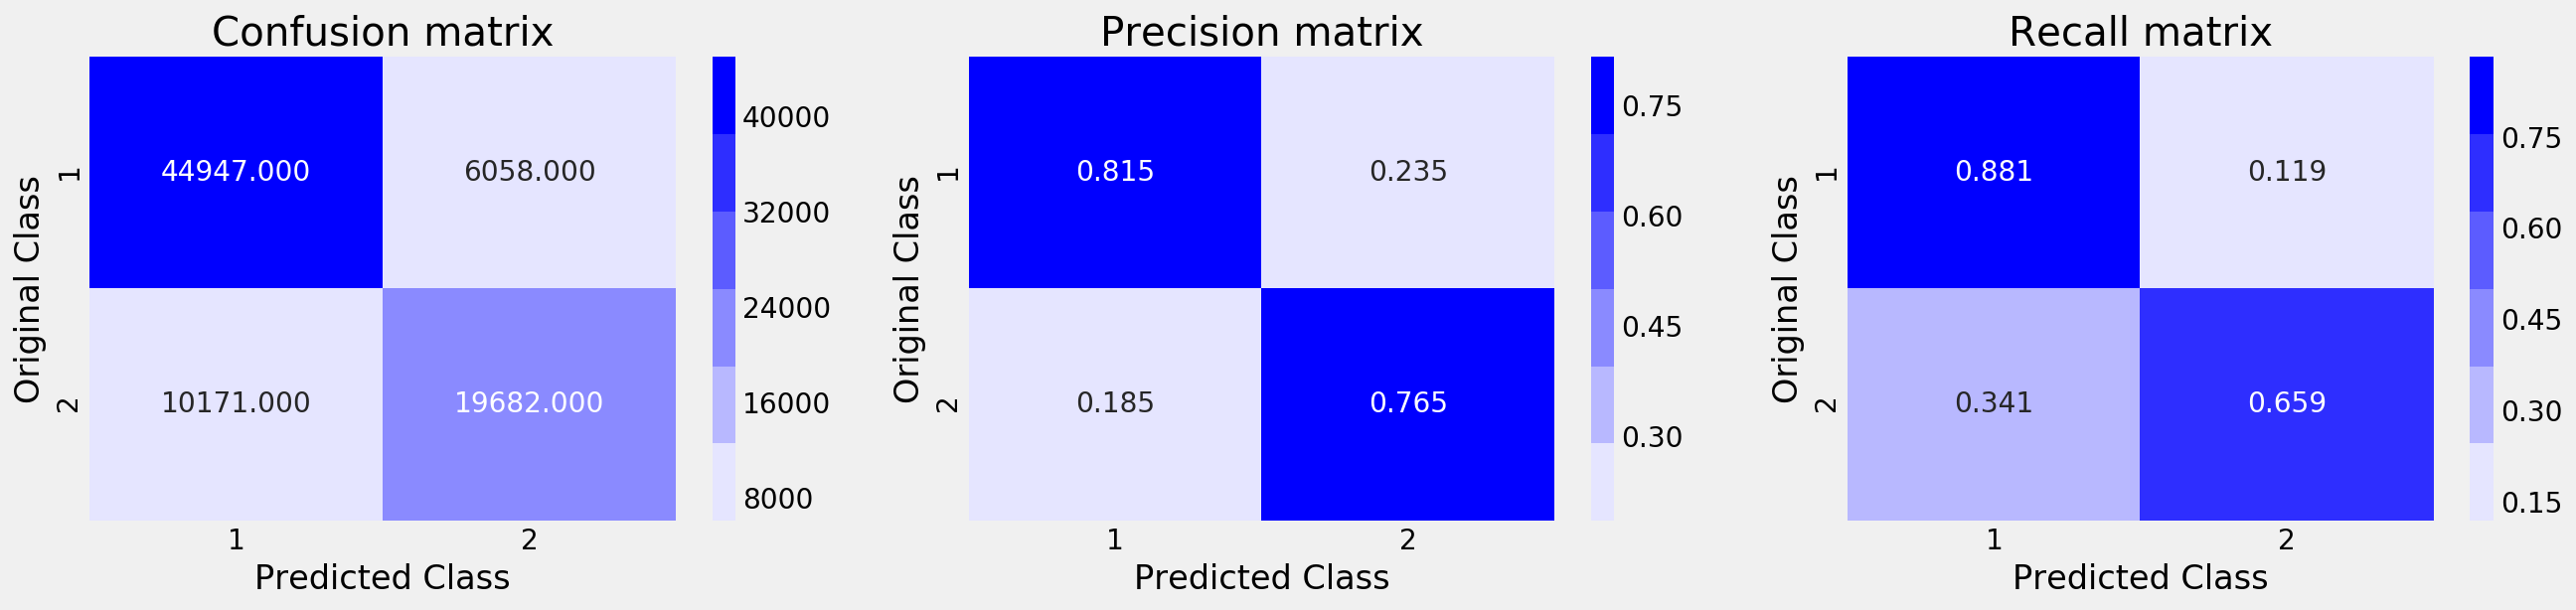

In [24]:
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)